<a href="https://colab.research.google.com/github/skyshine460/GHG_Direct_Emissions/blob/main/submit_ghg28(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 初期設定

In [3]:
pip install pygeohash

In [4]:
pip install catboost

In [5]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib
import math

import pygeohash as pgh

from concurrent.futures import ThreadPoolExecutor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder

import gc
gc.collect()

import os

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# データの読み込み

In [7]:
# 予測モデルを訓練するためのデータセット
train_df = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提供データ/train.csv')

# 予測モデルに推論（予測)させるデータセット
test_df = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提供データ/test.csv')

In [8]:
# 各カラムのデータ型と欠損値（nan）を表示
def information_df(df):
    pd.set_option('display.max_rows', None)
    type_series = df.dtypes
    nunique_series = df.nunique()
    nan_count_series = df.isnull().sum()
    unique_values_series = df.apply(lambda col: list(col.unique()))
    info_df = pd.DataFrame({
        'dtypes': type_series,
        'NaN Count': nan_count_series,
        'Nunique': nunique_series,
        'Unique Values': unique_values_series,
    })
    print(df.shape)
    return info_df

def normal_distribution_fit(df, col):

    # 正規分布のフィッティング
    from scipy.stats import norm
    from scipy import stats
    import matplotlib.pyplot as plt
    import seaborn as sns

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # カテゴリデータかどうかを判定
    if df[col].dtype == 'object' or df[col].dtype.name == 'category':
        # カテゴリデータの場合
        sns.countplot(x=df[col], ax=ax[0])
        ax[0].set_title('Bar Plot of Categorical Data')
    else:
        # 数値データの場合
        sns.histplot(df[col], kde=True, stat='density', ax=ax[0])
        # 正規分布のフィット
        sns.histplot(df[col], stat='density', ax=ax[0], bins=30)
        x = np.linspace(df[col].min(), df[col].max(), 100)
        ax[0].plot(x, norm.pdf(x, df[col].mean(), df[col].std()), color='red')
        ax[0].set_title('Histogram with Normal Distribution Fit')

        # Q-Qプロット
        stats.probplot(df[col], plot=ax[1])
        ax[1].set_title('Q-Q Plot')

    plt.tight_layout()
    plt.show()

    # 数値データの場合のみ歪度と尖度を計算
    if df[col].dtype != 'object' and df[col].dtype.name != 'category':
        print(f"Skewness: {df[col].skew()}")
        print(f"Kurtosis: {df[col].kurt()}")

    # 欠損値の確認
    print(f"isnull: {df[col].isnull().sum()}")

In [9]:
information_df(train_df)

(4655, 22)


,dtypes,NaN Count,Nunique,Unique Values
Unnamed: 0,int64,0,4655,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
FacilityName,object,0,4531,"[VISCOFAN USA INC, CORNWELL STATION - DOMINION..."
Latitude,float64,102,4492,"[40.141389, 38.475305, 39.29982, 35.490363, 41..."
Longitude,float64,102,4486,"[-87.581111, -81.278957, -80.85717, -119.04295..."
LocationAddress,object,179,4435,"[915 N MICHIGAN AVE, 200 RIVER HAVEN ROAD, 304..."
City,object,0,2588,"[DANVILLE, CLENDENIN, GREENWOOD, BAKERSFIELD, ..."
State,object,0,54,"[IL, WV, CA, OH, OK, NM, TN, LA, TX, IN, NC, M..."
ZIP,object,0,3758,"[61832, 25045-9304, 26415, 93308, 441031047, 7..."
County,object,70,1165,"[VERMILION, KANAWHA, RITCHIE, KERN, CUYAHOGA, ..."
FIPScode,float64,73,1646,"[17183.0, 54039.0, 54085.0, 6029.0, 39035.0, 4..."


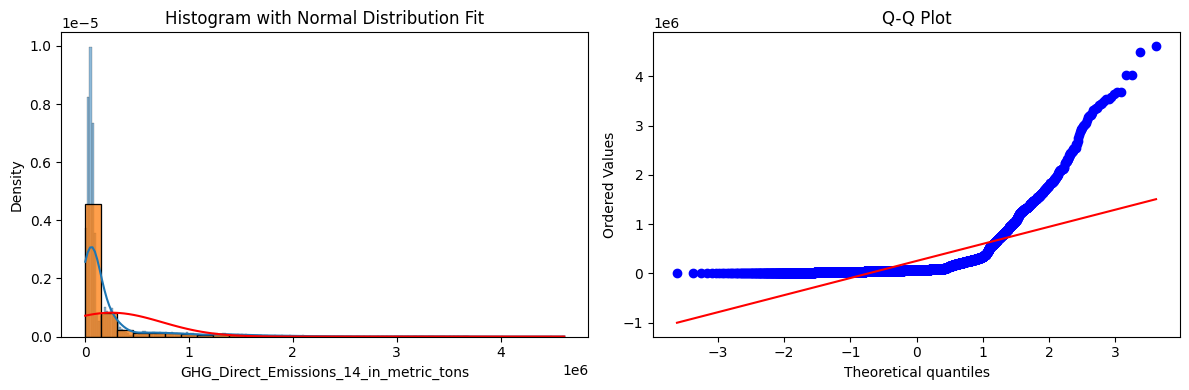

Skewness: 3.6649052199295338
Kurtosis: 16.560320863687245
isnull: 0


In [10]:
normal_distribution_fit(train_df, 'GHG_Direct_Emissions_14_in_metric_tons')

評価指標はRMSLEであり、ヒストグラムも右に裾が長いグラフなので、対数変換を行う。

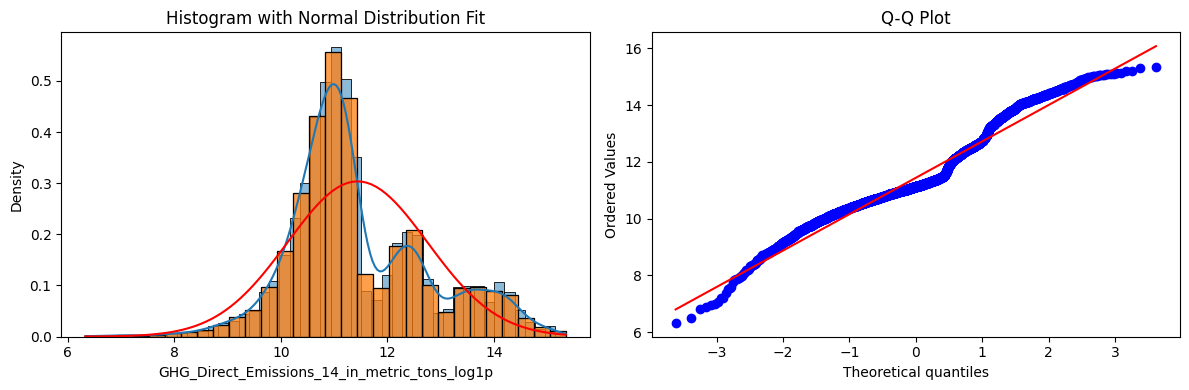

Skewness: 0.545884275422693
Kurtosis: 0.3515490436747801
isnull: 0


In [11]:
train_df['GHG_Direct_Emissions_14_in_metric_tons_log1p'] = np.log1p(train_df['GHG_Direct_Emissions_14_in_metric_tons'])
normal_distribution_fit(train_df, 'GHG_Direct_Emissions_14_in_metric_tons_log1p')

In [12]:
information_df(test_df)

(2508, 21)


,dtypes,NaN Count,Nunique,Unique Values
Unnamed: 0,int64,0,2508,"[4655, 4656, 4657, 4658, 4659, 4660, 4661, 466..."
FacilityName,object,0,2462,"[ROGER AOTSCHEGAROW, EPNG STATION 6543 LORDSBU..."
Latitude,float64,56,2437,"[38.03304, 32.31603, 41.2515, 44.95966, 32.818..."
Longitude,float64,56,2435,"[-97.97317, -108.6068, -78.74244, -93.19341, -..."
LocationAddress,object,113,2386,"[1910 SOUTH BROADACRES ROAD, nan, 3831 ROUTE 2..."
City,object,0,1647,"[HUTCHINSON, LORDSBURG, BROCKPORT, SAINT PAUL,..."
State,object,0,54,"[KS, NM, PA, MN, CA, MS, MT, AZ, IN, NY, IL, F..."
ZIP,object,0,2152,"[67501, 88045, 15823, 551141895, 92123, 38606,..."
County,object,45,865,"[RENO, HIDALGO, JEFFERSON, RAMSEY, SAN DIEGO, ..."
FIPScode,float64,45,1162,"[20155.0, 35023.0, 42065.0, 27123.0, 6073.0, 2..."


In [13]:
def merge_train_test(df_train, df_test):
    if "is_train" not in df_test.columns.tolist():
        df_train["is_train"] = 100
        df_test["is_train"] = -100
    res = pd.concat([df_train, df_test])
    res.reset_index(inplace=True, drop=True)
    return res

def split_train_test(df):
    df_train = df[df["is_train"] != -100]
    df_test = df[df["is_train"] == -100]
    df_train.reset_index(inplace=True, drop=True)
    df_test.reset_index(inplace=True, drop=True)
    return df_train, df_test

df = merge_train_test(train_df, test_df)

In [14]:
# object型をカテゴリ型に変換する
for col in df.columns:
    if df[col].dtype == "object":  # object型の列を探す
        df[col] = df[col].astype("category")  # カテゴリ型に変換

# Locationにかかわる特徴量

In [15]:
# import folium
# import matplotlib.cm as cm
# import matplotlib.colors as colors
# from IPython.display import display

# # 必要なデータを抽出し、新しいデータフレームを作成
# data = train_df[['Latitude', 'Longitude', 'GHG_Direct_Emissions_14_in_metric_tons']].copy()

# # 緯度、経度、排出量のいずれかが欠損している行を削除
# data.dropna(subset=['Latitude', 'Longitude', 'GHG_Direct_Emissions_14_in_metric_tons'], inplace=True)

# # 各列のデータ型を float に変換
# for col in ['Latitude', 'Longitude', 'GHG_Direct_Emissions_14_in_metric_tons']:
#     data[col] = data[col].astype(float)

# # 地図の中心をデータの緯度と経度の平均位置に設定
# map_center = [data['Latitude'].mean(), data['Longitude'].mean()]
# m = folium.Map(location=map_center, zoom_start=5)

# # 排出量の最大値と最小値を取得
# max_emission = data['GHG_Direct_Emissions_14_in_metric_tons'].max()
# min_emission = data['GHG_Direct_Emissions_14_in_metric_tons'].min()

# # カラーマップを設定（排出量が少ない地点は黄色、多い地点は赤色で表示）
# colormap = cm.get_cmap('YlOrRd')
# normalize = colors.Normalize(vmin=min_emission, vmax=max_emission)

# # 各地点に対して、排出量に応じた色の円マーカーを作成し地図に追加
# for idx, row in data.iterrows():
#     # 排出量に基づいて色を設定
#     color = colors.rgb2hex(colormap(normalize(row['GHG_Direct_Emissions_14_in_metric_tons'])))

#     # 円マーカーを作成
#     folium.CircleMarker(
#         location=[row['Latitude'], row['Longitude']],  # 緯度・経度
#         radius=5,  # 円のサイズ
#         popup=f"Emissions: {row['GHG_Direct_Emissions_14_in_metric_tons']}",  # ポップアップに排出量を表示
#         color=color,  # 枠の色
#         fill=True,  # 円を塗りつぶす
#         fill_color=color  # 塗りつぶしの色
#     ).add_to(m)

# # 地図を表示（Jupyter Notebook 上で表示可能）
# display(m)


GHGが高い場所はまばら。地域差や業種に集約できる可能性はあり。
欠損値はそのままとして進める。

# industryにかかわる特徴量

'PrimaryNAICS'について

数字に応じたグループあり。
特に最初の2文字が業種を表す。

In [16]:
naics_types      = {11: 'Agriculture, Forestry, Fishing and Hunting',
                    21: 'Mining, Quarrying, and Oil and Gas Extraction',
                    22: 'Utilities',
                    23: 'Construction',
                    31: 'Manufacturing',
                    32: 'Manufacturing',
                    33: 'Manufacturing',
                    42: 'Wholesale Trade',
                    44: 'Retail Trade',
                    45: 'Retail Trade',
                    48: 'Transportation and Warehousing',
                    49: 'Transportation and Warehousing',
                    51: 'Information',
                    52: 'Finance and Insurance',
                    53: 'Real Estate and Rental and Leasing',
                    54: 'Professional, Scientific, and Technical Services',
                    55: 'Management of Companies and Enterprises',
                    56: 'Administrative and Support and Waste Management and Remediation Services',
                    61: 'Educational Services',
                    62: 'Health Care and Social Assistance',
                    71: 'Arts, Entertainment, and Recreation',
                    72: 'Accommodation and Food Services',
                    81: 'Other Services (except Public Administration)',
                    92: 'Public Administration'}

In [17]:
df['PrimaryNAICS_1-2'] = df['PrimaryNAICS'].astype(str).str[:2].astype(int)
df['PrimaryNAICS_1-3'] = df['PrimaryNAICS'].astype(str).str[:3].astype(int)
df['PrimaryNAICS_1-4'] = df['PrimaryNAICS'].astype(str).str[:4].astype(int)
df['NAICS_Type'] = df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

# 'na' などの変換できない値を NaN にしてから整数に変換
df['SecondPrimaryNAICS_1-2'] = pd.to_numeric(df['SecondPrimaryNAICS'].astype(str).str[:2], errors='coerce')
df['Sub_NAICS_Type'] = df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

df.head()

,Unnamed: 0,FacilityName,Latitude,Longitude,LocationAddress,City,State,ZIP,County,FIPScode,...,GHG_Direct_Emissions_13_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons,GHG_Direct_Emissions_14_in_metric_tons_log1p,is_train,PrimaryNAICS_1-2,PrimaryNAICS_1-3,PrimaryNAICS_1-4,NAICS_Type,SecondPrimaryNAICS_1-2,Sub_NAICS_Type
0,0,VISCOFAN USA INC,40.141389,-87.581111,915 N MICHIGAN AVE,DANVILLE,IL,61832,VERMILION,17183.0,...,45598.125851,52973.139946,10.877559,100,32,326,3261,Manufacturing,NaN,Manufacturing
1,1,"CORNWELL STATION - DOMINION TRANSMISSION, INC",38.475305,-81.278957,200 RIVER HAVEN ROAD,CLENDENIN,WV,25045-9304,KANAWHA,54039.0,...,76376.547318,55910.066617,10.931518,100,48,486,4862,Transportation and Warehousing,NaN,Transportation and Warehousing
2,2,WEST UNION COMPRESSOR STATION,39.299820,-80.857170,3041 LONG RUN RD.,GREENWOOD,WV,26415,RITCHIE,54085.0,...,NaN,55679.543214,10.927386,100,21,211,2111,"Mining, Quarrying, and Oil and Gas Extraction",NaN,"Mining, Quarrying, and Oil and Gas Extraction"
3,3,"DOUBLE ""C"" LIMITED",35.490363,-119.042957,10245 OILFIELD ROAD,BAKERSFIELD,CA,93308,KERN,6029.0,...,53799.011225,61411.902782,11.025375,100,22,221,2211,Utilities,NaN,Utilities
4,4,LAKESHORE PLANT,41.532802,-81.636448,6800 S MARGINAL RD,CLEVELAND,OH,441031047,CUYAHOGA,39035.0,...,17662.966241,43100.469774,10.671312,100,22,221,2211,Utilities,NaN,Utilities


数値の大きさに大きな意味はなさそうなので、categoryか新しい特徴量として使用するのが良いかもしれない。

In [18]:
def create_features1(df):

    df['TRI_diff_11-10'] = df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']
    df['TRI_diff_12-11'] = df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']
    df['TRI_diff_13-12'] = df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']

    df['TRI_Growth_Rate_11'] = np.where(
        df['TRI_Air_Emissions_10_in_lbs'].notna() & (df['TRI_Air_Emissions_10_in_lbs'] != 0),
        (df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']) / df['TRI_Air_Emissions_10_in_lbs'],
        np.nan
    )

    df['TRI_Growth_Rate_12'] = np.where(
        df['TRI_Air_Emissions_11_in_lbs'].notna() & (df['TRI_Air_Emissions_11_in_lbs'] != 0),
        (df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']) / df['TRI_Air_Emissions_11_in_lbs'],
        np.nan
    )

    df['TRI_Growth_Rate_13'] = np.where(
        df['TRI_Air_Emissions_12_in_lbs'].notna() & (df['TRI_Air_Emissions_12_in_lbs'] != 0),
        (df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']) / df['TRI_Air_Emissions_12_in_lbs'],
        np.nan
    )

    return df

df       = create_features1(df)
new_features1 = ['TRI_diff_11-10','TRI_diff_12-11','TRI_diff_13-12', 'TRI_Growth_Rate_11','TRI_Growth_Rate_12','TRI_Growth_Rate_13']

In [19]:
train_distance = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/特徴量/train_distance_5nbrs_.csv')
test_distance = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/特徴量/test_distance_5nbrs_.csv')

In [20]:
# def haversine(lat1, lon1, lat2, lon2):
#     # Convert latitude and longitude from degrees to radians
#     lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

#     # Haversine formula
#     dlat = lat2 - lat1
#     dlon = lon2 - lon1
#     a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
#     c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

#     # Radius of Earth in kilometers (mean radius)
#     R = 6371.0

#     # Calculate the distance
#     distance = R * c
#     return distance

# def calculate_distance(lat1, lon1, lat2, lon2):
#     return haversine(lat1, lon1, lat2, lon2)

# def get_nearest_distance(lat1, lon1, econ_sector_ref, neighbours=5, train_point=False):
#     # Extract the required columns once to NumPy arrays
#     latitudes = train_df['Latitude'].values
#     longitudes = train_df['Longitude'].values
#     ghg_emissions = train_df['GHG_Direct_Emissions_14_in_metric_tons'].values
#     econ_sectors = train_df['NAICS_Type'].values

#     # Filter NaN emissions directly
#     valid_indices = ~np.isnan(ghg_emissions)

#     latitudes = latitudes[valid_indices]
#     longitudes = longitudes[valid_indices]
#     ghg_emissions = ghg_emissions[valid_indices]
#     econ_sectors = econ_sectors[valid_indices]

#     # Parallelize distance calculation using ThreadPoolExecutor
#     with ThreadPoolExecutor() as executor:
#         distances = list(executor.map(calculate_distance,
#                                      [lat1]*len(latitudes),
#                                      [lon1]*len(longitudes),
#                                      latitudes,
#                                      longitudes))

#     # Combine the results into a DataFrame
#     near_df = pd.DataFrame({
#         'Distance': distances,
#         'GHG_emission_14': ghg_emissions,
#         'Economic_Sector': econ_sectors
#     })


#     if train_point:
#         near_df.sort_values(by='Distance', inplace=True)
#         near_df = near_df.dropna()
#         near_df = near_df.iloc[1:].reset_index(drop=True)
#     else:
#         # Sort distances by 'Distance'
#         near_df.sort_values(by='Distance', inplace=True)
#         near_df = near_df.dropna()

#     # Filter by economic sector
#     nearest_locations_econ_sector = near_df[near_df['Economic_Sector'] == econ_sector_ref]

#     # Get the top N nearest for both economic sector and overall
#     sub_near_econ = nearest_locations_econ_sector.head(neighbours)
#     sub_nearest_locations = near_df.head(neighbours)

#     # Compute weighted averages
#     econ_weighted_average = (sub_near_econ['GHG_emission_14'] / np.where(sub_near_econ['Distance'] == 0, 1, sub_near_econ['Distance']) ).sum()
#     near_weighted_average = (sub_nearest_locations['GHG_emission_14'] / np.where(sub_nearest_locations['Distance']==0,1,sub_nearest_locations['Distance'])).sum()

#     # Compute regular averages
#     econ_average = sub_near_econ['GHG_emission_14'].mean()
#     near_average = sub_nearest_locations['GHG_emission_14'].mean()

#     return [econ_weighted_average, econ_average, near_weighted_average, near_average]

In [21]:
# neighbours = 5

# file_path = f"test_distance_{neighbours}nbrs.csv"
# if os.path.exists(file_path):
#     print(f"{file_path} exists. ")
#     test_distance = pd.read_csv(f"test_distance_{neighbours}nbrs.csv")
# else:
#     output = []
#     for index in tqdm(range(test_df.shape[0])):

#         lat1 = test_df.iloc[index]['Latitude']
#         lon1 = test_df.iloc[index]['Longitude']
#         econ_sector_ref = test_df.iloc[index]['NAICS_Type']
#         x = get_nearest_distance(lat1,lon1,econ_sector_ref,neighbours=neighbours,train_point=False)
#         output.append(x)
#     test_distance = pd.DataFrame(output,columns = ['Economy_Sector_Weighted_Avg','Economic_Sector_Average','Nearest_Weighted_Average','Nearest_Average'])
#     test_distance.to_csv(f'test_distance_{neighbours}nbrs.csv',index=False)

# file_path = f"train_distance_{neighbours}nbrs.csv"
# if os.path.exists(file_path):
#     print(f"{file_path} exists. ")
#     train_distance = pd.read_csv(f'train_distance_{neighbours}nbrs.csv')
# else:
#     output = []
#     for index in tqdm(range(train_df.shape[0])):
#         lat1 = train_df.iloc[index]['Latitude']
#         lon1 = train_df.iloc[index]['Longitude']
#         econ_sector_ref = train_df.iloc[index]['NAICS_Type']
#         x = get_nearest_distance(lat1,lon1,econ_sector_ref,neighbours=neighbours, train_point=True)
#         output.append(x)
#     train_distance = pd.DataFrame(output,columns = ['Economy_Sector_Weighted_Avg','Economic_Sector_Average','Nearest_Weighted_Average','Nearest_Average'])
#     train_distance.to_csv(f'train_distance_{neighbours}nbrs.csv',index=False)

train_df, test_df = split_train_test(df)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
train_df = pd.concat((train_df,train_distance),axis=1)

# インデックスをリセットしてから結合
test_df = test_df.reset_index(drop=True)
test_distance = test_distance.reset_index(drop=True)
test_df = pd.concat((test_df, test_distance), axis=1)

# train_df['Economy_Sector_Weighted_Avg'] = train_df['Economy_Sector_Weighted_Avg'].fillna(0)
# train_df['Economic_Sector_Average'] = train_df['Economic_Sector_Average'].fillna(0)

In [22]:
features = [
                        'TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs',
                    'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs','PrimaryNAICS',
                    'GHG_Direct_Emissions_10_in_metric_tons', 'GHG_Direct_Emissions_11_in_metric_tons',
                    'GHG_Direct_Emissions_12_in_metric_tons', 'GHG_Direct_Emissions_13_in_metric_tons',
                        'Latitude','Longitude',
                        'TRI_diff_11-10','TRI_diff_12-11','TRI_diff_13-12', 'TRI_Growth_Rate_11','TRI_Growth_Rate_12','TRI_Growth_Rate_13',
                        'NAICS_Type',
]

In [23]:
train = train_df[features]
target = train_df['GHG_Direct_Emissions_14_in_metric_tons']
test = test_df[features]

In [24]:
pip install optuna

In [25]:
import optuna
from sklearn.metrics import root_mean_squared_log_error
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
import numpy as np
import gc

N_SPLITS = 15
SEED_SKF = 224
np.random.seed(224)

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)

def objective(trial, train, target):
    # Optunaで探索するパラメータ
    xgb_params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 700),
        "max_depth": 4,
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.01),
        "subsample": trial.suggest_float("subsample", 0.6, 0.8),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.8),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 0.01, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1.0, 10.0),
        "random_state": 224,
        'enable_categorical': True,
    }

    oof_predictions = np.zeros(len(train))
    fold_rmsle = []
    train_predictions = np.zeros(len(train))

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

        model = XGBRegressor(**xgb_params)
        _ = model.fit(X_train, np.log1p(y_train))

        valid_preds = np.expm1(model.predict(X_valid))
        train_preds = np.expm1(model.predict(X_train))

        rmsle_valid = root_mean_squared_log_error(y_valid, valid_preds)
        rmsle_train = root_mean_squared_log_error(y_train, train_preds)

        oof_predictions[valid_index] = valid_preds
        train_predictions[train_index] = train_preds

        print(f"Fold {fold} - Train RMSLE: {rmsle_train:.5f}, Valid RMSLE: {rmsle_valid:.5f}")

    RMSLE = root_mean_squared_log_error(target, oof_predictions)
    tr_RMSLE = root_mean_squared_log_error(target, train_predictions)
    print(f"[CV] tr:{tr_RMSLE:.5f} va:{RMSLE:.5f}")
    print("-" * 50)



    return RMSLE


# Optunaでのハイパーパラメータ最適化
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, train, target), n_trials=50)

# 最良のパラメータをリストに格納
params_list = [trial.params for trial in study.trials]

# 選択した範囲のRMSLEスコアを格納するリスト
valid_params_with_rmsle = []


[I 2024-11-29 11:49:40,351] A new study created in memory with name: no-name-1d026b3c-8319-49af-b261-bb56f026b4ba


Fold 0 - Train RMSLE: 0.68439, Valid RMSLE: 0.76834
Fold 1 - Train RMSLE: 0.68115, Valid RMSLE: 0.81974
Fold 2 - Train RMSLE: 0.68753, Valid RMSLE: 0.72846
Fold 3 - Train RMSLE: 0.68506, Valid RMSLE: 0.76675
Fold 4 - Train RMSLE: 0.68937, Valid RMSLE: 0.72034
Fold 5 - Train RMSLE: 0.68233, Valid RMSLE: 0.79314
Fold 6 - Train RMSLE: 0.68868, Valid RMSLE: 0.70666
Fold 7 - Train RMSLE: 0.68438, Valid RMSLE: 0.78210
Fold 8 - Train RMSLE: 0.69165, Valid RMSLE: 0.67668
Fold 9 - Train RMSLE: 0.68270, Valid RMSLE: 0.79386
Fold 10 - Train RMSLE: 0.68630, Valid RMSLE: 0.74884
Fold 11 - Train RMSLE: 0.68956, Valid RMSLE: 0.70025
Fold 12 - Train RMSLE: 0.68401, Valid RMSLE: 0.77492
Fold 13 - Train RMSLE: 0.68468, Valid RMSLE: 0.77339


[I 2024-11-29 11:50:41,622] Trial 0 finished with value: 0.7574978905594024 and parameters: {'n_estimators': 658, 'learning_rate': 0.008028265386597708, 'subsample': 0.7268543750223198, 'colsample_bytree': 0.6756327794074799, 'reg_alpha': 0.03322517512418221, 'reg_lambda': 1.6961257970711157}. Best is trial 0 with value: 0.7574978905594024.


Fold 14 - Train RMSLE: 0.68292, Valid RMSLE: 0.79321
[CV] tr:0.68541 va:0.75750
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72098, Valid RMSLE: 0.77903
Fold 1 - Train RMSLE: 0.71746, Valid RMSLE: 0.83240
Fold 2 - Train RMSLE: 0.72415, Valid RMSLE: 0.73628
Fold 3 - Train RMSLE: 0.72085, Valid RMSLE: 0.76637
Fold 4 - Train RMSLE: 0.72519, Valid RMSLE: 0.72291
Fold 5 - Train RMSLE: 0.71930, Valid RMSLE: 0.78849
Fold 6 - Train RMSLE: 0.72489, Valid RMSLE: 0.71368
Fold 7 - Train RMSLE: 0.72004, Valid RMSLE: 0.79028
Fold 8 - Train RMSLE: 0.72755, Valid RMSLE: 0.68207
Fold 9 - Train RMSLE: 0.71976, Valid RMSLE: 0.79928
Fold 10 - Train RMSLE: 0.72303, Valid RMSLE: 0.74584
Fold 11 - Train RMSLE: 0.72626, Valid RMSLE: 0.70469
Fold 12 - Train RMSLE: 0.72045, Valid RMSLE: 0.78237
Fold 13 - Train RMSLE: 0.72188, Valid RMSLE: 0.76481


[I 2024-11-29 11:51:01,080] Trial 1 finished with value: 0.7621283009554252 and parameters: {'n_estimators': 358, 'learning_rate': 0.008680159291732324, 'subsample': 0.6452938121084095, 'colsample_bytree': 0.6119883360183954, 'reg_alpha': 0.06745048668470147, 'reg_lambda': 9.082459633107415}. Best is trial 0 with value: 0.7574978905594024.


Fold 14 - Train RMSLE: 0.71981, Valid RMSLE: 0.80690
[CV] tr:0.72275 va:0.76213
--------------------------------------------------
Fold 0 - Train RMSLE: 0.68714, Valid RMSLE: 0.76742
Fold 1 - Train RMSLE: 0.68393, Valid RMSLE: 0.81993
Fold 2 - Train RMSLE: 0.69075, Valid RMSLE: 0.72701
Fold 3 - Train RMSLE: 0.68733, Valid RMSLE: 0.76356
Fold 4 - Train RMSLE: 0.69129, Valid RMSLE: 0.72453
Fold 5 - Train RMSLE: 0.68485, Valid RMSLE: 0.79167
Fold 6 - Train RMSLE: 0.69137, Valid RMSLE: 0.70572
Fold 7 - Train RMSLE: 0.68687, Valid RMSLE: 0.78239
Fold 8 - Train RMSLE: 0.69418, Valid RMSLE: 0.67638
Fold 9 - Train RMSLE: 0.68538, Valid RMSLE: 0.79381
Fold 10 - Train RMSLE: 0.68863, Valid RMSLE: 0.74667
Fold 11 - Train RMSLE: 0.69275, Valid RMSLE: 0.69942
Fold 12 - Train RMSLE: 0.68619, Valid RMSLE: 0.77485
Fold 13 - Train RMSLE: 0.68733, Valid RMSLE: 0.77437


[I 2024-11-29 11:51:40,199] Trial 2 finished with value: 0.7571818796317372 and parameters: {'n_estimators': 582, 'learning_rate': 0.009054415961875121, 'subsample': 0.7840539127777468, 'colsample_bytree': 0.7266801046807125, 'reg_alpha': 0.025735545781916218, 'reg_lambda': 3.513900977958369}. Best is trial 2 with value: 0.7571818796317372.


Fold 14 - Train RMSLE: 0.68591, Valid RMSLE: 0.79420
[CV] tr:0.68847 va:0.75718
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71599, Valid RMSLE: 0.77846
Fold 1 - Train RMSLE: 0.71278, Valid RMSLE: 0.82832
Fold 2 - Train RMSLE: 0.71936, Valid RMSLE: 0.73709
Fold 3 - Train RMSLE: 0.71673, Valid RMSLE: 0.76595
Fold 4 - Train RMSLE: 0.72058, Valid RMSLE: 0.72819
Fold 5 - Train RMSLE: 0.71505, Valid RMSLE: 0.78896
Fold 6 - Train RMSLE: 0.72027, Valid RMSLE: 0.70770
Fold 7 - Train RMSLE: 0.71583, Valid RMSLE: 0.78843
Fold 8 - Train RMSLE: 0.72292, Valid RMSLE: 0.68467
Fold 9 - Train RMSLE: 0.71492, Valid RMSLE: 0.80127
Fold 10 - Train RMSLE: 0.71797, Valid RMSLE: 0.74839
Fold 11 - Train RMSLE: 0.72141, Valid RMSLE: 0.70459
Fold 12 - Train RMSLE: 0.71589, Valid RMSLE: 0.78255
Fold 13 - Train RMSLE: 0.71713, Valid RMSLE: 0.77254


[I 2024-11-29 11:52:01,314] Trial 3 finished with value: 0.7624058443415362 and parameters: {'n_estimators': 350, 'learning_rate': 0.007981050321521379, 'subsample': 0.7708606626992869, 'colsample_bytree': 0.7917941842212712, 'reg_alpha': 0.10075046002137436, 'reg_lambda': 2.5152795342285628}. Best is trial 2 with value: 0.7571818796317372.


Fold 14 - Train RMSLE: 0.71470, Valid RMSLE: 0.80310
[CV] tr:0.71745 va:0.76241
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70895, Valid RMSLE: 0.77543
Fold 1 - Train RMSLE: 0.70636, Valid RMSLE: 0.82579
Fold 2 - Train RMSLE: 0.71266, Valid RMSLE: 0.73235
Fold 3 - Train RMSLE: 0.71010, Valid RMSLE: 0.76439
Fold 4 - Train RMSLE: 0.71386, Valid RMSLE: 0.72098
Fold 5 - Train RMSLE: 0.70780, Valid RMSLE: 0.78776
Fold 6 - Train RMSLE: 0.71350, Valid RMSLE: 0.70717
Fold 7 - Train RMSLE: 0.70832, Valid RMSLE: 0.78490
Fold 8 - Train RMSLE: 0.71656, Valid RMSLE: 0.68041
Fold 9 - Train RMSLE: 0.70828, Valid RMSLE: 0.79815
Fold 10 - Train RMSLE: 0.71105, Valid RMSLE: 0.74735
Fold 11 - Train RMSLE: 0.71454, Valid RMSLE: 0.70081
Fold 12 - Train RMSLE: 0.70916, Valid RMSLE: 0.77950
Fold 13 - Train RMSLE: 0.71025, Valid RMSLE: 0.76752


[I 2024-11-29 11:52:38,358] Trial 4 finished with value: 0.7590886219027708 and parameters: {'n_estimators': 569, 'learning_rate': 0.005785779738373833, 'subsample': 0.7127751583330441, 'colsample_bytree': 0.6831225923659892, 'reg_alpha': 0.4960697487010914, 'reg_lambda': 2.035406199259513}. Best is trial 2 with value: 0.7571818796317372.


Fold 14 - Train RMSLE: 0.70773, Valid RMSLE: 0.79770
[CV] tr:0.71054 va:0.75909
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71009, Valid RMSLE: 0.77441
Fold 1 - Train RMSLE: 0.70700, Valid RMSLE: 0.82388
Fold 2 - Train RMSLE: 0.71341, Valid RMSLE: 0.73138
Fold 3 - Train RMSLE: 0.71065, Valid RMSLE: 0.76504
Fold 4 - Train RMSLE: 0.71440, Valid RMSLE: 0.72609
Fold 5 - Train RMSLE: 0.70806, Valid RMSLE: 0.78919
Fold 6 - Train RMSLE: 0.71394, Valid RMSLE: 0.70662
Fold 7 - Train RMSLE: 0.71002, Valid RMSLE: 0.78846
Fold 8 - Train RMSLE: 0.71692, Valid RMSLE: 0.68054
Fold 9 - Train RMSLE: 0.70885, Valid RMSLE: 0.79696
Fold 10 - Train RMSLE: 0.71204, Valid RMSLE: 0.74314
Fold 11 - Train RMSLE: 0.71562, Valid RMSLE: 0.70352
Fold 12 - Train RMSLE: 0.70967, Valid RMSLE: 0.77935
Fold 13 - Train RMSLE: 0.71064, Valid RMSLE: 0.76991


[I 2024-11-29 11:53:06,938] Trial 5 finished with value: 0.7596610428759264 and parameters: {'n_estimators': 428, 'learning_rate': 0.0076086969676468705, 'subsample': 0.7866927388098045, 'colsample_bytree': 0.7893882346168517, 'reg_alpha': 1.0388140795349947, 'reg_lambda': 2.5178656053286255}. Best is trial 2 with value: 0.7571818796317372.


Fold 14 - Train RMSLE: 0.70873, Valid RMSLE: 0.80052
[CV] tr:0.71157 va:0.75966
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70416, Valid RMSLE: 0.77357
Fold 1 - Train RMSLE: 0.70118, Valid RMSLE: 0.82385
Fold 2 - Train RMSLE: 0.70741, Valid RMSLE: 0.73063
Fold 3 - Train RMSLE: 0.70486, Valid RMSLE: 0.76407
Fold 4 - Train RMSLE: 0.70896, Valid RMSLE: 0.71880
Fold 5 - Train RMSLE: 0.70235, Valid RMSLE: 0.78987
Fold 6 - Train RMSLE: 0.70838, Valid RMSLE: 0.70639
Fold 7 - Train RMSLE: 0.70320, Valid RMSLE: 0.78264
Fold 8 - Train RMSLE: 0.71140, Valid RMSLE: 0.67857
Fold 9 - Train RMSLE: 0.70270, Valid RMSLE: 0.79481
Fold 10 - Train RMSLE: 0.70588, Valid RMSLE: 0.74681
Fold 11 - Train RMSLE: 0.70993, Valid RMSLE: 0.69985
Fold 12 - Train RMSLE: 0.70371, Valid RMSLE: 0.77687
Fold 13 - Train RMSLE: 0.70500, Valid RMSLE: 0.76779


[I 2024-11-29 11:53:43,350] Trial 6 finished with value: 0.757954209125257 and parameters: {'n_estimators': 627, 'learning_rate': 0.006017457218542745, 'subsample': 0.7332996971733985, 'colsample_bytree': 0.6565216126828485, 'reg_alpha': 0.07230743044871994, 'reg_lambda': 2.9960245988997647}. Best is trial 2 with value: 0.7571818796317372.


Fold 14 - Train RMSLE: 0.70246, Valid RMSLE: 0.79860
[CV] tr:0.70518 va:0.75795
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72810, Valid RMSLE: 0.78433
Fold 1 - Train RMSLE: 0.72482, Valid RMSLE: 0.83820
Fold 2 - Train RMSLE: 0.73114, Valid RMSLE: 0.74516
Fold 3 - Train RMSLE: 0.72860, Valid RMSLE: 0.76948
Fold 4 - Train RMSLE: 0.73221, Valid RMSLE: 0.72741
Fold 5 - Train RMSLE: 0.72694, Valid RMSLE: 0.79224
Fold 6 - Train RMSLE: 0.73159, Valid RMSLE: 0.71255
Fold 7 - Train RMSLE: 0.72722, Valid RMSLE: 0.79179
Fold 8 - Train RMSLE: 0.73452, Valid RMSLE: 0.68984
Fold 9 - Train RMSLE: 0.72648, Valid RMSLE: 0.80898
Fold 10 - Train RMSLE: 0.72969, Valid RMSLE: 0.75422
Fold 11 - Train RMSLE: 0.73274, Valid RMSLE: 0.70766
Fold 12 - Train RMSLE: 0.72779, Valid RMSLE: 0.79241
Fold 13 - Train RMSLE: 0.72895, Valid RMSLE: 0.77333


[I 2024-11-29 11:54:07,592] Trial 7 finished with value: 0.767601880442844 and parameters: {'n_estimators': 396, 'learning_rate': 0.006160785500026717, 'subsample': 0.6342657628482222, 'colsample_bytree': 0.615315451729639, 'reg_alpha': 0.013251927207974789, 'reg_lambda': 1.523086189544088}. Best is trial 2 with value: 0.7571818796317372.


Fold 14 - Train RMSLE: 0.72658, Valid RMSLE: 0.80968
[CV] tr:0.72953 va:0.76760
--------------------------------------------------
Fold 0 - Train RMSLE: 0.67786, Valid RMSLE: 0.76690
Fold 1 - Train RMSLE: 0.67408, Valid RMSLE: 0.81962
Fold 2 - Train RMSLE: 0.68073, Valid RMSLE: 0.72886
Fold 3 - Train RMSLE: 0.67809, Valid RMSLE: 0.76732
Fold 4 - Train RMSLE: 0.68202, Valid RMSLE: 0.72679
Fold 5 - Train RMSLE: 0.67552, Valid RMSLE: 0.79357
Fold 6 - Train RMSLE: 0.68220, Valid RMSLE: 0.70476
Fold 7 - Train RMSLE: 0.67783, Valid RMSLE: 0.78094
Fold 8 - Train RMSLE: 0.68420, Valid RMSLE: 0.67728
Fold 9 - Train RMSLE: 0.67622, Valid RMSLE: 0.79411
Fold 10 - Train RMSLE: 0.67890, Valid RMSLE: 0.74980
Fold 11 - Train RMSLE: 0.68224, Valid RMSLE: 0.69937
Fold 12 - Train RMSLE: 0.67668, Valid RMSLE: 0.77444
Fold 13 - Train RMSLE: 0.67783, Valid RMSLE: 0.77707


[I 2024-11-29 11:54:45,387] Trial 8 finished with value: 0.7580757963014381 and parameters: {'n_estimators': 669, 'learning_rate': 0.00892446659825477, 'subsample': 0.7885626710840083, 'colsample_bytree': 0.7573378867011186, 'reg_alpha': 0.5827713532600955, 'reg_lambda': 1.3272061961747206}. Best is trial 2 with value: 0.7571818796317372.


Fold 14 - Train RMSLE: 0.67608, Valid RMSLE: 0.79460
[CV] tr:0.67864 va:0.75808
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73410, Valid RMSLE: 0.78709
Fold 1 - Train RMSLE: 0.73134, Valid RMSLE: 0.84353
Fold 2 - Train RMSLE: 0.73759, Valid RMSLE: 0.74855
Fold 3 - Train RMSLE: 0.73525, Valid RMSLE: 0.77163
Fold 4 - Train RMSLE: 0.73878, Valid RMSLE: 0.73154
Fold 5 - Train RMSLE: 0.73350, Valid RMSLE: 0.79484
Fold 6 - Train RMSLE: 0.73847, Valid RMSLE: 0.71833
Fold 7 - Train RMSLE: 0.73352, Valid RMSLE: 0.79547
Fold 8 - Train RMSLE: 0.74108, Valid RMSLE: 0.69426
Fold 9 - Train RMSLE: 0.73327, Valid RMSLE: 0.81174
Fold 10 - Train RMSLE: 0.73674, Valid RMSLE: 0.75454
Fold 11 - Train RMSLE: 0.73973, Valid RMSLE: 0.71318
Fold 12 - Train RMSLE: 0.73418, Valid RMSLE: 0.79573
Fold 13 - Train RMSLE: 0.73562, Valid RMSLE: 0.77364


[I 2024-11-29 11:55:08,976] Trial 9 finished with value: 0.7710705709121918 and parameters: {'n_estimators': 371, 'learning_rate': 0.006254294228910897, 'subsample': 0.684424557728957, 'colsample_bytree': 0.6214308028959687, 'reg_alpha': 0.022954203273773528, 'reg_lambda': 3.2583264115814887}. Best is trial 2 with value: 0.7571818796317372.


Fold 14 - Train RMSLE: 0.73302, Valid RMSLE: 0.81549
[CV] tr:0.73611 va:0.77107
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69654, Valid RMSLE: 0.76986
Fold 1 - Train RMSLE: 0.69316, Valid RMSLE: 0.82051
Fold 2 - Train RMSLE: 0.69962, Valid RMSLE: 0.72666
Fold 3 - Train RMSLE: 0.69661, Valid RMSLE: 0.76423
Fold 4 - Train RMSLE: 0.70069, Valid RMSLE: 0.72478
Fold 5 - Train RMSLE: 0.69384, Valid RMSLE: 0.78886
Fold 6 - Train RMSLE: 0.70060, Valid RMSLE: 0.70602
Fold 7 - Train RMSLE: 0.69556, Valid RMSLE: 0.78521
Fold 8 - Train RMSLE: 0.70295, Valid RMSLE: 0.67616
Fold 9 - Train RMSLE: 0.69516, Valid RMSLE: 0.79180
Fold 10 - Train RMSLE: 0.69829, Valid RMSLE: 0.74472
Fold 11 - Train RMSLE: 0.70146, Valid RMSLE: 0.70185
Fold 12 - Train RMSLE: 0.69580, Valid RMSLE: 0.77869
Fold 13 - Train RMSLE: 0.69611, Valid RMSLE: 0.77012


[I 2024-11-29 11:55:39,443] Trial 10 finished with value: 0.7573541362283505 and parameters: {'n_estimators': 498, 'learning_rate': 0.009860940625045259, 'subsample': 0.6033850456340406, 'colsample_bytree': 0.729137547755396, 'reg_alpha': 0.2041595392466259, 'reg_lambda': 6.146919736740521}. Best is trial 2 with value: 0.7571818796317372.


Fold 14 - Train RMSLE: 0.69481, Valid RMSLE: 0.79515
[CV] tr:0.69743 va:0.75735
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71070, Valid RMSLE: 0.77252
Fold 1 - Train RMSLE: 0.70845, Valid RMSLE: 0.82338
Fold 2 - Train RMSLE: 0.71471, Valid RMSLE: 0.73165
Fold 3 - Train RMSLE: 0.71070, Valid RMSLE: 0.76756
Fold 4 - Train RMSLE: 0.71460, Valid RMSLE: 0.72228
Fold 5 - Train RMSLE: 0.70844, Valid RMSLE: 0.79115
Fold 6 - Train RMSLE: 0.71555, Valid RMSLE: 0.71092
Fold 7 - Train RMSLE: 0.70917, Valid RMSLE: 0.78867
Fold 8 - Train RMSLE: 0.71717, Valid RMSLE: 0.68291
Fold 9 - Train RMSLE: 0.70964, Valid RMSLE: 0.79005
Fold 10 - Train RMSLE: 0.71265, Valid RMSLE: 0.74315
Fold 11 - Train RMSLE: 0.71627, Valid RMSLE: 0.70241
Fold 12 - Train RMSLE: 0.70979, Valid RMSLE: 0.78019
Fold 13 - Train RMSLE: 0.71167, Valid RMSLE: 0.76316


[I 2024-11-29 11:56:09,974] Trial 11 finished with value: 0.7590475969739231 and parameters: {'n_estimators': 505, 'learning_rate': 0.00987117079254519, 'subsample': 0.604629161667552, 'colsample_bytree': 0.731072440289351, 'reg_alpha': 6.06357759870234, 'reg_lambda': 5.543214682925899}. Best is trial 2 with value: 0.7571818796317372.


Fold 14 - Train RMSLE: 0.70927, Valid RMSLE: 0.80040
[CV] tr:0.71200 va:0.75905
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69308, Valid RMSLE: 0.76887
Fold 1 - Train RMSLE: 0.69050, Valid RMSLE: 0.82185
Fold 2 - Train RMSLE: 0.69664, Valid RMSLE: 0.72547
Fold 3 - Train RMSLE: 0.69383, Valid RMSLE: 0.76661
Fold 4 - Train RMSLE: 0.69721, Valid RMSLE: 0.72439
Fold 5 - Train RMSLE: 0.69160, Valid RMSLE: 0.78980
Fold 6 - Train RMSLE: 0.69771, Valid RMSLE: 0.70696
Fold 7 - Train RMSLE: 0.69291, Valid RMSLE: 0.78399
Fold 8 - Train RMSLE: 0.70039, Valid RMSLE: 0.67765
Fold 9 - Train RMSLE: 0.69287, Valid RMSLE: 0.79103
Fold 10 - Train RMSLE: 0.69522, Valid RMSLE: 0.74614
Fold 11 - Train RMSLE: 0.69871, Valid RMSLE: 0.70374
Fold 12 - Train RMSLE: 0.69308, Valid RMSLE: 0.77503
Fold 13 - Train RMSLE: 0.69364, Valid RMSLE: 0.77172


[I 2024-11-29 11:56:41,023] Trial 12 finished with value: 0.7575307364344149 and parameters: {'n_estimators': 506, 'learning_rate': 0.00992266322937209, 'subsample': 0.6850339527357854, 'colsample_bytree': 0.7222280357971254, 'reg_alpha': 0.23403230909082948, 'reg_lambda': 5.3391336520877175}. Best is trial 2 with value: 0.7571818796317372.


Fold 14 - Train RMSLE: 0.69253, Valid RMSLE: 0.79435
[CV] tr:0.69513 va:0.75753
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69902, Valid RMSLE: 0.77055
Fold 1 - Train RMSLE: 0.69611, Valid RMSLE: 0.82145
Fold 2 - Train RMSLE: 0.70213, Valid RMSLE: 0.72859
Fold 3 - Train RMSLE: 0.69963, Valid RMSLE: 0.76775
Fold 4 - Train RMSLE: 0.70359, Valid RMSLE: 0.72188
Fold 5 - Train RMSLE: 0.69645, Valid RMSLE: 0.79134
Fold 6 - Train RMSLE: 0.70365, Valid RMSLE: 0.70574
Fold 7 - Train RMSLE: 0.69836, Valid RMSLE: 0.78656
Fold 8 - Train RMSLE: 0.70652, Valid RMSLE: 0.68137
Fold 9 - Train RMSLE: 0.69794, Valid RMSLE: 0.79278
Fold 10 - Train RMSLE: 0.70049, Valid RMSLE: 0.74599
Fold 11 - Train RMSLE: 0.70459, Valid RMSLE: 0.69968
Fold 12 - Train RMSLE: 0.69839, Valid RMSLE: 0.77616
Fold 13 - Train RMSLE: 0.69914, Valid RMSLE: 0.76994


[I 2024-11-29 11:57:13,180] Trial 13 finished with value: 0.7581971953662708 and parameters: {'n_estimators': 559, 'learning_rate': 0.008986343404787267, 'subsample': 0.7540532985433019, 'colsample_bytree': 0.7187963391775339, 'reg_alpha': 2.367926880526437, 'reg_lambda': 4.591866688243734}. Best is trial 2 with value: 0.7571818796317372.


Fold 14 - Train RMSLE: 0.69698, Valid RMSLE: 0.79743
[CV] tr:0.69974 va:0.75820
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71758, Valid RMSLE: 0.77673
Fold 1 - Train RMSLE: 0.71480, Valid RMSLE: 0.82899
Fold 2 - Train RMSLE: 0.72133, Valid RMSLE: 0.73424
Fold 3 - Train RMSLE: 0.71823, Valid RMSLE: 0.76544
Fold 4 - Train RMSLE: 0.72172, Valid RMSLE: 0.72229
Fold 5 - Train RMSLE: 0.71578, Valid RMSLE: 0.78878
Fold 6 - Train RMSLE: 0.72190, Valid RMSLE: 0.71239
Fold 7 - Train RMSLE: 0.71644, Valid RMSLE: 0.79102
Fold 8 - Train RMSLE: 0.72434, Valid RMSLE: 0.68242
Fold 9 - Train RMSLE: 0.71639, Valid RMSLE: 0.79828
Fold 10 - Train RMSLE: 0.71989, Valid RMSLE: 0.74496
Fold 11 - Train RMSLE: 0.72266, Valid RMSLE: 0.70428
Fold 12 - Train RMSLE: 0.71720, Valid RMSLE: 0.78193
Fold 13 - Train RMSLE: 0.71839, Valid RMSLE: 0.76628


[I 2024-11-29 11:57:41,643] Trial 14 finished with value: 0.7611393394604302 and parameters: {'n_estimators': 450, 'learning_rate': 0.006963303908876074, 'subsample': 0.656856015895244, 'colsample_bytree': 0.7466491955360984, 'reg_alpha': 0.18230452827883517, 'reg_lambda': 8.687877681670118}. Best is trial 2 with value: 0.7571818796317372.


Fold 14 - Train RMSLE: 0.71641, Valid RMSLE: 0.80294
[CV] tr:0.71938 va:0.76114
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70088, Valid RMSLE: 0.77242
Fold 1 - Train RMSLE: 0.69830, Valid RMSLE: 0.82190
Fold 2 - Train RMSLE: 0.70472, Valid RMSLE: 0.72986
Fold 3 - Train RMSLE: 0.70184, Valid RMSLE: 0.76535
Fold 4 - Train RMSLE: 0.70537, Valid RMSLE: 0.72033
Fold 5 - Train RMSLE: 0.69916, Valid RMSLE: 0.78895
Fold 6 - Train RMSLE: 0.70539, Valid RMSLE: 0.70677
Fold 7 - Train RMSLE: 0.70061, Valid RMSLE: 0.78550
Fold 8 - Train RMSLE: 0.70847, Valid RMSLE: 0.67949
Fold 9 - Train RMSLE: 0.70006, Valid RMSLE: 0.79556
Fold 10 - Train RMSLE: 0.70291, Valid RMSLE: 0.74445
Fold 11 - Train RMSLE: 0.70684, Valid RMSLE: 0.69952
Fold 12 - Train RMSLE: 0.70079, Valid RMSLE: 0.77628
Fold 13 - Train RMSLE: 0.70190, Valid RMSLE: 0.77074


[I 2024-11-29 11:58:22,533] Trial 15 finished with value: 0.7580344256406285 and parameters: {'n_estimators': 573, 'learning_rate': 0.0069251427309972875, 'subsample': 0.7513577526494899, 'colsample_bytree': 0.7621886394380558, 'reg_alpha': 0.01282595220827728, 'reg_lambda': 4.17440572253387}. Best is trial 2 with value: 0.7571818796317372.


Fold 14 - Train RMSLE: 0.69974, Valid RMSLE: 0.79742
[CV] tr:0.70252 va:0.75803
--------------------------------------------------
Fold 0 - Train RMSLE: 0.78191, Valid RMSLE: 0.81741
Fold 1 - Train RMSLE: 0.77824, Valid RMSLE: 0.88573
Fold 2 - Train RMSLE: 0.78428, Valid RMSLE: 0.79345
Fold 3 - Train RMSLE: 0.78252, Valid RMSLE: 0.79984
Fold 4 - Train RMSLE: 0.78587, Valid RMSLE: 0.76890
Fold 5 - Train RMSLE: 0.78122, Valid RMSLE: 0.82189
Fold 6 - Train RMSLE: 0.78548, Valid RMSLE: 0.75134
Fold 7 - Train RMSLE: 0.78076, Valid RMSLE: 0.83455
Fold 8 - Train RMSLE: 0.78805, Valid RMSLE: 0.73443
Fold 9 - Train RMSLE: 0.78020, Valid RMSLE: 0.85538
Fold 10 - Train RMSLE: 0.78399, Valid RMSLE: 0.78497
Fold 11 - Train RMSLE: 0.78658, Valid RMSLE: 0.75249
Fold 12 - Train RMSLE: 0.78133, Valid RMSLE: 0.83559
Fold 13 - Train RMSLE: 0.78331, Valid RMSLE: 0.79951


[I 2024-11-29 11:58:39,772] Trial 16 finished with value: 0.807303438696888 and parameters: {'n_estimators': 300, 'learning_rate': 0.005173145362164708, 'subsample': 0.674230544207958, 'colsample_bytree': 0.7006493209496006, 'reg_alpha': 0.03521008550516458, 'reg_lambda': 6.90713459240068}. Best is trial 2 with value: 0.7571818796317372.


Fold 14 - Train RMSLE: 0.77985, Valid RMSLE: 0.85751
[CV] tr:0.78329 va:0.80730
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69121, Valid RMSLE: 0.76956
Fold 1 - Train RMSLE: 0.68794, Valid RMSLE: 0.81991
Fold 2 - Train RMSLE: 0.69472, Valid RMSLE: 0.72622
Fold 3 - Train RMSLE: 0.69128, Valid RMSLE: 0.76810
Fold 4 - Train RMSLE: 0.69477, Valid RMSLE: 0.72426
Fold 5 - Train RMSLE: 0.68855, Valid RMSLE: 0.79226
Fold 6 - Train RMSLE: 0.69559, Valid RMSLE: 0.70450
Fold 7 - Train RMSLE: 0.69015, Valid RMSLE: 0.78459
Fold 8 - Train RMSLE: 0.69754, Valid RMSLE: 0.67985
Fold 9 - Train RMSLE: 0.69042, Valid RMSLE: 0.79164
Fold 10 - Train RMSLE: 0.69304, Valid RMSLE: 0.74762
Fold 11 - Train RMSLE: 0.69646, Valid RMSLE: 0.70254
Fold 12 - Train RMSLE: 0.69045, Valid RMSLE: 0.77795
Fold 13 - Train RMSLE: 0.69078, Valid RMSLE: 0.77141


[I 2024-11-29 11:59:19,997] Trial 17 finished with value: 0.7582741964944387 and parameters: {'n_estimators': 611, 'learning_rate': 0.009298979731015738, 'subsample': 0.6037601035075312, 'colsample_bytree': 0.6988268016276737, 'reg_alpha': 1.364613160244704, 'reg_lambda': 3.6525554687025825}. Best is trial 2 with value: 0.7571818796317372.


Fold 14 - Train RMSLE: 0.68930, Valid RMSLE: 0.79808
[CV] tr:0.69191 va:0.75827
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70876, Valid RMSLE: 0.77439
Fold 1 - Train RMSLE: 0.70546, Valid RMSLE: 0.82337
Fold 2 - Train RMSLE: 0.71205, Valid RMSLE: 0.72905
Fold 3 - Train RMSLE: 0.70882, Valid RMSLE: 0.76571
Fold 4 - Train RMSLE: 0.71291, Valid RMSLE: 0.72049
Fold 5 - Train RMSLE: 0.70731, Valid RMSLE: 0.78813
Fold 6 - Train RMSLE: 0.71249, Valid RMSLE: 0.71034
Fold 7 - Train RMSLE: 0.70792, Valid RMSLE: 0.78412
Fold 8 - Train RMSLE: 0.71536, Valid RMSLE: 0.67791
Fold 9 - Train RMSLE: 0.70719, Valid RMSLE: 0.79412
Fold 10 - Train RMSLE: 0.71072, Valid RMSLE: 0.74485
Fold 11 - Train RMSLE: 0.71352, Valid RMSLE: 0.70117
Fold 12 - Train RMSLE: 0.70797, Valid RMSLE: 0.77733
Fold 13 - Train RMSLE: 0.70962, Valid RMSLE: 0.76607


[I 2024-11-29 11:59:45,486] Trial 18 finished with value: 0.7581274608556037 and parameters: {'n_estimators': 481, 'learning_rate': 0.008086732277167661, 'subsample': 0.6213139448793182, 'colsample_bytree': 0.655162431194344, 'reg_alpha': 0.12374795533745644, 'reg_lambda': 6.940004533619218}. Best is trial 2 with value: 0.7571818796317372.


Fold 14 - Train RMSLE: 0.70717, Valid RMSLE: 0.79896
[CV] tr:0.70996 va:0.75813
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71329, Valid RMSLE: 0.77165
Fold 1 - Train RMSLE: 0.71042, Valid RMSLE: 0.82365
Fold 2 - Train RMSLE: 0.71650, Valid RMSLE: 0.73054
Fold 3 - Train RMSLE: 0.71302, Valid RMSLE: 0.76870
Fold 4 - Train RMSLE: 0.71668, Valid RMSLE: 0.72103
Fold 5 - Train RMSLE: 0.71116, Valid RMSLE: 0.79129
Fold 6 - Train RMSLE: 0.71789, Valid RMSLE: 0.71228
Fold 7 - Train RMSLE: 0.71166, Valid RMSLE: 0.78931
Fold 8 - Train RMSLE: 0.71965, Valid RMSLE: 0.68250
Fold 9 - Train RMSLE: 0.71225, Valid RMSLE: 0.79251
Fold 10 - Train RMSLE: 0.71452, Valid RMSLE: 0.74353
Fold 11 - Train RMSLE: 0.71859, Valid RMSLE: 0.69979
Fold 12 - Train RMSLE: 0.71246, Valid RMSLE: 0.77852
Fold 13 - Train RMSLE: 0.71338, Valid RMSLE: 0.76576


[I 2024-11-29 12:00:19,433] Trial 19 finished with value: 0.759093954868271 and parameters: {'n_estimators': 536, 'learning_rate': 0.009522200439432459, 'subsample': 0.7043397686918603, 'colsample_bytree': 0.7746644943746132, 'reg_alpha': 9.520554997434978, 'reg_lambda': 1.1047531997297788}. Best is trial 2 with value: 0.7571818796317372.


Fold 14 - Train RMSLE: 0.71166, Valid RMSLE: 0.79971
[CV] tr:0.71444 va:0.75909
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69510, Valid RMSLE: 0.77000
Fold 1 - Train RMSLE: 0.69146, Valid RMSLE: 0.82195
Fold 2 - Train RMSLE: 0.69837, Valid RMSLE: 0.72774
Fold 3 - Train RMSLE: 0.69535, Valid RMSLE: 0.76818
Fold 4 - Train RMSLE: 0.69875, Valid RMSLE: 0.72230
Fold 5 - Train RMSLE: 0.69239, Valid RMSLE: 0.79101
Fold 6 - Train RMSLE: 0.69897, Valid RMSLE: 0.70618
Fold 7 - Train RMSLE: 0.69385, Valid RMSLE: 0.78490
Fold 8 - Train RMSLE: 0.70171, Valid RMSLE: 0.67835
Fold 9 - Train RMSLE: 0.69353, Valid RMSLE: 0.79294
Fold 10 - Train RMSLE: 0.69622, Valid RMSLE: 0.74508
Fold 11 - Train RMSLE: 0.69977, Valid RMSLE: 0.70148
Fold 12 - Train RMSLE: 0.69410, Valid RMSLE: 0.77592
Fold 13 - Train RMSLE: 0.69508, Valid RMSLE: 0.77011


[I 2024-11-29 12:00:55,227] Trial 20 finished with value: 0.7578720950561887 and parameters: {'n_estimators': 602, 'learning_rate': 0.008547162502713515, 'subsample': 0.6686178263461653, 'colsample_bytree': 0.742396891228407, 'reg_alpha': 0.43006817193523067, 'reg_lambda': 6.673015840341728}. Best is trial 2 with value: 0.7571818796317372.


Fold 14 - Train RMSLE: 0.69295, Valid RMSLE: 0.79611
[CV] tr:0.69570 va:0.75787
--------------------------------------------------
Fold 0 - Train RMSLE: 0.68663, Valid RMSLE: 0.76777
Fold 1 - Train RMSLE: 0.68406, Valid RMSLE: 0.82018
Fold 2 - Train RMSLE: 0.68999, Valid RMSLE: 0.73050
Fold 3 - Train RMSLE: 0.68766, Valid RMSLE: 0.76567
Fold 4 - Train RMSLE: 0.69174, Valid RMSLE: 0.72048
Fold 5 - Train RMSLE: 0.68480, Valid RMSLE: 0.79112
Fold 6 - Train RMSLE: 0.69130, Valid RMSLE: 0.70501
Fold 7 - Train RMSLE: 0.68683, Valid RMSLE: 0.78170
Fold 8 - Train RMSLE: 0.69396, Valid RMSLE: 0.67784
Fold 9 - Train RMSLE: 0.68590, Valid RMSLE: 0.79274
Fold 10 - Train RMSLE: 0.68886, Valid RMSLE: 0.74742
Fold 11 - Train RMSLE: 0.69193, Valid RMSLE: 0.70068
Fold 12 - Train RMSLE: 0.68623, Valid RMSLE: 0.77496
Fold 13 - Train RMSLE: 0.68715, Valid RMSLE: 0.77257


[I 2024-11-29 12:01:35,304] Trial 21 finished with value: 0.757135891204226 and parameters: {'n_estimators': 688, 'learning_rate': 0.00744010392232009, 'subsample': 0.7326978311062271, 'colsample_bytree': 0.668426128904017, 'reg_alpha': 0.03879629892106809, 'reg_lambda': 2.0268697963229156}. Best is trial 21 with value: 0.757135891204226.


Fold 14 - Train RMSLE: 0.68591, Valid RMSLE: 0.79289
[CV] tr:0.68835 va:0.75714
--------------------------------------------------
Fold 0 - Train RMSLE: 0.68741, Valid RMSLE: 0.77007
Fold 1 - Train RMSLE: 0.68365, Valid RMSLE: 0.82091
Fold 2 - Train RMSLE: 0.69019, Valid RMSLE: 0.72897
Fold 3 - Train RMSLE: 0.68782, Valid RMSLE: 0.76733
Fold 4 - Train RMSLE: 0.69144, Valid RMSLE: 0.72034
Fold 5 - Train RMSLE: 0.68443, Valid RMSLE: 0.79104
Fold 6 - Train RMSLE: 0.69129, Valid RMSLE: 0.70399
Fold 7 - Train RMSLE: 0.68659, Valid RMSLE: 0.78155
Fold 8 - Train RMSLE: 0.69395, Valid RMSLE: 0.67774
Fold 9 - Train RMSLE: 0.68589, Valid RMSLE: 0.79462
Fold 10 - Train RMSLE: 0.68861, Valid RMSLE: 0.74995
Fold 11 - Train RMSLE: 0.69258, Valid RMSLE: 0.69894
Fold 12 - Train RMSLE: 0.68669, Valid RMSLE: 0.77565
Fold 13 - Train RMSLE: 0.68681, Valid RMSLE: 0.77251


[I 2024-11-29 12:02:17,929] Trial 22 finished with value: 0.7576314686601556 and parameters: {'n_estimators': 699, 'learning_rate': 0.007445910211376389, 'subsample': 0.769619618113364, 'colsample_bytree': 0.6445898869414198, 'reg_alpha': 0.042496228431431464, 'reg_lambda': 2.022822295918724}. Best is trial 21 with value: 0.757135891204226.


Fold 14 - Train RMSLE: 0.68604, Valid RMSLE: 0.79480
[CV] tr:0.68858 va:0.75763
--------------------------------------------------
Fold 0 - Train RMSLE: 0.68514, Valid RMSLE: 0.76753
Fold 1 - Train RMSLE: 0.68224, Valid RMSLE: 0.81978
Fold 2 - Train RMSLE: 0.68834, Valid RMSLE: 0.73111
Fold 3 - Train RMSLE: 0.68563, Valid RMSLE: 0.76647
Fold 4 - Train RMSLE: 0.68980, Valid RMSLE: 0.72104
Fold 5 - Train RMSLE: 0.68264, Valid RMSLE: 0.79350
Fold 6 - Train RMSLE: 0.68968, Valid RMSLE: 0.70440
Fold 7 - Train RMSLE: 0.68474, Valid RMSLE: 0.78151
Fold 8 - Train RMSLE: 0.69237, Valid RMSLE: 0.67851
Fold 9 - Train RMSLE: 0.68389, Valid RMSLE: 0.79394
Fold 10 - Train RMSLE: 0.68736, Valid RMSLE: 0.74806
Fold 11 - Train RMSLE: 0.69063, Valid RMSLE: 0.70163
Fold 12 - Train RMSLE: 0.68496, Valid RMSLE: 0.77516
Fold 13 - Train RMSLE: 0.68517, Valid RMSLE: 0.77351


[I 2024-11-29 12:02:52,859] Trial 23 finished with value: 0.7576896487435565 and parameters: {'n_estimators': 646, 'learning_rate': 0.008369734352259859, 'subsample': 0.735098521926743, 'colsample_bytree': 0.7012857223875848, 'reg_alpha': 0.019380062582964583, 'reg_lambda': 2.5295161641972084}. Best is trial 21 with value: 0.757135891204226.


Fold 14 - Train RMSLE: 0.68388, Valid RMSLE: 0.79365
[CV] tr:0.68640 va:0.75769
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69629, Valid RMSLE: 0.77219
Fold 1 - Train RMSLE: 0.69327, Valid RMSLE: 0.82118
Fold 2 - Train RMSLE: 0.69990, Valid RMSLE: 0.72858
Fold 3 - Train RMSLE: 0.69696, Valid RMSLE: 0.76635
Fold 4 - Train RMSLE: 0.70095, Valid RMSLE: 0.72025
Fold 5 - Train RMSLE: 0.69382, Valid RMSLE: 0.78940
Fold 6 - Train RMSLE: 0.70064, Valid RMSLE: 0.70622
Fold 7 - Train RMSLE: 0.69608, Valid RMSLE: 0.78468
Fold 8 - Train RMSLE: 0.70378, Valid RMSLE: 0.67821
Fold 9 - Train RMSLE: 0.69561, Valid RMSLE: 0.79434
Fold 10 - Train RMSLE: 0.69788, Valid RMSLE: 0.74514
Fold 11 - Train RMSLE: 0.70211, Valid RMSLE: 0.70049
Fold 12 - Train RMSLE: 0.69624, Valid RMSLE: 0.77508
Fold 13 - Train RMSLE: 0.69716, Valid RMSLE: 0.76961


[I 2024-11-29 12:03:33,788] Trial 24 finished with value: 0.7576357005651725 and parameters: {'n_estimators': 688, 'learning_rate': 0.0065785338700567395, 'subsample': 0.7571134937310736, 'colsample_bytree': 0.6808502590794521, 'reg_alpha': 0.052390691082344204, 'reg_lambda': 4.211590329765489}. Best is trial 21 with value: 0.757135891204226.


Fold 14 - Train RMSLE: 0.69502, Valid RMSLE: 0.79688
[CV] tr:0.69779 va:0.75764
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70446, Valid RMSLE: 0.77383
Fold 1 - Train RMSLE: 0.70176, Valid RMSLE: 0.82336
Fold 2 - Train RMSLE: 0.70802, Valid RMSLE: 0.73203
Fold 3 - Train RMSLE: 0.70568, Valid RMSLE: 0.76661
Fold 4 - Train RMSLE: 0.70950, Valid RMSLE: 0.72115
Fold 5 - Train RMSLE: 0.70325, Valid RMSLE: 0.78812
Fold 6 - Train RMSLE: 0.70835, Valid RMSLE: 0.70628
Fold 7 - Train RMSLE: 0.70462, Valid RMSLE: 0.78418
Fold 8 - Train RMSLE: 0.71198, Valid RMSLE: 0.67846
Fold 9 - Train RMSLE: 0.70362, Valid RMSLE: 0.79629
Fold 10 - Train RMSLE: 0.70666, Valid RMSLE: 0.74690
Fold 11 - Train RMSLE: 0.71035, Valid RMSLE: 0.69834
Fold 12 - Train RMSLE: 0.70432, Valid RMSLE: 0.77753
Fold 13 - Train RMSLE: 0.70532, Valid RMSLE: 0.76933


[I 2024-11-29 12:04:01,786] Trial 25 finished with value: 0.7584387631436333 and parameters: {'n_estimators': 470, 'learning_rate': 0.007433529008133043, 'subsample': 0.7972809258793039, 'colsample_bytree': 0.7141285886811631, 'reg_alpha': 0.13224891674853262, 'reg_lambda': 1.9183402534883358}. Best is trial 21 with value: 0.757135891204226.


Fold 14 - Train RMSLE: 0.70358, Valid RMSLE: 0.79794
[CV] tr:0.70637 va:0.75844
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69086, Valid RMSLE: 0.76833
Fold 1 - Train RMSLE: 0.68802, Valid RMSLE: 0.81991
Fold 2 - Train RMSLE: 0.69419, Valid RMSLE: 0.73111
Fold 3 - Train RMSLE: 0.69191, Valid RMSLE: 0.76419
Fold 4 - Train RMSLE: 0.69635, Valid RMSLE: 0.72168
Fold 5 - Train RMSLE: 0.68934, Valid RMSLE: 0.79111
Fold 6 - Train RMSLE: 0.69567, Valid RMSLE: 0.70644
Fold 7 - Train RMSLE: 0.69025, Valid RMSLE: 0.78137
Fold 8 - Train RMSLE: 0.69926, Valid RMSLE: 0.67602
Fold 9 - Train RMSLE: 0.69026, Valid RMSLE: 0.79162
Fold 10 - Train RMSLE: 0.69282, Valid RMSLE: 0.74698
Fold 11 - Train RMSLE: 0.69709, Valid RMSLE: 0.70046
Fold 12 - Train RMSLE: 0.69085, Valid RMSLE: 0.77380
Fold 13 - Train RMSLE: 0.69119, Valid RMSLE: 0.77063


[I 2024-11-29 12:04:30,713] Trial 26 finished with value: 0.7569984570878642 and parameters: {'n_estimators': 534, 'learning_rate': 0.009288824039938583, 'subsample': 0.7225137636905843, 'colsample_bytree': 0.6388915852043915, 'reg_alpha': 0.010107274639265452, 'reg_lambda': 2.89161261032836}. Best is trial 26 with value: 0.7569984570878642.


Fold 14 - Train RMSLE: 0.68949, Valid RMSLE: 0.79578
[CV] tr:0.69208 va:0.75700
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69211, Valid RMSLE: 0.76953
Fold 1 - Train RMSLE: 0.68835, Valid RMSLE: 0.82195
Fold 2 - Train RMSLE: 0.69494, Valid RMSLE: 0.73150
Fold 3 - Train RMSLE: 0.69229, Valid RMSLE: 0.76348
Fold 4 - Train RMSLE: 0.69697, Valid RMSLE: 0.72107
Fold 5 - Train RMSLE: 0.69030, Valid RMSLE: 0.78986
Fold 6 - Train RMSLE: 0.69602, Valid RMSLE: 0.70728
Fold 7 - Train RMSLE: 0.69142, Valid RMSLE: 0.78122
Fold 8 - Train RMSLE: 0.69994, Valid RMSLE: 0.67511
Fold 9 - Train RMSLE: 0.69090, Valid RMSLE: 0.79291
Fold 10 - Train RMSLE: 0.69372, Valid RMSLE: 0.74752
Fold 11 - Train RMSLE: 0.69749, Valid RMSLE: 0.70088
Fold 12 - Train RMSLE: 0.69215, Valid RMSLE: 0.77396
Fold 13 - Train RMSLE: 0.69205, Valid RMSLE: 0.77087


[I 2024-11-29 12:04:59,803] Trial 27 finished with value: 0.7572495859063415 and parameters: {'n_estimators': 528, 'learning_rate': 0.009293621067283356, 'subsample': 0.7141733667380421, 'colsample_bytree': 0.6311619752521697, 'reg_alpha': 0.010124137007466652, 'reg_lambda': 2.9249049553487745}. Best is trial 26 with value: 0.7569984570878642.


Fold 14 - Train RMSLE: 0.69033, Valid RMSLE: 0.79586
[CV] tr:0.69294 va:0.75725
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71477, Valid RMSLE: 0.77760
Fold 1 - Train RMSLE: 0.71206, Valid RMSLE: 0.82862
Fold 2 - Train RMSLE: 0.71864, Valid RMSLE: 0.73482
Fold 3 - Train RMSLE: 0.71584, Valid RMSLE: 0.76588
Fold 4 - Train RMSLE: 0.71972, Valid RMSLE: 0.71912
Fold 5 - Train RMSLE: 0.71378, Valid RMSLE: 0.78882
Fold 6 - Train RMSLE: 0.71920, Valid RMSLE: 0.70887
Fold 7 - Train RMSLE: 0.71419, Valid RMSLE: 0.78589
Fold 8 - Train RMSLE: 0.72218, Valid RMSLE: 0.68319
Fold 9 - Train RMSLE: 0.71391, Valid RMSLE: 0.79821
Fold 10 - Train RMSLE: 0.71703, Valid RMSLE: 0.74703
Fold 11 - Train RMSLE: 0.72058, Valid RMSLE: 0.70273
Fold 12 - Train RMSLE: 0.71495, Valid RMSLE: 0.78163
Fold 13 - Train RMSLE: 0.71576, Valid RMSLE: 0.76705


[I 2024-11-29 12:05:29,662] Trial 28 finished with value: 0.7604423194312414 and parameters: {'n_estimators': 580, 'learning_rate': 0.00543718547937269, 'subsample': 0.7443552860045396, 'colsample_bytree': 0.6003755353491322, 'reg_alpha': 0.021427557623899036, 'reg_lambda': 3.4978117037435092}. Best is trial 26 with value: 0.7569984570878642.


Fold 14 - Train RMSLE: 0.71320, Valid RMSLE: 0.80098
[CV] tr:0.71603 va:0.76044
--------------------------------------------------
Fold 0 - Train RMSLE: 0.68572, Valid RMSLE: 0.76876
Fold 1 - Train RMSLE: 0.68281, Valid RMSLE: 0.82060
Fold 2 - Train RMSLE: 0.68874, Valid RMSLE: 0.72943
Fold 3 - Train RMSLE: 0.68631, Valid RMSLE: 0.76686
Fold 4 - Train RMSLE: 0.69013, Valid RMSLE: 0.72285
Fold 5 - Train RMSLE: 0.68268, Valid RMSLE: 0.79257
Fold 6 - Train RMSLE: 0.68976, Valid RMSLE: 0.70640
Fold 7 - Train RMSLE: 0.68572, Valid RMSLE: 0.78157
Fold 8 - Train RMSLE: 0.69268, Valid RMSLE: 0.67648
Fold 9 - Train RMSLE: 0.68435, Valid RMSLE: 0.79550
Fold 10 - Train RMSLE: 0.68736, Valid RMSLE: 0.74870
Fold 11 - Train RMSLE: 0.69121, Valid RMSLE: 0.70006
Fold 12 - Train RMSLE: 0.68577, Valid RMSLE: 0.77491
Fold 13 - Train RMSLE: 0.68586, Valid RMSLE: 0.77257


[I 2024-11-29 12:06:04,495] Trial 29 finished with value: 0.7577070587191862 and parameters: {'n_estimators': 643, 'learning_rate': 0.007956450953529514, 'subsample': 0.7213833709899105, 'colsample_bytree': 0.6712911302779564, 'reg_alpha': 0.027960315844259013, 'reg_lambda': 1.5904625386848341}. Best is trial 26 with value: 0.7569984570878642.


Fold 14 - Train RMSLE: 0.68415, Valid RMSLE: 0.79260
[CV] tr:0.68660 va:0.75771
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70541, Valid RMSLE: 0.77509
Fold 1 - Train RMSLE: 0.70211, Valid RMSLE: 0.82431
Fold 2 - Train RMSLE: 0.70886, Valid RMSLE: 0.73068
Fold 3 - Train RMSLE: 0.70645, Valid RMSLE: 0.76552
Fold 4 - Train RMSLE: 0.70999, Valid RMSLE: 0.72049
Fold 5 - Train RMSLE: 0.70369, Valid RMSLE: 0.78946
Fold 6 - Train RMSLE: 0.70957, Valid RMSLE: 0.70616
Fold 7 - Train RMSLE: 0.70516, Valid RMSLE: 0.78355
Fold 8 - Train RMSLE: 0.71300, Valid RMSLE: 0.67749
Fold 9 - Train RMSLE: 0.70415, Valid RMSLE: 0.79660
Fold 10 - Train RMSLE: 0.70753, Valid RMSLE: 0.74658
Fold 11 - Train RMSLE: 0.71149, Valid RMSLE: 0.69924
Fold 12 - Train RMSLE: 0.70561, Valid RMSLE: 0.77806
Fold 13 - Train RMSLE: 0.70614, Valid RMSLE: 0.77012


[I 2024-11-29 12:06:40,886] Trial 30 finished with value: 0.7585278947384563 and parameters: {'n_estimators': 537, 'learning_rate': 0.006629544013485677, 'subsample': 0.7704004953447728, 'colsample_bytree': 0.6379252426948854, 'reg_alpha': 0.016422101779082276, 'reg_lambda': 2.3591319019011405}. Best is trial 26 with value: 0.7569984570878642.


Fold 14 - Train RMSLE: 0.70425, Valid RMSLE: 0.79803
[CV] tr:0.70700 va:0.75853
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69312, Valid RMSLE: 0.77023
Fold 1 - Train RMSLE: 0.69023, Valid RMSLE: 0.82321
Fold 2 - Train RMSLE: 0.69629, Valid RMSLE: 0.72803
Fold 3 - Train RMSLE: 0.69323, Valid RMSLE: 0.76574
Fold 4 - Train RMSLE: 0.69774, Valid RMSLE: 0.72093
Fold 5 - Train RMSLE: 0.69182, Valid RMSLE: 0.79043
Fold 6 - Train RMSLE: 0.69766, Valid RMSLE: 0.70673
Fold 7 - Train RMSLE: 0.69249, Valid RMSLE: 0.77976
Fold 8 - Train RMSLE: 0.70115, Valid RMSLE: 0.67604
Fold 9 - Train RMSLE: 0.69245, Valid RMSLE: 0.79181
Fold 10 - Train RMSLE: 0.69494, Valid RMSLE: 0.74661
Fold 11 - Train RMSLE: 0.69889, Valid RMSLE: 0.70104
Fold 12 - Train RMSLE: 0.69346, Valid RMSLE: 0.77363
Fold 13 - Train RMSLE: 0.69305, Valid RMSLE: 0.77052


[I 2024-11-29 12:07:10,148] Trial 31 finished with value: 0.7570865462257708 and parameters: {'n_estimators': 525, 'learning_rate': 0.009235722128332695, 'subsample': 0.6976276798657508, 'colsample_bytree': 0.6313471643517298, 'reg_alpha': 0.011362517661632926, 'reg_lambda': 3.2998696271093655}. Best is trial 26 with value: 0.7569984570878642.


Fold 14 - Train RMSLE: 0.69154, Valid RMSLE: 0.79572
[CV] tr:0.69415 va:0.75709
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69406, Valid RMSLE: 0.76956
Fold 1 - Train RMSLE: 0.69115, Valid RMSLE: 0.82344
Fold 2 - Train RMSLE: 0.69772, Valid RMSLE: 0.72848
Fold 3 - Train RMSLE: 0.69434, Valid RMSLE: 0.76641
Fold 4 - Train RMSLE: 0.69917, Valid RMSLE: 0.72054
Fold 5 - Train RMSLE: 0.69260, Valid RMSLE: 0.79081
Fold 6 - Train RMSLE: 0.69898, Valid RMSLE: 0.70643
Fold 7 - Train RMSLE: 0.69310, Valid RMSLE: 0.78047
Fold 8 - Train RMSLE: 0.70221, Valid RMSLE: 0.67691
Fold 9 - Train RMSLE: 0.69335, Valid RMSLE: 0.79237
Fold 10 - Train RMSLE: 0.69603, Valid RMSLE: 0.74708
Fold 11 - Train RMSLE: 0.70020, Valid RMSLE: 0.70048
Fold 12 - Train RMSLE: 0.69430, Valid RMSLE: 0.77302
Fold 13 - Train RMSLE: 0.69444, Valid RMSLE: 0.76982


[I 2024-11-29 12:07:40,037] Trial 32 finished with value: 0.7571797803578599 and parameters: {'n_estimators': 547, 'learning_rate': 0.00884938979576908, 'subsample': 0.6981313830245942, 'colsample_bytree': 0.6610669755298477, 'reg_alpha': 0.010153649470770234, 'reg_lambda': 3.994388115804857}. Best is trial 26 with value: 0.7569984570878642.


Fold 14 - Train RMSLE: 0.69286, Valid RMSLE: 0.79596
[CV] tr:0.69544 va:0.75718
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69705, Valid RMSLE: 0.77064
Fold 1 - Train RMSLE: 0.69374, Valid RMSLE: 0.82326
Fold 2 - Train RMSLE: 0.70095, Valid RMSLE: 0.72818
Fold 3 - Train RMSLE: 0.69725, Valid RMSLE: 0.76624
Fold 4 - Train RMSLE: 0.70178, Valid RMSLE: 0.72176
Fold 5 - Train RMSLE: 0.69544, Valid RMSLE: 0.78964
Fold 6 - Train RMSLE: 0.70118, Valid RMSLE: 0.70721
Fold 7 - Train RMSLE: 0.69631, Valid RMSLE: 0.78289
Fold 8 - Train RMSLE: 0.70481, Valid RMSLE: 0.67785
Fold 9 - Train RMSLE: 0.69643, Valid RMSLE: 0.79218
Fold 10 - Train RMSLE: 0.69883, Valid RMSLE: 0.74740
Fold 11 - Train RMSLE: 0.70257, Valid RMSLE: 0.70014
Fold 12 - Train RMSLE: 0.69666, Valid RMSLE: 0.77404
Fold 13 - Train RMSLE: 0.69751, Valid RMSLE: 0.76815


[I 2024-11-29 12:08:09,950] Trial 33 finished with value: 0.7574608684066324 and parameters: {'n_estimators': 540, 'learning_rate': 0.008637927811455174, 'subsample': 0.6894906578970559, 'colsample_bytree': 0.6652935245818381, 'reg_alpha': 0.010231602740167399, 'reg_lambda': 4.6952751266455515}. Best is trial 26 with value: 0.7569984570878642.


Fold 14 - Train RMSLE: 0.69587, Valid RMSLE: 0.79654
[CV] tr:0.69863 va:0.75746
--------------------------------------------------
Fold 0 - Train RMSLE: 0.68462, Valid RMSLE: 0.76731
Fold 1 - Train RMSLE: 0.68067, Valid RMSLE: 0.82155
Fold 2 - Train RMSLE: 0.68746, Valid RMSLE: 0.72863
Fold 3 - Train RMSLE: 0.68453, Valid RMSLE: 0.76601
Fold 4 - Train RMSLE: 0.68835, Valid RMSLE: 0.72084
Fold 5 - Train RMSLE: 0.68220, Valid RMSLE: 0.79131
Fold 6 - Train RMSLE: 0.68828, Valid RMSLE: 0.70552
Fold 7 - Train RMSLE: 0.68327, Valid RMSLE: 0.77974
Fold 8 - Train RMSLE: 0.69163, Valid RMSLE: 0.67690
Fold 9 - Train RMSLE: 0.68242, Valid RMSLE: 0.79370
Fold 10 - Train RMSLE: 0.68557, Valid RMSLE: 0.74897
Fold 11 - Train RMSLE: 0.68915, Valid RMSLE: 0.70171
Fold 12 - Train RMSLE: 0.68400, Valid RMSLE: 0.77338
Fold 13 - Train RMSLE: 0.68423, Valid RMSLE: 0.77078


[I 2024-11-29 12:08:41,795] Trial 34 finished with value: 0.7571543330654448 and parameters: {'n_estimators': 608, 'learning_rate': 0.00944447093575944, 'subsample': 0.7038508049479765, 'colsample_bytree': 0.6539696630686221, 'reg_alpha': 0.01716169477949484, 'reg_lambda': 2.797459596868804}. Best is trial 26 with value: 0.7569984570878642.


Fold 14 - Train RMSLE: 0.68257, Valid RMSLE: 0.79528
[CV] tr:0.68518 va:0.75715
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69115, Valid RMSLE: 0.76898
Fold 1 - Train RMSLE: 0.68760, Valid RMSLE: 0.81964
Fold 2 - Train RMSLE: 0.69405, Valid RMSLE: 0.73068
Fold 3 - Train RMSLE: 0.69152, Valid RMSLE: 0.76478
Fold 4 - Train RMSLE: 0.69613, Valid RMSLE: 0.72095
Fold 5 - Train RMSLE: 0.68943, Valid RMSLE: 0.78995
Fold 6 - Train RMSLE: 0.69574, Valid RMSLE: 0.70812
Fold 7 - Train RMSLE: 0.69034, Valid RMSLE: 0.78134
Fold 8 - Train RMSLE: 0.69897, Valid RMSLE: 0.67683
Fold 9 - Train RMSLE: 0.68977, Valid RMSLE: 0.79166
Fold 10 - Train RMSLE: 0.69306, Valid RMSLE: 0.74730
Fold 11 - Train RMSLE: 0.69655, Valid RMSLE: 0.70029
Fold 12 - Train RMSLE: 0.69069, Valid RMSLE: 0.77613
Fold 13 - Train RMSLE: 0.69109, Valid RMSLE: 0.77146


[I 2024-11-29 12:09:13,832] Trial 35 finished with value: 0.7572696107731167 and parameters: {'n_estimators': 598, 'learning_rate': 0.008335912144009005, 'subsample': 0.7267263478891874, 'colsample_bytree': 0.6474955139383198, 'reg_alpha': 0.058437554044518725, 'reg_lambda': 2.8946113149737123}. Best is trial 26 with value: 0.7569984570878642.


Fold 14 - Train RMSLE: 0.68959, Valid RMSLE: 0.79555
[CV] tr:0.69220 va:0.75727
--------------------------------------------------
Fold 0 - Train RMSLE: 0.67842, Valid RMSLE: 0.76625
Fold 1 - Train RMSLE: 0.67463, Valid RMSLE: 0.82125
Fold 2 - Train RMSLE: 0.68139, Valid RMSLE: 0.72921
Fold 3 - Train RMSLE: 0.67806, Valid RMSLE: 0.76734
Fold 4 - Train RMSLE: 0.68217, Valid RMSLE: 0.72259
Fold 5 - Train RMSLE: 0.67555, Valid RMSLE: 0.79415
Fold 6 - Train RMSLE: 0.68196, Valid RMSLE: 0.70335
Fold 7 - Train RMSLE: 0.67706, Valid RMSLE: 0.77937
Fold 8 - Train RMSLE: 0.68495, Valid RMSLE: 0.67709
Fold 9 - Train RMSLE: 0.67615, Valid RMSLE: 0.79403
Fold 10 - Train RMSLE: 0.67953, Valid RMSLE: 0.74976
Fold 11 - Train RMSLE: 0.68314, Valid RMSLE: 0.70159
Fold 12 - Train RMSLE: 0.67791, Valid RMSLE: 0.77227
Fold 13 - Train RMSLE: 0.67821, Valid RMSLE: 0.77138


[I 2024-11-29 12:09:51,477] Trial 36 finished with value: 0.7573917297168767 and parameters: {'n_estimators': 666, 'learning_rate': 0.009513344393746723, 'subsample': 0.7042075200196859, 'colsample_bytree': 0.6257505066649132, 'reg_alpha': 0.03129064422408424, 'reg_lambda': 2.2567197990752565}. Best is trial 26 with value: 0.7569984570878642.


Fold 14 - Train RMSLE: 0.67648, Valid RMSLE: 0.79542
[CV] tr:0.67906 va:0.75739
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71046, Valid RMSLE: 0.77691
Fold 1 - Train RMSLE: 0.70715, Valid RMSLE: 0.82675
Fold 2 - Train RMSLE: 0.71401, Valid RMSLE: 0.73298
Fold 3 - Train RMSLE: 0.71111, Valid RMSLE: 0.76387
Fold 4 - Train RMSLE: 0.71492, Valid RMSLE: 0.72037
Fold 5 - Train RMSLE: 0.70900, Valid RMSLE: 0.78786
Fold 6 - Train RMSLE: 0.71460, Valid RMSLE: 0.70898
Fold 7 - Train RMSLE: 0.71036, Valid RMSLE: 0.78455
Fold 8 - Train RMSLE: 0.71733, Valid RMSLE: 0.67873
Fold 9 - Train RMSLE: 0.70929, Valid RMSLE: 0.79590
Fold 10 - Train RMSLE: 0.71223, Valid RMSLE: 0.74699
Fold 11 - Train RMSLE: 0.71582, Valid RMSLE: 0.70206
Fold 12 - Train RMSLE: 0.71014, Valid RMSLE: 0.78131
Fold 13 - Train RMSLE: 0.71082, Valid RMSLE: 0.76677


[I 2024-11-29 12:10:12,186] Trial 37 finished with value: 0.7593866217906141 and parameters: {'n_estimators': 433, 'learning_rate': 0.007846442845420723, 'subsample': 0.7200260499209676, 'colsample_bytree': 0.6060386178917367, 'reg_alpha': 0.016710625825601993, 'reg_lambda': 2.800343761400204}. Best is trial 26 with value: 0.7569984570878642.


Fold 14 - Train RMSLE: 0.70880, Valid RMSLE: 0.80049
[CV] tr:0.71153 va:0.75939
--------------------------------------------------
Fold 0 - Train RMSLE: 0.68017, Valid RMSLE: 0.76559
Fold 1 - Train RMSLE: 0.67712, Valid RMSLE: 0.81743
Fold 2 - Train RMSLE: 0.68310, Valid RMSLE: 0.72970
Fold 3 - Train RMSLE: 0.68051, Valid RMSLE: 0.76787
Fold 4 - Train RMSLE: 0.68429, Valid RMSLE: 0.72410
Fold 5 - Train RMSLE: 0.67841, Valid RMSLE: 0.79350
Fold 6 - Train RMSLE: 0.68475, Valid RMSLE: 0.70453
Fold 7 - Train RMSLE: 0.68007, Valid RMSLE: 0.78117
Fold 8 - Train RMSLE: 0.68690, Valid RMSLE: 0.67932
Fold 9 - Train RMSLE: 0.67817, Valid RMSLE: 0.79235
Fold 10 - Train RMSLE: 0.68155, Valid RMSLE: 0.75038
Fold 11 - Train RMSLE: 0.68508, Valid RMSLE: 0.70294
Fold 12 - Train RMSLE: 0.67951, Valid RMSLE: 0.77520
Fold 13 - Train RMSLE: 0.67979, Valid RMSLE: 0.77259


[I 2024-11-29 12:10:49,338] Trial 38 finished with value: 0.7575648992504603 and parameters: {'n_estimators': 622, 'learning_rate': 0.009368718198137664, 'subsample': 0.739066697847144, 'colsample_bytree': 0.6890774923869251, 'reg_alpha': 0.08799464405223216, 'reg_lambda': 1.897522230537011}. Best is trial 26 with value: 0.7569984570878642.


Fold 14 - Train RMSLE: 0.67843, Valid RMSLE: 0.79197
[CV] tr:0.68082 va:0.75756
--------------------------------------------------
Fold 0 - Train RMSLE: 0.68724, Valid RMSLE: 0.77076
Fold 1 - Train RMSLE: 0.68411, Valid RMSLE: 0.82081
Fold 2 - Train RMSLE: 0.69049, Valid RMSLE: 0.72927
Fold 3 - Train RMSLE: 0.68792, Valid RMSLE: 0.76578
Fold 4 - Train RMSLE: 0.69146, Valid RMSLE: 0.72119
Fold 5 - Train RMSLE: 0.68529, Valid RMSLE: 0.79128
Fold 6 - Train RMSLE: 0.69168, Valid RMSLE: 0.70680
Fold 7 - Train RMSLE: 0.68714, Valid RMSLE: 0.78042
Fold 8 - Train RMSLE: 0.69496, Valid RMSLE: 0.67630
Fold 9 - Train RMSLE: 0.68578, Valid RMSLE: 0.79306
Fold 10 - Train RMSLE: 0.68894, Valid RMSLE: 0.74940
Fold 11 - Train RMSLE: 0.69263, Valid RMSLE: 0.69978
Fold 12 - Train RMSLE: 0.68692, Valid RMSLE: 0.77566
Fold 13 - Train RMSLE: 0.68787, Valid RMSLE: 0.77089


[I 2024-11-29 12:11:25,061] Trial 39 finished with value: 0.757404178810741 and parameters: {'n_estimators': 634, 'learning_rate': 0.008265118239662835, 'subsample': 0.7087886303664622, 'colsample_bytree': 0.6354253530844018, 'reg_alpha': 0.04266307046636627, 'reg_lambda': 2.244729789042894}. Best is trial 26 with value: 0.7569984570878642.


Fold 14 - Train RMSLE: 0.68630, Valid RMSLE: 0.79393
[CV] tr:0.68883 va:0.75740
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69369, Valid RMSLE: 0.77217
Fold 1 - Train RMSLE: 0.69058, Valid RMSLE: 0.82061
Fold 2 - Train RMSLE: 0.69723, Valid RMSLE: 0.73092
Fold 3 - Train RMSLE: 0.69443, Valid RMSLE: 0.76516
Fold 4 - Train RMSLE: 0.69808, Valid RMSLE: 0.72093
Fold 5 - Train RMSLE: 0.69191, Valid RMSLE: 0.78920
Fold 6 - Train RMSLE: 0.69808, Valid RMSLE: 0.70779
Fold 7 - Train RMSLE: 0.69281, Valid RMSLE: 0.77978
Fold 8 - Train RMSLE: 0.70039, Valid RMSLE: 0.67728
Fold 9 - Train RMSLE: 0.69179, Valid RMSLE: 0.79464
Fold 10 - Train RMSLE: 0.69521, Valid RMSLE: 0.74811
Fold 11 - Train RMSLE: 0.69903, Valid RMSLE: 0.69946
Fold 12 - Train RMSLE: 0.69349, Valid RMSLE: 0.77478
Fold 13 - Train RMSLE: 0.69449, Valid RMSLE: 0.76895


[I 2024-11-29 12:11:56,463] Trial 40 finished with value: 0.7573668203384699 and parameters: {'n_estimators': 589, 'learning_rate': 0.0076075811052104545, 'subsample': 0.6939569526900186, 'colsample_bytree': 0.6472759857058055, 'reg_alpha': 0.015250840390074598, 'reg_lambda': 1.7294138421540688}. Best is trial 26 with value: 0.7569984570878642.


Fold 14 - Train RMSLE: 0.69246, Valid RMSLE: 0.79519
[CV] tr:0.69514 va:0.75737
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69265, Valid RMSLE: 0.77070
Fold 1 - Train RMSLE: 0.68976, Valid RMSLE: 0.82353
Fold 2 - Train RMSLE: 0.69635, Valid RMSLE: 0.72844
Fold 3 - Train RMSLE: 0.69309, Valid RMSLE: 0.76478
Fold 4 - Train RMSLE: 0.69739, Valid RMSLE: 0.72130
Fold 5 - Train RMSLE: 0.69145, Valid RMSLE: 0.78974
Fold 6 - Train RMSLE: 0.69763, Valid RMSLE: 0.70640
Fold 7 - Train RMSLE: 0.69194, Valid RMSLE: 0.78110
Fold 8 - Train RMSLE: 0.70058, Valid RMSLE: 0.67721
Fold 9 - Train RMSLE: 0.69213, Valid RMSLE: 0.79323
Fold 10 - Train RMSLE: 0.69457, Valid RMSLE: 0.74798
Fold 11 - Train RMSLE: 0.69846, Valid RMSLE: 0.70058
Fold 12 - Train RMSLE: 0.69253, Valid RMSLE: 0.77322
Fold 13 - Train RMSLE: 0.69306, Valid RMSLE: 0.77007


[I 2024-11-29 12:12:26,286] Trial 41 finished with value: 0.7573519153695428 and parameters: {'n_estimators': 558, 'learning_rate': 0.008815397186833183, 'subsample': 0.6957979667068495, 'colsample_bytree': 0.6607730527996746, 'reg_alpha': 0.010543218142814375, 'reg_lambda': 3.6186875187813734}. Best is trial 26 with value: 0.7569984570878642.


Fold 14 - Train RMSLE: 0.69161, Valid RMSLE: 0.79612
[CV] tr:0.69430 va:0.75735
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69447, Valid RMSLE: 0.76882
Fold 1 - Train RMSLE: 0.69216, Valid RMSLE: 0.81954
Fold 2 - Train RMSLE: 0.69801, Valid RMSLE: 0.72909
Fold 3 - Train RMSLE: 0.69532, Valid RMSLE: 0.76547
Fold 4 - Train RMSLE: 0.69860, Valid RMSLE: 0.72249
Fold 5 - Train RMSLE: 0.69217, Valid RMSLE: 0.78959
Fold 6 - Train RMSLE: 0.69860, Valid RMSLE: 0.70575
Fold 7 - Train RMSLE: 0.69376, Valid RMSLE: 0.78185
Fold 8 - Train RMSLE: 0.70186, Valid RMSLE: 0.67898
Fold 9 - Train RMSLE: 0.69347, Valid RMSLE: 0.79383
Fold 10 - Train RMSLE: 0.69618, Valid RMSLE: 0.74698
Fold 11 - Train RMSLE: 0.69933, Valid RMSLE: 0.70171
Fold 12 - Train RMSLE: 0.69440, Valid RMSLE: 0.77442
Fold 13 - Train RMSLE: 0.69495, Valid RMSLE: 0.77020


[I 2024-11-29 12:12:55,756] Trial 42 finished with value: 0.7572578756377277 and parameters: {'n_estimators': 512, 'learning_rate': 0.00901054320080097, 'subsample': 0.6693738394070282, 'colsample_bytree': 0.6711335813573418, 'reg_alpha': 0.023702750822713357, 'reg_lambda': 3.287345542423085}. Best is trial 26 with value: 0.7569984570878642.


Fold 14 - Train RMSLE: 0.69306, Valid RMSLE: 0.79495
[CV] tr:0.69567 va:0.75726
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69049, Valid RMSLE: 0.76816
Fold 1 - Train RMSLE: 0.68729, Valid RMSLE: 0.82124
Fold 2 - Train RMSLE: 0.69315, Valid RMSLE: 0.72780
Fold 3 - Train RMSLE: 0.69058, Valid RMSLE: 0.76717
Fold 4 - Train RMSLE: 0.69421, Valid RMSLE: 0.72316
Fold 5 - Train RMSLE: 0.68854, Valid RMSLE: 0.79157
Fold 6 - Train RMSLE: 0.69492, Valid RMSLE: 0.70664
Fold 7 - Train RMSLE: 0.68903, Valid RMSLE: 0.78239
Fold 8 - Train RMSLE: 0.69713, Valid RMSLE: 0.67747
Fold 9 - Train RMSLE: 0.68895, Valid RMSLE: 0.79172
Fold 10 - Train RMSLE: 0.69174, Valid RMSLE: 0.74711
Fold 11 - Train RMSLE: 0.69557, Valid RMSLE: 0.70021
Fold 12 - Train RMSLE: 0.68938, Valid RMSLE: 0.77264
Fold 13 - Train RMSLE: 0.69072, Valid RMSLE: 0.76854


[I 2024-11-29 12:13:25,445] Trial 43 finished with value: 0.7570410601417147 and parameters: {'n_estimators': 556, 'learning_rate': 0.009615830739478708, 'subsample': 0.6784040644584793, 'colsample_bytree': 0.6223093723771538, 'reg_alpha': 0.01434382006575349, 'reg_lambda': 4.052250945081554}. Best is trial 26 with value: 0.7569984570878642.


Fold 14 - Train RMSLE: 0.68862, Valid RMSLE: 0.79428
[CV] tr:0.69137 va:0.75704
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69520, Valid RMSLE: 0.77011
Fold 1 - Train RMSLE: 0.69156, Valid RMSLE: 0.81962
Fold 2 - Train RMSLE: 0.69797, Valid RMSLE: 0.73090
Fold 3 - Train RMSLE: 0.69507, Valid RMSLE: 0.76595
Fold 4 - Train RMSLE: 0.69892, Valid RMSLE: 0.72033
Fold 5 - Train RMSLE: 0.69285, Valid RMSLE: 0.78954
Fold 6 - Train RMSLE: 0.69922, Valid RMSLE: 0.70704
Fold 7 - Train RMSLE: 0.69446, Valid RMSLE: 0.78096
Fold 8 - Train RMSLE: 0.70187, Valid RMSLE: 0.67698
Fold 9 - Train RMSLE: 0.69362, Valid RMSLE: 0.79217
Fold 10 - Train RMSLE: 0.69708, Valid RMSLE: 0.74921
Fold 11 - Train RMSLE: 0.70023, Valid RMSLE: 0.70108
Fold 12 - Train RMSLE: 0.69456, Valid RMSLE: 0.77498
Fold 13 - Train RMSLE: 0.69462, Valid RMSLE: 0.76721


[I 2024-11-29 12:13:52,327] Trial 44 finished with value: 0.7571425840022346 and parameters: {'n_estimators': 481, 'learning_rate': 0.00964800124241959, 'subsample': 0.6529316710858809, 'colsample_bytree': 0.6163998704722544, 'reg_alpha': 0.0161546551976975, 'reg_lambda': 2.799764245307354}. Best is trial 26 with value: 0.7569984570878642.


Fold 14 - Train RMSLE: 0.69359, Valid RMSLE: 0.79571
[CV] tr:0.69625 va:0.75714
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69421, Valid RMSLE: 0.77022
Fold 1 - Train RMSLE: 0.69090, Valid RMSLE: 0.81963
Fold 2 - Train RMSLE: 0.69668, Valid RMSLE: 0.72953
Fold 3 - Train RMSLE: 0.69413, Valid RMSLE: 0.76783
Fold 4 - Train RMSLE: 0.69779, Valid RMSLE: 0.72044
Fold 5 - Train RMSLE: 0.69132, Valid RMSLE: 0.78937
Fold 6 - Train RMSLE: 0.69778, Valid RMSLE: 0.70689
Fold 7 - Train RMSLE: 0.69303, Valid RMSLE: 0.78156
Fold 8 - Train RMSLE: 0.70091, Valid RMSLE: 0.67756
Fold 9 - Train RMSLE: 0.69261, Valid RMSLE: 0.79273
Fold 10 - Train RMSLE: 0.69556, Valid RMSLE: 0.74812
Fold 11 - Train RMSLE: 0.69877, Valid RMSLE: 0.70002
Fold 12 - Train RMSLE: 0.69334, Valid RMSLE: 0.77458
Fold 13 - Train RMSLE: 0.69343, Valid RMSLE: 0.76875


[I 2024-11-29 12:14:18,970] Trial 45 finished with value: 0.7571073934174007 and parameters: {'n_estimators': 484, 'learning_rate': 0.009787822516956911, 'subsample': 0.6431551493331743, 'colsample_bytree': 0.6138238213448823, 'reg_alpha': 0.027736621576544853, 'reg_lambda': 2.617914030015681}. Best is trial 26 with value: 0.7569984570878642.


Fold 14 - Train RMSLE: 0.69180, Valid RMSLE: 0.79398
[CV] tr:0.69445 va:0.75711
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69368, Valid RMSLE: 0.76931
Fold 1 - Train RMSLE: 0.69028, Valid RMSLE: 0.82059
Fold 2 - Train RMSLE: 0.69658, Valid RMSLE: 0.72952
Fold 3 - Train RMSLE: 0.69369, Valid RMSLE: 0.76776
Fold 4 - Train RMSLE: 0.69722, Valid RMSLE: 0.71865
Fold 5 - Train RMSLE: 0.69127, Valid RMSLE: 0.78973
Fold 6 - Train RMSLE: 0.69718, Valid RMSLE: 0.70585
Fold 7 - Train RMSLE: 0.69270, Valid RMSLE: 0.78020
Fold 8 - Train RMSLE: 0.70033, Valid RMSLE: 0.67563
Fold 9 - Train RMSLE: 0.69225, Valid RMSLE: 0.79170
Fold 10 - Train RMSLE: 0.69511, Valid RMSLE: 0.74769
Fold 11 - Train RMSLE: 0.69865, Valid RMSLE: 0.69858
Fold 12 - Train RMSLE: 0.69265, Valid RMSLE: 0.77380
Fold 13 - Train RMSLE: 0.69318, Valid RMSLE: 0.77035


[I 2024-11-29 12:14:47,213] Trial 46 finished with value: 0.7567340521406966 and parameters: {'n_estimators': 519, 'learning_rate': 0.009180993344872986, 'subsample': 0.6364422334709228, 'colsample_bytree': 0.6121128459529265, 'reg_alpha': 0.029032613760385986, 'reg_lambda': 2.5335252714204914}. Best is trial 46 with value: 0.7567340521406966.


Fold 14 - Train RMSLE: 0.69173, Valid RMSLE: 0.79569
[CV] tr:0.69431 va:0.75673
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69143, Valid RMSLE: 0.77048
Fold 1 - Train RMSLE: 0.68780, Valid RMSLE: 0.82067
Fold 2 - Train RMSLE: 0.69491, Valid RMSLE: 0.72945
Fold 3 - Train RMSLE: 0.69119, Valid RMSLE: 0.76990
Fold 4 - Train RMSLE: 0.69478, Valid RMSLE: 0.71929
Fold 5 - Train RMSLE: 0.68852, Valid RMSLE: 0.78906
Fold 6 - Train RMSLE: 0.69470, Valid RMSLE: 0.70711
Fold 7 - Train RMSLE: 0.69022, Valid RMSLE: 0.78128
Fold 8 - Train RMSLE: 0.69757, Valid RMSLE: 0.67772
Fold 9 - Train RMSLE: 0.68958, Valid RMSLE: 0.79246
Fold 10 - Train RMSLE: 0.69311, Valid RMSLE: 0.74747
Fold 11 - Train RMSLE: 0.69612, Valid RMSLE: 0.69812
Fold 12 - Train RMSLE: 0.69046, Valid RMSLE: 0.77584
Fold 13 - Train RMSLE: 0.69069, Valid RMSLE: 0.76922


[I 2024-11-29 12:15:13,878] Trial 47 finished with value: 0.7571726567513257 and parameters: {'n_estimators': 518, 'learning_rate': 0.009931661168965544, 'subsample': 0.6376712572345005, 'colsample_bytree': 0.6086901891051687, 'reg_alpha': 0.02664427697980265, 'reg_lambda': 2.510768995703222}. Best is trial 46 with value: 0.7567340521406966.


Fold 14 - Train RMSLE: 0.68914, Valid RMSLE: 0.79382
[CV] tr:0.69171 va:0.75717
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70343, Valid RMSLE: 0.77364
Fold 1 - Train RMSLE: 0.70023, Valid RMSLE: 0.82201
Fold 2 - Train RMSLE: 0.70682, Valid RMSLE: 0.72867
Fold 3 - Train RMSLE: 0.70369, Valid RMSLE: 0.76549
Fold 4 - Train RMSLE: 0.70734, Valid RMSLE: 0.72014
Fold 5 - Train RMSLE: 0.70160, Valid RMSLE: 0.78823
Fold 6 - Train RMSLE: 0.70695, Valid RMSLE: 0.70750
Fold 7 - Train RMSLE: 0.70298, Valid RMSLE: 0.78353
Fold 8 - Train RMSLE: 0.70984, Valid RMSLE: 0.67689
Fold 9 - Train RMSLE: 0.70205, Valid RMSLE: 0.79407
Fold 10 - Train RMSLE: 0.70502, Valid RMSLE: 0.74570
Fold 11 - Train RMSLE: 0.70812, Valid RMSLE: 0.70004
Fold 12 - Train RMSLE: 0.70282, Valid RMSLE: 0.77738
Fold 13 - Train RMSLE: 0.70313, Valid RMSLE: 0.76887


[I 2024-11-29 12:15:39,516] Trial 48 finished with value: 0.7577676148403992 and parameters: {'n_estimators': 459, 'learning_rate': 0.009125405500088907, 'subsample': 0.6251178333236677, 'colsample_bytree': 0.6248270804475703, 'reg_alpha': 0.07099367340579238, 'reg_lambda': 4.999788787760016}. Best is trial 46 with value: 0.7567340521406966.


Fold 14 - Train RMSLE: 0.70150, Valid RMSLE: 0.79824
[CV] tr:0.70421 va:0.75777
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69484, Valid RMSLE: 0.76897
Fold 1 - Train RMSLE: 0.69180, Valid RMSLE: 0.81943
Fold 2 - Train RMSLE: 0.69737, Valid RMSLE: 0.72828
Fold 3 - Train RMSLE: 0.69474, Valid RMSLE: 0.76705
Fold 4 - Train RMSLE: 0.69829, Valid RMSLE: 0.72049
Fold 5 - Train RMSLE: 0.69237, Valid RMSLE: 0.79049
Fold 6 - Train RMSLE: 0.69893, Valid RMSLE: 0.70765
Fold 7 - Train RMSLE: 0.69401, Valid RMSLE: 0.78013
Fold 8 - Train RMSLE: 0.70179, Valid RMSLE: 0.67773
Fold 9 - Train RMSLE: 0.69334, Valid RMSLE: 0.79211
Fold 10 - Train RMSLE: 0.69647, Valid RMSLE: 0.74834
Fold 11 - Train RMSLE: 0.69990, Valid RMSLE: 0.69997
Fold 12 - Train RMSLE: 0.69393, Valid RMSLE: 0.77506
Fold 13 - Train RMSLE: 0.69428, Valid RMSLE: 0.76846


[I 2024-11-29 12:16:07,256] Trial 49 finished with value: 0.7570640467833488 and parameters: {'n_estimators': 491, 'learning_rate': 0.009716605893996626, 'subsample': 0.6496811903603718, 'colsample_bytree': 0.6123220622135745, 'reg_alpha': 0.013421730706396072, 'reg_lambda': 3.2634207694841995}. Best is trial 46 with value: 0.7567340521406966.


Fold 14 - Train RMSLE: 0.69306, Valid RMSLE: 0.79638
[CV] tr:0.69569 va:0.75706
--------------------------------------------------


In [26]:
import optuna
from sklearn.metrics import mean_squared_log_error
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.model_selection import KFold
import numpy as np
import gc

N_SPLITS = 15
SEED_SKF = 224
np.random.seed(224)

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)

def objective(trial, train, target):
    # Optunaで探索するパラメータ
    lgbm_params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 100),
        "max_depth": 3,
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.05, 0.5),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 0.01, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1.0, 10.0),
        "random_state": 224,
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'verbose': -1,
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 30, 50),
        "max_bin": trial.suggest_int("max_bin", 150, 200),
    }

    oof_predictions = np.zeros(len(train))
    fold_rmsle = []
    train_predictions = np.zeros(len(train))

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

        model = LGBMRegressor(**lgbm_params)
        model.fit(
            X_train,
            np.log1p(y_train),
            eval_set=[(X_valid, y_valid)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(0)],
        )
        valid_preds = np.expm1(model.predict(X_valid))
        train_preds = np.expm1(model.predict(X_train))

        rmsle_valid = mean_squared_log_error(y_valid, valid_preds, squared=False)
        rmsle_train = mean_squared_log_error(y_train, train_preds, squared=False)

        oof_predictions[valid_index] = valid_preds
        train_predictions[train_index] = train_preds

        print(f"Fold {fold} - Train RMSLE: {rmsle_train:.5f}, Valid RMSLE: {rmsle_valid:.5f}")

    RMSLE = root_mean_squared_log_error(target, oof_predictions)
    tr_RMSLE = root_mean_squared_log_error(target, train_predictions)
    print(f"[CV] tr:{tr_RMSLE:.5f} va:{RMSLE:.5f}")
    print("-" * 50)

    return RMSLE

# Optunaでのハイパーパラメータ最適化
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, train, target), n_trials=50)

# 最良のパラメータをリストに格納
params_list = [trial.params for trial in study.trials]

# 選択した範囲のRMSLEスコアを格納するリスト
valid_params_with_rmsle = []


[I 2024-11-29 12:16:07,558] A new study created in memory with name: no-name-c4cc4a8b-824c-4dca-a960-7e43507f380a


Fold 0 - Train RMSLE: 0.71940, Valid RMSLE: 0.77354
Fold 1 - Train RMSLE: 0.71692, Valid RMSLE: 0.81682
Fold 2 - Train RMSLE: 0.72347, Valid RMSLE: 0.72653
Fold 3 - Train RMSLE: 0.72159, Valid RMSLE: 0.76157
Fold 4 - Train RMSLE: 0.72493, Valid RMSLE: 0.71234
Fold 5 - Train RMSLE: 0.71856, Valid RMSLE: 0.79174
Fold 6 - Train RMSLE: 0.72459, Valid RMSLE: 0.70950
Fold 7 - Train RMSLE: 0.71865, Valid RMSLE: 0.79644
Fold 8 - Train RMSLE: 0.72702, Valid RMSLE: 0.68488
Fold 9 - Train RMSLE: 0.72000, Valid RMSLE: 0.79545
Fold 10 - Train RMSLE: 0.72185, Valid RMSLE: 0.74639
Fold 11 - Train RMSLE: 0.72477, Valid RMSLE: 0.70271
Fold 12 - Train RMSLE: 0.71912, Valid RMSLE: 0.78531
Fold 13 - Train RMSLE: 0.71954, Valid RMSLE: 0.76514


[I 2024-11-29 12:16:12,006] Trial 0 finished with value: 0.759145711449634 and parameters: {'n_estimators': 78, 'learning_rate': 0.07855953862192444, 'lambda_l1': 0.7827632422083537, 'lambda_l2': 9.882577356670511, 'min_data_in_leaf': 33, 'max_bin': 177}. Best is trial 0 with value: 0.759145711449634.


Fold 14 - Train RMSLE: 0.71834, Valid RMSLE: 0.80268
[CV] tr:0.72099 va:0.75915
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71371, Valid RMSLE: 0.77096
Fold 1 - Train RMSLE: 0.70973, Valid RMSLE: 0.81898
Fold 2 - Train RMSLE: 0.71698, Valid RMSLE: 0.73143
Fold 3 - Train RMSLE: 0.71434, Valid RMSLE: 0.76825
Fold 4 - Train RMSLE: 0.71705, Valid RMSLE: 0.72027
Fold 5 - Train RMSLE: 0.70984, Valid RMSLE: 0.80211
Fold 6 - Train RMSLE: 0.71730, Valid RMSLE: 0.70074
Fold 7 - Train RMSLE: 0.71145, Valid RMSLE: 0.79642
Fold 8 - Train RMSLE: 0.72073, Valid RMSLE: 0.68390
Fold 9 - Train RMSLE: 0.71165, Valid RMSLE: 0.79655
Fold 10 - Train RMSLE: 0.71681, Valid RMSLE: 0.75147
Fold 11 - Train RMSLE: 0.71910, Valid RMSLE: 0.69928
Fold 12 - Train RMSLE: 0.71073, Valid RMSLE: 0.78974
Fold 13 - Train RMSLE: 0.71348, Valid RMSLE: 0.76939


[I 2024-11-29 12:16:17,553] Trial 1 finished with value: 0.7611300313959495 and parameters: {'n_estimators': 60, 'learning_rate': 0.14156011166427185, 'lambda_l1': 0.24843349907983972, 'lambda_l2': 1.4087724581536116, 'min_data_in_leaf': 45, 'max_bin': 150}. Best is trial 0 with value: 0.759145711449634.


Fold 14 - Train RMSLE: 0.70950, Valid RMSLE: 0.80023
[CV] tr:0.71241 va:0.76113
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71944, Valid RMSLE: 0.77040
Fold 1 - Train RMSLE: 0.71583, Valid RMSLE: 0.81361
Fold 2 - Train RMSLE: 0.72299, Valid RMSLE: 0.72754
Fold 3 - Train RMSLE: 0.72088, Valid RMSLE: 0.76412
Fold 4 - Train RMSLE: 0.72373, Valid RMSLE: 0.71462
Fold 5 - Train RMSLE: 0.71770, Valid RMSLE: 0.79910
Fold 6 - Train RMSLE: 0.72405, Valid RMSLE: 0.70656
Fold 7 - Train RMSLE: 0.71951, Valid RMSLE: 0.79097
Fold 8 - Train RMSLE: 0.72620, Valid RMSLE: 0.68339
Fold 9 - Train RMSLE: 0.71868, Valid RMSLE: 0.79369
Fold 10 - Train RMSLE: 0.72000, Valid RMSLE: 0.75154
Fold 11 - Train RMSLE: 0.72398, Valid RMSLE: 0.70421
Fold 12 - Train RMSLE: 0.71810, Valid RMSLE: 0.78804
Fold 13 - Train RMSLE: 0.72142, Valid RMSLE: 0.76969


[I 2024-11-29 12:16:21,944] Trial 2 finished with value: 0.75936636629069 and parameters: {'n_estimators': 93, 'learning_rate': 0.0718431559169747, 'lambda_l1': 0.3459337648225096, 'lambda_l2': 8.815428185285208, 'min_data_in_leaf': 47, 'max_bin': 193}. Best is trial 0 with value: 0.759145711449634.


Fold 14 - Train RMSLE: 0.71633, Valid RMSLE: 0.79730
[CV] tr:0.71907 va:0.75937
--------------------------------------------------
Fold 0 - Train RMSLE: 0.67807, Valid RMSLE: 0.76602
Fold 1 - Train RMSLE: 0.71356, Valid RMSLE: 0.82568
Fold 2 - Train RMSLE: 0.68420, Valid RMSLE: 0.74335
Fold 3 - Train RMSLE: 0.71267, Valid RMSLE: 0.77163
Fold 4 - Train RMSLE: 0.67426, Valid RMSLE: 0.73832
Fold 5 - Train RMSLE: 0.69890, Valid RMSLE: 0.80741
Fold 6 - Train RMSLE: 0.67879, Valid RMSLE: 0.71644
Fold 7 - Train RMSLE: 0.71307, Valid RMSLE: 0.79239
Fold 8 - Train RMSLE: 0.69947, Valid RMSLE: 0.69700
Fold 9 - Train RMSLE: 0.67262, Valid RMSLE: 0.81570
Fold 10 - Train RMSLE: 0.70546, Valid RMSLE: 0.76046
Fold 11 - Train RMSLE: 0.68071, Valid RMSLE: 0.70909
Fold 12 - Train RMSLE: 0.71997, Valid RMSLE: 0.78226
Fold 13 - Train RMSLE: 0.67380, Valid RMSLE: 0.78009


[I 2024-11-29 12:16:25,668] Trial 3 finished with value: 0.7688401096237476 and parameters: {'n_estimators': 84, 'learning_rate': 0.3177477159851956, 'lambda_l1': 0.10983702889541071, 'lambda_l2': 9.802732808498904, 'min_data_in_leaf': 39, 'max_bin': 200}. Best is trial 0 with value: 0.759145711449634.


Fold 14 - Train RMSLE: 0.68942, Valid RMSLE: 0.81194
[CV] tr:0.69091 va:0.76884
--------------------------------------------------
Fold 0 - Train RMSLE: 0.68256, Valid RMSLE: 0.76650
Fold 1 - Train RMSLE: 0.69800, Valid RMSLE: 0.82911
Fold 2 - Train RMSLE: 0.70272, Valid RMSLE: 0.72863
Fold 3 - Train RMSLE: 0.70103, Valid RMSLE: 0.76828
Fold 4 - Train RMSLE: 0.68126, Valid RMSLE: 0.72774
Fold 5 - Train RMSLE: 0.67457, Valid RMSLE: 0.81262
Fold 6 - Train RMSLE: 0.68142, Valid RMSLE: 0.71692
Fold 7 - Train RMSLE: 0.69903, Valid RMSLE: 0.78704
Fold 8 - Train RMSLE: 0.69552, Valid RMSLE: 0.69850
Fold 9 - Train RMSLE: 0.67701, Valid RMSLE: 0.81036
Fold 10 - Train RMSLE: 0.68041, Valid RMSLE: 0.76516
Fold 11 - Train RMSLE: 0.70594, Valid RMSLE: 0.71336
Fold 12 - Train RMSLE: 0.70636, Valid RMSLE: 0.79032
Fold 13 - Train RMSLE: 0.68010, Valid RMSLE: 0.79397


[I 2024-11-29 12:16:32,506] Trial 4 finished with value: 0.7690064990225758 and parameters: {'n_estimators': 84, 'learning_rate': 0.25902847372144894, 'lambda_l1': 0.1438772224822231, 'lambda_l2': 1.4556160489924446, 'min_data_in_leaf': 38, 'max_bin': 173}. Best is trial 0 with value: 0.759145711449634.


Fold 14 - Train RMSLE: 0.68202, Valid RMSLE: 0.81072
[CV] tr:0.68397 va:0.76901
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71770, Valid RMSLE: 0.77136
Fold 1 - Train RMSLE: 0.71107, Valid RMSLE: 0.81441
Fold 2 - Train RMSLE: 0.71978, Valid RMSLE: 0.73118
Fold 3 - Train RMSLE: 0.71798, Valid RMSLE: 0.76559
Fold 4 - Train RMSLE: 0.72149, Valid RMSLE: 0.72037
Fold 5 - Train RMSLE: 0.71507, Valid RMSLE: 0.79189
Fold 6 - Train RMSLE: 0.72356, Valid RMSLE: 0.71377
Fold 7 - Train RMSLE: 0.71712, Valid RMSLE: 0.79959
Fold 8 - Train RMSLE: 0.72409, Valid RMSLE: 0.68456
Fold 9 - Train RMSLE: 0.71656, Valid RMSLE: 0.79837
Fold 10 - Train RMSLE: 0.71859, Valid RMSLE: 0.75402
Fold 11 - Train RMSLE: 0.72053, Valid RMSLE: 0.71017
Fold 12 - Train RMSLE: 0.71640, Valid RMSLE: 0.79053


[I 2024-11-29 12:16:34,974] Trial 5 finished with value: 0.7625783942886063 and parameters: {'n_estimators': 34, 'learning_rate': 0.20251837465963196, 'lambda_l1': 0.011956617032714287, 'lambda_l2': 3.382527145368401, 'min_data_in_leaf': 32, 'max_bin': 188}. Best is trial 0 with value: 0.759145711449634.


Fold 13 - Train RMSLE: 0.71720, Valid RMSLE: 0.76896
Fold 14 - Train RMSLE: 0.71421, Valid RMSLE: 0.80867
[CV] tr:0.71715 va:0.76258
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73594, Valid RMSLE: 0.77729
Fold 1 - Train RMSLE: 0.72542, Valid RMSLE: 0.82736
Fold 2 - Train RMSLE: 0.72917, Valid RMSLE: 0.74243
Fold 3 - Train RMSLE: 0.73121, Valid RMSLE: 0.76787
Fold 4 - Train RMSLE: 0.73550, Valid RMSLE: 0.72340
Fold 5 - Train RMSLE: 0.72639, Valid RMSLE: 0.80588
Fold 6 - Train RMSLE: 0.73377, Valid RMSLE: 0.70985
Fold 7 - Train RMSLE: 0.72707, Valid RMSLE: 0.79401
Fold 8 - Train RMSLE: 0.73611, Valid RMSLE: 0.69417
Fold 9 - Train RMSLE: 0.72820, Valid RMSLE: 0.80394
Fold 10 - Train RMSLE: 0.72963, Valid RMSLE: 0.73905
Fold 11 - Train RMSLE: 0.73331, Valid RMSLE: 0.71006
Fold 12 - Train RMSLE: 0.73206, Valid RMSLE: 0.79163
Fold 13 - Train RMSLE: 0.72846, Valid RMSLE: 0.77746


[I 2024-11-29 12:16:37,097] Trial 6 finished with value: 0.7649410346535803 and parameters: {'n_estimators': 12, 'learning_rate': 0.4451037910001315, 'lambda_l1': 0.1451280432854233, 'lambda_l2': 3.4008996542434766, 'min_data_in_leaf': 32, 'max_bin': 162}. Best is trial 0 with value: 0.759145711449634.


Fold 14 - Train RMSLE: 0.72887, Valid RMSLE: 0.79413
[CV] tr:0.73122 va:0.76494
--------------------------------------------------
Fold 0 - Train RMSLE: 0.68041, Valid RMSLE: 0.76696
Fold 1 - Train RMSLE: 0.69743, Valid RMSLE: 0.83600
Fold 2 - Train RMSLE: 0.69115, Valid RMSLE: 0.75097
Fold 3 - Train RMSLE: 0.70031, Valid RMSLE: 0.77331
Fold 4 - Train RMSLE: 0.71593, Valid RMSLE: 0.72763
Fold 5 - Train RMSLE: 0.68631, Valid RMSLE: 0.81608
Fold 6 - Train RMSLE: 0.69132, Valid RMSLE: 0.71429
Fold 7 - Train RMSLE: 0.68900, Valid RMSLE: 0.78904
Fold 8 - Train RMSLE: 0.70819, Valid RMSLE: 0.70639
Fold 9 - Train RMSLE: 0.68568, Valid RMSLE: 0.80832
Fold 10 - Train RMSLE: 0.68288, Valid RMSLE: 0.76490
Fold 11 - Train RMSLE: 0.70725, Valid RMSLE: 0.74209
Fold 12 - Train RMSLE: 0.72181, Valid RMSLE: 0.80040
Fold 13 - Train RMSLE: 0.69661, Valid RMSLE: 0.79367


[I 2024-11-29 12:16:38,401] Trial 7 finished with value: 0.7744592913781893 and parameters: {'n_estimators': 47, 'learning_rate': 0.4352949420570977, 'lambda_l1': 0.212577212768118, 'lambda_l2': 2.8856244672767253, 'min_data_in_leaf': 34, 'max_bin': 182}. Best is trial 0 with value: 0.759145711449634.


Fold 14 - Train RMSLE: 0.69530, Valid RMSLE: 0.81295
[CV] tr:0.69785 va:0.77446
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69769, Valid RMSLE: 0.76927
Fold 1 - Train RMSLE: 0.70501, Valid RMSLE: 0.80938
Fold 2 - Train RMSLE: 0.70091, Valid RMSLE: 0.73153
Fold 3 - Train RMSLE: 0.70126, Valid RMSLE: 0.76751
Fold 4 - Train RMSLE: 0.67153, Valid RMSLE: 0.73206
Fold 5 - Train RMSLE: 0.66965, Valid RMSLE: 0.80476
Fold 6 - Train RMSLE: 0.68224, Valid RMSLE: 0.70861
Fold 7 - Train RMSLE: 0.66780, Valid RMSLE: 0.79140
Fold 8 - Train RMSLE: 0.70478, Valid RMSLE: 0.69037
Fold 9 - Train RMSLE: 0.68524, Valid RMSLE: 0.80739
Fold 10 - Train RMSLE: 0.69055, Valid RMSLE: 0.74809
Fold 11 - Train RMSLE: 0.67716, Valid RMSLE: 0.71776
Fold 12 - Train RMSLE: 0.72450, Valid RMSLE: 0.78031


[I 2024-11-29 12:16:40,348] Trial 8 finished with value: 0.7657575843870345 and parameters: {'n_estimators': 91, 'learning_rate': 0.27790102440604697, 'lambda_l1': 1.1022314751884186, 'lambda_l2': 1.36000872149365, 'min_data_in_leaf': 36, 'max_bin': 153}. Best is trial 0 with value: 0.759145711449634.


Fold 13 - Train RMSLE: 0.67226, Valid RMSLE: 0.79209
Fold 14 - Train RMSLE: 0.67724, Valid RMSLE: 0.82046
[CV] tr:0.68006 va:0.76576
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71243, Valid RMSLE: 0.76661
Fold 1 - Train RMSLE: 0.71307, Valid RMSLE: 0.81472
Fold 2 - Train RMSLE: 0.71497, Valid RMSLE: 0.73180
Fold 3 - Train RMSLE: 0.71358, Valid RMSLE: 0.76756
Fold 4 - Train RMSLE: 0.71799, Valid RMSLE: 0.71652
Fold 5 - Train RMSLE: 0.71081, Valid RMSLE: 0.79786
Fold 6 - Train RMSLE: 0.71927, Valid RMSLE: 0.70630
Fold 7 - Train RMSLE: 0.71234, Valid RMSLE: 0.79556
Fold 8 - Train RMSLE: 0.72237, Valid RMSLE: 0.68522
Fold 9 - Train RMSLE: 0.71017, Valid RMSLE: 0.80431
Fold 10 - Train RMSLE: 0.71322, Valid RMSLE: 0.75464
Fold 11 - Train RMSLE: 0.71867, Valid RMSLE: 0.70812
Fold 12 - Train RMSLE: 0.70994, Valid RMSLE: 0.79152
Fold 13 - Train RMSLE: 0.71399, Valid RMSLE: 0.77202


[I 2024-11-29 12:16:41,933] Trial 9 finished with value: 0.7617687676187922 and parameters: {'n_estimators': 57, 'learning_rate': 0.15346136343943811, 'lambda_l1': 0.34864990108260857, 'lambda_l2': 2.649416582906569, 'min_data_in_leaf': 46, 'max_bin': 150}. Best is trial 0 with value: 0.759145711449634.


Fold 14 - Train RMSLE: 0.71467, Valid RMSLE: 0.79789
[CV] tr:0.71756 va:0.76177
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73283, Valid RMSLE: 0.77505
Fold 1 - Train RMSLE: 0.72950, Valid RMSLE: 0.81811
Fold 2 - Train RMSLE: 0.73560, Valid RMSLE: 0.73176
Fold 3 - Train RMSLE: 0.73411, Valid RMSLE: 0.76396
Fold 4 - Train RMSLE: 0.73715, Valid RMSLE: 0.71701
Fold 5 - Train RMSLE: 0.73182, Valid RMSLE: 0.79599
Fold 6 - Train RMSLE: 0.73611, Valid RMSLE: 0.72176
Fold 7 - Train RMSLE: 0.73081, Valid RMSLE: 0.79743
Fold 8 - Train RMSLE: 0.73930, Valid RMSLE: 0.68414
Fold 9 - Train RMSLE: 0.73218, Valid RMSLE: 0.79844
Fold 10 - Train RMSLE: 0.73532, Valid RMSLE: 0.74780
Fold 11 - Train RMSLE: 0.73842, Valid RMSLE: 0.70329
Fold 12 - Train RMSLE: 0.73144, Valid RMSLE: 0.79079


[I 2024-11-29 12:16:44,221] Trial 10 finished with value: 0.7616764778060966 and parameters: {'n_estimators': 71, 'learning_rate': 0.05733864792220673, 'lambda_l1': 8.189583830624766, 'lambda_l2': 5.941703124118497, 'min_data_in_leaf': 30, 'max_bin': 171}. Best is trial 0 with value: 0.759145711449634.


Fold 13 - Train RMSLE: 0.73351, Valid RMSLE: 0.76059
Fold 14 - Train RMSLE: 0.73072, Valid RMSLE: 0.80335
[CV] tr:0.73393 va:0.76168
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71916, Valid RMSLE: 0.77173
Fold 1 - Train RMSLE: 0.71504, Valid RMSLE: 0.81516
Fold 2 - Train RMSLE: 0.72284, Valid RMSLE: 0.72906
Fold 3 - Train RMSLE: 0.72060, Valid RMSLE: 0.76457
Fold 4 - Train RMSLE: 0.72264, Valid RMSLE: 0.71476
Fold 5 - Train RMSLE: 0.71657, Valid RMSLE: 0.79929
Fold 6 - Train RMSLE: 0.72283, Valid RMSLE: 0.70824
Fold 7 - Train RMSLE: 0.71674, Valid RMSLE: 0.79390
Fold 8 - Train RMSLE: 0.72563, Valid RMSLE: 0.68431
Fold 9 - Train RMSLE: 0.71670, Valid RMSLE: 0.79554
Fold 10 - Train RMSLE: 0.72019, Valid RMSLE: 0.75042
Fold 11 - Train RMSLE: 0.72351, Valid RMSLE: 0.70536
Fold 12 - Train RMSLE: 0.71788, Valid RMSLE: 0.78787
Fold 13 - Train RMSLE: 0.72019, Valid RMSLE: 0.76678


[I 2024-11-29 12:16:47,805] Trial 11 finished with value: 0.760036262876179 and parameters: {'n_estimators': 100, 'learning_rate': 0.07249081725678357, 'lambda_l1': 1.1718885658856522, 'lambda_l2': 9.627573757773362, 'min_data_in_leaf': 50, 'max_bin': 195}. Best is trial 0 with value: 0.759145711449634.


Fold 14 - Train RMSLE: 0.71731, Valid RMSLE: 0.79784
[CV] tr:0.71998 va:0.76004
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71814, Valid RMSLE: 0.77073
Fold 1 - Train RMSLE: 0.71661, Valid RMSLE: 0.81455
Fold 2 - Train RMSLE: 0.72241, Valid RMSLE: 0.72841
Fold 3 - Train RMSLE: 0.71816, Valid RMSLE: 0.76288
Fold 4 - Train RMSLE: 0.72189, Valid RMSLE: 0.71707
Fold 5 - Train RMSLE: 0.71588, Valid RMSLE: 0.79702
Fold 6 - Train RMSLE: 0.72307, Valid RMSLE: 0.70908
Fold 7 - Train RMSLE: 0.71664, Valid RMSLE: 0.79441
Fold 8 - Train RMSLE: 0.72491, Valid RMSLE: 0.68193
Fold 9 - Train RMSLE: 0.71581, Valid RMSLE: 0.79962
Fold 10 - Train RMSLE: 0.71753, Valid RMSLE: 0.75046
Fold 11 - Train RMSLE: 0.72343, Valid RMSLE: 0.70507
Fold 12 - Train RMSLE: 0.71718, Valid RMSLE: 0.78867


[I 2024-11-29 12:16:49,657] Trial 12 finished with value: 0.7601727284033332 and parameters: {'n_estimators': 74, 'learning_rate': 0.09359271906852233, 'lambda_l1': 1.290363631716036, 'lambda_l2': 5.711977740654755, 'min_data_in_leaf': 43, 'max_bin': 183}. Best is trial 0 with value: 0.759145711449634.


Fold 13 - Train RMSLE: 0.71862, Valid RMSLE: 0.76751
Fold 14 - Train RMSLE: 0.71514, Valid RMSLE: 0.79923
[CV] tr:0.71823 va:0.76017
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71045, Valid RMSLE: 0.77193
Fold 1 - Train RMSLE: 0.70752, Valid RMSLE: 0.81273
Fold 2 - Train RMSLE: 0.71435, Valid RMSLE: 0.72876
Fold 3 - Train RMSLE: 0.71133, Valid RMSLE: 0.77068
Fold 4 - Train RMSLE: 0.71541, Valid RMSLE: 0.71730
Fold 5 - Train RMSLE: 0.70745, Valid RMSLE: 0.79775
Fold 6 - Train RMSLE: 0.71366, Valid RMSLE: 0.70452
Fold 7 - Train RMSLE: 0.71140, Valid RMSLE: 0.79001
Fold 8 - Train RMSLE: 0.71894, Valid RMSLE: 0.68637
Fold 9 - Train RMSLE: 0.71057, Valid RMSLE: 0.79202
Fold 10 - Train RMSLE: 0.71115, Valid RMSLE: 0.75237
Fold 11 - Train RMSLE: 0.71893, Valid RMSLE: 0.70522
Fold 12 - Train RMSLE: 0.71149, Valid RMSLE: 0.78632
Fold 13 - Train RMSLE: 0.71133, Valid RMSLE: 0.77440


[I 2024-11-29 12:16:51,818] Trial 13 finished with value: 0.7604806505877177 and parameters: {'n_estimators': 100, 'learning_rate': 0.09824483752359973, 'lambda_l1': 0.03479100836505855, 'lambda_l2': 6.524931090871555, 'min_data_in_leaf': 50, 'max_bin': 190}. Best is trial 0 with value: 0.759145711449634.


Fold 14 - Train RMSLE: 0.71047, Valid RMSLE: 0.80145
[CV] tr:0.71326 va:0.76048
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73430, Valid RMSLE: 0.77455
Fold 1 - Train RMSLE: 0.73156, Valid RMSLE: 0.82270
Fold 2 - Train RMSLE: 0.73845, Valid RMSLE: 0.73202
Fold 3 - Train RMSLE: 0.73595, Valid RMSLE: 0.76134
Fold 4 - Train RMSLE: 0.73992, Valid RMSLE: 0.72032
Fold 5 - Train RMSLE: 0.73324, Valid RMSLE: 0.79613
Fold 6 - Train RMSLE: 0.73855, Valid RMSLE: 0.71721
Fold 7 - Train RMSLE: 0.73362, Valid RMSLE: 0.79769
Fold 8 - Train RMSLE: 0.74202, Valid RMSLE: 0.68691
Fold 9 - Train RMSLE: 0.73343, Valid RMSLE: 0.80036
Fold 10 - Train RMSLE: 0.73664, Valid RMSLE: 0.74572
Fold 11 - Train RMSLE: 0.74026, Valid RMSLE: 0.70288
Fold 12 - Train RMSLE: 0.73405, Valid RMSLE: 0.79108


[I 2024-11-29 12:16:53,547] Trial 14 finished with value: 0.7621843817900606 and parameters: {'n_estimators': 68, 'learning_rate': 0.05194772074276158, 'lambda_l1': 3.6877294026144622, 'lambda_l2': 7.8025130114096, 'min_data_in_leaf': 42, 'max_bin': 164}. Best is trial 0 with value: 0.759145711449634.


Fold 13 - Train RMSLE: 0.73546, Valid RMSLE: 0.76329
Fold 14 - Train RMSLE: 0.73263, Valid RMSLE: 0.80452
[CV] tr:0.73579 va:0.76218
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71157, Valid RMSLE: 0.76816
Fold 1 - Train RMSLE: 0.70931, Valid RMSLE: 0.81919
Fold 2 - Train RMSLE: 0.71638, Valid RMSLE: 0.73194
Fold 3 - Train RMSLE: 0.71319, Valid RMSLE: 0.76519
Fold 4 - Train RMSLE: 0.71684, Valid RMSLE: 0.71593
Fold 5 - Train RMSLE: 0.70920, Valid RMSLE: 0.79599
Fold 6 - Train RMSLE: 0.71627, Valid RMSLE: 0.71139
Fold 7 - Train RMSLE: 0.71094, Valid RMSLE: 0.79011
Fold 8 - Train RMSLE: 0.72046, Valid RMSLE: 0.68678
Fold 9 - Train RMSLE: 0.71215, Valid RMSLE: 0.79589
Fold 10 - Train RMSLE: 0.71383, Valid RMSLE: 0.75184
Fold 11 - Train RMSLE: 0.71821, Valid RMSLE: 0.70357
Fold 12 - Train RMSLE: 0.71181, Valid RMSLE: 0.78574
Fold 13 - Train RMSLE: 0.71224, Valid RMSLE: 0.76664


[I 2024-11-29 12:16:55,561] Trial 15 finished with value: 0.7601003280758696 and parameters: {'n_estimators': 86, 'learning_rate': 0.10323478428153059, 'lambda_l1': 0.6879097835754021, 'lambda_l2': 4.589802141565491, 'min_data_in_leaf': 47, 'max_bin': 179}. Best is trial 0 with value: 0.759145711449634.


Fold 14 - Train RMSLE: 0.71062, Valid RMSLE: 0.79802
[CV] tr:0.71307 va:0.76010
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73446, Valid RMSLE: 0.77736
Fold 1 - Train RMSLE: 0.73126, Valid RMSLE: 0.81947
Fold 2 - Train RMSLE: 0.73803, Valid RMSLE: 0.73350
Fold 3 - Train RMSLE: 0.73586, Valid RMSLE: 0.76461
Fold 4 - Train RMSLE: 0.73943, Valid RMSLE: 0.71715
Fold 5 - Train RMSLE: 0.73269, Valid RMSLE: 0.79668
Fold 6 - Train RMSLE: 0.73842, Valid RMSLE: 0.71401
Fold 7 - Train RMSLE: 0.73326, Valid RMSLE: 0.79917
Fold 8 - Train RMSLE: 0.74084, Valid RMSLE: 0.68881
Fold 9 - Train RMSLE: 0.73314, Valid RMSLE: 0.80157
Fold 10 - Train RMSLE: 0.73625, Valid RMSLE: 0.74855
Fold 11 - Train RMSLE: 0.74082, Valid RMSLE: 0.70279
Fold 12 - Train RMSLE: 0.73333, Valid RMSLE: 0.78881


[I 2024-11-29 12:16:57,041] Trial 16 finished with value: 0.7626205933204243 and parameters: {'n_estimators': 48, 'learning_rate': 0.0716891636925859, 'lambda_l1': 3.6112163328971825, 'lambda_l2': 4.6022275511196025, 'min_data_in_leaf': 41, 'max_bin': 190}. Best is trial 0 with value: 0.759145711449634.


Fold 13 - Train RMSLE: 0.73519, Valid RMSLE: 0.76337
Fold 14 - Train RMSLE: 0.73277, Valid RMSLE: 0.80730
[CV] tr:0.73582 va:0.76262
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70898, Valid RMSLE: 0.76869
Fold 1 - Train RMSLE: 0.70483, Valid RMSLE: 0.81758
Fold 2 - Train RMSLE: 0.71120, Valid RMSLE: 0.72990
Fold 3 - Train RMSLE: 0.71199, Valid RMSLE: 0.77018
Fold 4 - Train RMSLE: 0.71584, Valid RMSLE: 0.71603
Fold 5 - Train RMSLE: 0.70601, Valid RMSLE: 0.79991
Fold 6 - Train RMSLE: 0.72199, Valid RMSLE: 0.70777
Fold 7 - Train RMSLE: 0.70995, Valid RMSLE: 0.79196
Fold 8 - Train RMSLE: 0.71703, Valid RMSLE: 0.68711
Fold 9 - Train RMSLE: 0.70474, Valid RMSLE: 0.79340
Fold 10 - Train RMSLE: 0.70918, Valid RMSLE: 0.74922
Fold 11 - Train RMSLE: 0.71629, Valid RMSLE: 0.70415
Fold 12 - Train RMSLE: 0.71395, Valid RMSLE: 0.78454
Fold 13 - Train RMSLE: 0.70911, Valid RMSLE: 0.77280


[I 2024-11-29 12:16:59,407] Trial 17 finished with value: 0.760576107398335 and parameters: {'n_estimators': 77, 'learning_rate': 0.12263631636659703, 'lambda_l1': 0.057475515816283775, 'lambda_l2': 1.8838074808163656, 'min_data_in_leaf': 36, 'max_bin': 166}. Best is trial 0 with value: 0.759145711449634.


Fold 14 - Train RMSLE: 0.70835, Valid RMSLE: 0.79980
[CV] tr:0.71131 va:0.76058
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71920, Valid RMSLE: 0.77017
Fold 1 - Train RMSLE: 0.71546, Valid RMSLE: 0.81903
Fold 2 - Train RMSLE: 0.72236, Valid RMSLE: 0.72728
Fold 3 - Train RMSLE: 0.72273, Valid RMSLE: 0.76380
Fold 4 - Train RMSLE: 0.72406, Valid RMSLE: 0.72104
Fold 5 - Train RMSLE: 0.71611, Valid RMSLE: 0.79648
Fold 6 - Train RMSLE: 0.72408, Valid RMSLE: 0.70704
Fold 7 - Train RMSLE: 0.71869, Valid RMSLE: 0.79525
Fold 8 - Train RMSLE: 0.72588, Valid RMSLE: 0.68248
Fold 9 - Train RMSLE: 0.71864, Valid RMSLE: 0.79648
Fold 10 - Train RMSLE: 0.72050, Valid RMSLE: 0.74953
Fold 11 - Train RMSLE: 0.72454, Valid RMSLE: 0.70341
Fold 12 - Train RMSLE: 0.71882, Valid RMSLE: 0.78486
Fold 13 - Train RMSLE: 0.71945, Valid RMSLE: 0.76793


[I 2024-11-29 12:17:02,820] Trial 18 finished with value: 0.7599969139365204 and parameters: {'n_estimators': 92, 'learning_rate': 0.0724517867599367, 'lambda_l1': 0.5219333398306191, 'lambda_l2': 7.412163955599799, 'min_data_in_leaf': 48, 'max_bin': 198}. Best is trial 0 with value: 0.759145711449634.


Fold 14 - Train RMSLE: 0.71661, Valid RMSLE: 0.79909
[CV] tr:0.71940 va:0.76000
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70811, Valid RMSLE: 0.77474
Fold 1 - Train RMSLE: 0.70670, Valid RMSLE: 0.81766
Fold 2 - Train RMSLE: 0.71041, Valid RMSLE: 0.72904
Fold 3 - Train RMSLE: 0.71201, Valid RMSLE: 0.76597
Fold 4 - Train RMSLE: 0.71356, Valid RMSLE: 0.72663
Fold 5 - Train RMSLE: 0.70173, Valid RMSLE: 0.80114
Fold 6 - Train RMSLE: 0.71201, Valid RMSLE: 0.70943
Fold 7 - Train RMSLE: 0.70920, Valid RMSLE: 0.79650
Fold 8 - Train RMSLE: 0.71858, Valid RMSLE: 0.68079
Fold 9 - Train RMSLE: 0.70425, Valid RMSLE: 0.79871
Fold 10 - Train RMSLE: 0.71178, Valid RMSLE: 0.76170
Fold 11 - Train RMSLE: 0.71055, Valid RMSLE: 0.71218
Fold 12 - Train RMSLE: 0.71078, Valid RMSLE: 0.78451
Fold 13 - Train RMSLE: 0.71260, Valid RMSLE: 0.77675


[I 2024-11-29 12:17:04,584] Trial 19 finished with value: 0.7632851146729646 and parameters: {'n_estimators': 63, 'learning_rate': 0.19062500238874397, 'lambda_l1': 2.1567778883037105, 'lambda_l2': 4.600517869083815, 'min_data_in_leaf': 44, 'max_bin': 178}. Best is trial 0 with value: 0.759145711449634.


Fold 14 - Train RMSLE: 0.70494, Valid RMSLE: 0.79808
[CV] tr:0.70835 va:0.76329
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71823, Valid RMSLE: 0.77211
Fold 1 - Train RMSLE: 0.71635, Valid RMSLE: 0.81517
Fold 2 - Train RMSLE: 0.72346, Valid RMSLE: 0.73330
Fold 3 - Train RMSLE: 0.71966, Valid RMSLE: 0.76310
Fold 4 - Train RMSLE: 0.72342, Valid RMSLE: 0.72127
Fold 5 - Train RMSLE: 0.71606, Valid RMSLE: 0.79656
Fold 6 - Train RMSLE: 0.72393, Valid RMSLE: 0.71072
Fold 7 - Train RMSLE: 0.71779, Valid RMSLE: 0.79515
Fold 8 - Train RMSLE: 0.72600, Valid RMSLE: 0.68464
Fold 9 - Train RMSLE: 0.71771, Valid RMSLE: 0.79624
Fold 10 - Train RMSLE: 0.71904, Valid RMSLE: 0.74931
Fold 11 - Train RMSLE: 0.72171, Valid RMSLE: 0.70080
Fold 12 - Train RMSLE: 0.71842, Valid RMSLE: 0.78361


[I 2024-11-29 12:17:06,527] Trial 20 finished with value: 0.7606332717088539 and parameters: {'n_estimators': 79, 'learning_rate': 0.0819213929348847, 'lambda_l1': 0.06254001896438541, 'lambda_l2': 7.887928211452772, 'min_data_in_leaf': 37, 'max_bin': 186}. Best is trial 0 with value: 0.759145711449634.


Fold 13 - Train RMSLE: 0.71818, Valid RMSLE: 0.77092
Fold 14 - Train RMSLE: 0.71472, Valid RMSLE: 0.80119
[CV] tr:0.71781 va:0.76063
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72250, Valid RMSLE: 0.76896
Fold 1 - Train RMSLE: 0.71796, Valid RMSLE: 0.82119
Fold 2 - Train RMSLE: 0.72394, Valid RMSLE: 0.72897
Fold 3 - Train RMSLE: 0.72230, Valid RMSLE: 0.76322
Fold 4 - Train RMSLE: 0.72506, Valid RMSLE: 0.71613
Fold 5 - Train RMSLE: 0.71832, Valid RMSLE: 0.79558
Fold 6 - Train RMSLE: 0.72639, Valid RMSLE: 0.70684
Fold 7 - Train RMSLE: 0.72000, Valid RMSLE: 0.79354
Fold 8 - Train RMSLE: 0.72772, Valid RMSLE: 0.68333
Fold 9 - Train RMSLE: 0.72075, Valid RMSLE: 0.79700
Fold 10 - Train RMSLE: 0.72289, Valid RMSLE: 0.74884
Fold 11 - Train RMSLE: 0.72643, Valid RMSLE: 0.70039
Fold 12 - Train RMSLE: 0.72118, Valid RMSLE: 0.78843
Fold 13 - Train RMSLE: 0.72169, Valid RMSLE: 0.76781


[I 2024-11-29 12:17:08,732] Trial 21 finished with value: 0.759815942207131 and parameters: {'n_estimators': 93, 'learning_rate': 0.06414136227763263, 'lambda_l1': 0.41125352827762535, 'lambda_l2': 7.879542017014422, 'min_data_in_leaf': 48, 'max_bin': 199}. Best is trial 0 with value: 0.759145711449634.


Fold 14 - Train RMSLE: 0.71827, Valid RMSLE: 0.80030
[CV] tr:0.72109 va:0.75982
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72285, Valid RMSLE: 0.77121
Fold 1 - Train RMSLE: 0.72003, Valid RMSLE: 0.81526
Fold 2 - Train RMSLE: 0.72571, Valid RMSLE: 0.73006
Fold 3 - Train RMSLE: 0.72370, Valid RMSLE: 0.76264
Fold 4 - Train RMSLE: 0.72665, Valid RMSLE: 0.71654
Fold 5 - Train RMSLE: 0.72064, Valid RMSLE: 0.79748
Fold 6 - Train RMSLE: 0.72752, Valid RMSLE: 0.70931
Fold 7 - Train RMSLE: 0.72122, Valid RMSLE: 0.79511
Fold 8 - Train RMSLE: 0.72947, Valid RMSLE: 0.68385
Fold 9 - Train RMSLE: 0.72177, Valid RMSLE: 0.79758
Fold 10 - Train RMSLE: 0.72433, Valid RMSLE: 0.74814
Fold 11 - Train RMSLE: 0.72752, Valid RMSLE: 0.70467
Fold 12 - Train RMSLE: 0.72256, Valid RMSLE: 0.78674


[I 2024-11-29 12:17:10,917] Trial 22 finished with value: 0.7602688404083024 and parameters: {'n_estimators': 93, 'learning_rate': 0.06139911477339324, 'lambda_l1': 0.5555567828196347, 'lambda_l2': 9.85431035958986, 'min_data_in_leaf': 48, 'max_bin': 196}. Best is trial 0 with value: 0.759145711449634.


Fold 13 - Train RMSLE: 0.72290, Valid RMSLE: 0.76665
Fold 14 - Train RMSLE: 0.72063, Valid RMSLE: 0.80288
[CV] tr:0.72328 va:0.76027
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70664, Valid RMSLE: 0.76997
Fold 1 - Train RMSLE: 0.70743, Valid RMSLE: 0.81890
Fold 2 - Train RMSLE: 0.71037, Valid RMSLE: 0.73013
Fold 3 - Train RMSLE: 0.70746, Valid RMSLE: 0.77310
Fold 4 - Train RMSLE: 0.71026, Valid RMSLE: 0.72037
Fold 5 - Train RMSLE: 0.70727, Valid RMSLE: 0.80642
Fold 6 - Train RMSLE: 0.71172, Valid RMSLE: 0.70312
Fold 7 - Train RMSLE: 0.70691, Valid RMSLE: 0.78767
Fold 8 - Train RMSLE: 0.71599, Valid RMSLE: 0.68792
Fold 9 - Train RMSLE: 0.70346, Valid RMSLE: 0.79893
Fold 10 - Train RMSLE: 0.70788, Valid RMSLE: 0.75265
Fold 11 - Train RMSLE: 0.70970, Valid RMSLE: 0.70889
Fold 12 - Train RMSLE: 0.70497, Valid RMSLE: 0.78568
Fold 13 - Train RMSLE: 0.70800, Valid RMSLE: 0.77342


[I 2024-11-29 12:17:13,108] Trial 23 finished with value: 0.7624693519577884 and parameters: {'n_estimators': 95, 'learning_rate': 0.118422598194997, 'lambda_l1': 0.36660154710453274, 'lambda_l2': 7.536141977018131, 'min_data_in_leaf': 40, 'max_bin': 193}. Best is trial 0 with value: 0.759145711449634.


Fold 14 - Train RMSLE: 0.70289, Valid RMSLE: 0.80380
[CV] tr:0.70571 va:0.76247
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72658, Valid RMSLE: 0.77125
Fold 1 - Train RMSLE: 0.72333, Valid RMSLE: 0.81659
Fold 2 - Train RMSLE: 0.72960, Valid RMSLE: 0.73026
Fold 3 - Train RMSLE: 0.72787, Valid RMSLE: 0.76516
Fold 4 - Train RMSLE: 0.73078, Valid RMSLE: 0.71645
Fold 5 - Train RMSLE: 0.72457, Valid RMSLE: 0.79696
Fold 6 - Train RMSLE: 0.73111, Valid RMSLE: 0.71192
Fold 7 - Train RMSLE: 0.72545, Valid RMSLE: 0.79520
Fold 8 - Train RMSLE: 0.73302, Valid RMSLE: 0.68672
Fold 9 - Train RMSLE: 0.72556, Valid RMSLE: 0.79629
Fold 10 - Train RMSLE: 0.72850, Valid RMSLE: 0.74746
Fold 11 - Train RMSLE: 0.73188, Valid RMSLE: 0.70097
Fold 12 - Train RMSLE: 0.72517, Valid RMSLE: 0.78702
Fold 13 - Train RMSLE: 0.72744, Valid RMSLE: 0.76315


[I 2024-11-29 12:17:16,441] Trial 24 finished with value: 0.7601703247513361 and parameters: {'n_estimators': 83, 'learning_rate': 0.05066086097269092, 'lambda_l1': 0.7167377123378018, 'lambda_l2': 1.0564722487543912, 'min_data_in_leaf': 45, 'max_bin': 200}. Best is trial 0 with value: 0.759145711449634.


Fold 14 - Train RMSLE: 0.72353, Valid RMSLE: 0.80146
[CV] tr:0.72651 va:0.76017
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72318, Valid RMSLE: 0.77191
Fold 1 - Train RMSLE: 0.72061, Valid RMSLE: 0.81321
Fold 2 - Train RMSLE: 0.72699, Valid RMSLE: 0.72965
Fold 3 - Train RMSLE: 0.72435, Valid RMSLE: 0.76065
Fold 4 - Train RMSLE: 0.72821, Valid RMSLE: 0.71595
Fold 5 - Train RMSLE: 0.72141, Valid RMSLE: 0.79603
Fold 6 - Train RMSLE: 0.72787, Valid RMSLE: 0.71116
Fold 7 - Train RMSLE: 0.72192, Valid RMSLE: 0.79380
Fold 8 - Train RMSLE: 0.73001, Valid RMSLE: 0.68188
Fold 9 - Train RMSLE: 0.72160, Valid RMSLE: 0.79533
Fold 10 - Train RMSLE: 0.72363, Valid RMSLE: 0.74834
Fold 11 - Train RMSLE: 0.72873, Valid RMSLE: 0.70421
Fold 12 - Train RMSLE: 0.72201, Valid RMSLE: 0.78678


[I 2024-11-29 12:17:19,304] Trial 25 finished with value: 0.7594344818671569 and parameters: {'n_estimators': 89, 'learning_rate': 0.0650555292465589, 'lambda_l1': 2.811164495973656, 'lambda_l2': 5.482998228577187, 'min_data_in_leaf': 49, 'max_bin': 192}. Best is trial 0 with value: 0.759145711449634.


Fold 13 - Train RMSLE: 0.72464, Valid RMSLE: 0.76577
Fold 14 - Train RMSLE: 0.72144, Valid RMSLE: 0.80126
[CV] tr:0.72427 va:0.75943
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72480, Valid RMSLE: 0.77294
Fold 1 - Train RMSLE: 0.72231, Valid RMSLE: 0.81670
Fold 2 - Train RMSLE: 0.72852, Valid RMSLE: 0.72800
Fold 3 - Train RMSLE: 0.72552, Valid RMSLE: 0.76209
Fold 4 - Train RMSLE: 0.72937, Valid RMSLE: 0.71321
Fold 5 - Train RMSLE: 0.72291, Valid RMSLE: 0.79911
Fold 6 - Train RMSLE: 0.72991, Valid RMSLE: 0.71523
Fold 7 - Train RMSLE: 0.72365, Valid RMSLE: 0.79223
Fold 8 - Train RMSLE: 0.73119, Valid RMSLE: 0.68289
Fold 9 - Train RMSLE: 0.72275, Valid RMSLE: 0.79562
Fold 10 - Train RMSLE: 0.72683, Valid RMSLE: 0.74669
Fold 11 - Train RMSLE: 0.72887, Valid RMSLE: 0.70589
Fold 12 - Train RMSLE: 0.72409, Valid RMSLE: 0.78664
Fold 13 - Train RMSLE: 0.72555, Valid RMSLE: 0.76589


[I 2024-11-29 12:17:21,062] Trial 26 finished with value: 0.7600756600083721 and parameters: {'n_estimators': 66, 'learning_rate': 0.08730265635468082, 'lambda_l1': 4.478394411714503, 'lambda_l2': 5.533248625715529, 'min_data_in_leaf': 50, 'max_bin': 193}. Best is trial 0 with value: 0.759145711449634.


Fold 14 - Train RMSLE: 0.72255, Valid RMSLE: 0.80223
[CV] tr:0.72541 va:0.76008
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72249, Valid RMSLE: 0.77456
Fold 1 - Train RMSLE: 0.71899, Valid RMSLE: 0.81514
Fold 2 - Train RMSLE: 0.72617, Valid RMSLE: 0.72971
Fold 3 - Train RMSLE: 0.72359, Valid RMSLE: 0.76028
Fold 4 - Train RMSLE: 0.72743, Valid RMSLE: 0.71832
Fold 5 - Train RMSLE: 0.72018, Valid RMSLE: 0.79687
Fold 6 - Train RMSLE: 0.72693, Valid RMSLE: 0.71304
Fold 7 - Train RMSLE: 0.72143, Valid RMSLE: 0.79646
Fold 8 - Train RMSLE: 0.73001, Valid RMSLE: 0.68428
Fold 9 - Train RMSLE: 0.72157, Valid RMSLE: 0.79815
Fold 10 - Train RMSLE: 0.72285, Valid RMSLE: 0.74606
Fold 11 - Train RMSLE: 0.72629, Valid RMSLE: 0.70459
Fold 12 - Train RMSLE: 0.72143, Valid RMSLE: 0.78723


[I 2024-11-29 12:17:22,543] Trial 27 finished with value: 0.7606566406722951 and parameters: {'n_estimators': 50, 'learning_rate': 0.1118179766860733, 'lambda_l1': 2.1066093392505176, 'lambda_l2': 5.066579026347013, 'min_data_in_leaf': 34, 'max_bin': 185}. Best is trial 0 with value: 0.759145711449634.


Fold 13 - Train RMSLE: 0.72153, Valid RMSLE: 0.76757
Fold 14 - Train RMSLE: 0.71967, Valid RMSLE: 0.80195
[CV] tr:0.72274 va:0.76066
--------------------------------------------------
Fold 0 - Train RMSLE: 0.75840, Valid RMSLE: 0.78964
Fold 1 - Train RMSLE: 0.75606, Valid RMSLE: 0.84111
Fold 2 - Train RMSLE: 0.76143, Valid RMSLE: 0.75450
Fold 3 - Train RMSLE: 0.75938, Valid RMSLE: 0.77344
Fold 4 - Train RMSLE: 0.76310, Valid RMSLE: 0.73359
Fold 5 - Train RMSLE: 0.75680, Valid RMSLE: 0.80478
Fold 6 - Train RMSLE: 0.76133, Valid RMSLE: 0.73289
Fold 7 - Train RMSLE: 0.75670, Valid RMSLE: 0.81686
Fold 8 - Train RMSLE: 0.76541, Valid RMSLE: 0.70809
Fold 9 - Train RMSLE: 0.75730, Valid RMSLE: 0.82445
Fold 10 - Train RMSLE: 0.76039, Valid RMSLE: 0.76125
Fold 11 - Train RMSLE: 0.76435, Valid RMSLE: 0.72135


[I 2024-11-29 12:17:23,629] Trial 28 finished with value: 0.778663593172633 and parameters: {'n_estimators': 27, 'learning_rate': 0.07948908945324719, 'lambda_l1': 7.249221046073717, 'lambda_l2': 3.8999619970972565, 'min_data_in_leaf': 30, 'max_bin': 177}. Best is trial 0 with value: 0.759145711449634.


Fold 12 - Train RMSLE: 0.75749, Valid RMSLE: 0.80443
Fold 13 - Train RMSLE: 0.75966, Valid RMSLE: 0.77257
Fold 14 - Train RMSLE: 0.75643, Valid RMSLE: 0.82530
[CV] tr:0.75970 va:0.77866
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71063, Valid RMSLE: 0.77059
Fold 1 - Train RMSLE: 0.70714, Valid RMSLE: 0.81394
Fold 2 - Train RMSLE: 0.71158, Valid RMSLE: 0.73437
Fold 3 - Train RMSLE: 0.71100, Valid RMSLE: 0.76821
Fold 4 - Train RMSLE: 0.71309, Valid RMSLE: 0.71942
Fold 5 - Train RMSLE: 0.70758, Valid RMSLE: 0.80389
Fold 6 - Train RMSLE: 0.71506, Valid RMSLE: 0.71130
Fold 7 - Train RMSLE: 0.71132, Valid RMSLE: 0.78842
Fold 8 - Train RMSLE: 0.71853, Valid RMSLE: 0.68892
Fold 9 - Train RMSLE: 0.70930, Valid RMSLE: 0.78992
Fold 10 - Train RMSLE: 0.71347, Valid RMSLE: 0.75196
Fold 11 - Train RMSLE: 0.71491, Valid RMSLE: 0.71454
Fold 12 - Train RMSLE: 0.71741, Valid RMSLE: 0.78969
Fold 13 - Train RMSLE: 0.70902, Valid RMSLE: 0.77638


[I 2024-11-29 12:17:25,455] Trial 29 finished with value: 0.7620639658062179 and parameters: {'n_estimators': 76, 'learning_rate': 0.1464791740139015, 'lambda_l1': 2.3432858638890544, 'lambda_l2': 6.361237995049706, 'min_data_in_leaf': 45, 'max_bin': 170}. Best is trial 0 with value: 0.759145711449634.


Fold 14 - Train RMSLE: 0.70746, Valid RMSLE: 0.79566
[CV] tr:0.70996 va:0.76206
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70860, Valid RMSLE: 0.76816
Fold 1 - Train RMSLE: 0.70355, Valid RMSLE: 0.81493
Fold 2 - Train RMSLE: 0.70846, Valid RMSLE: 0.73252
Fold 3 - Train RMSLE: 0.70628, Valid RMSLE: 0.76585
Fold 4 - Train RMSLE: 0.71214, Valid RMSLE: 0.72192
Fold 5 - Train RMSLE: 0.70829, Valid RMSLE: 0.79989
Fold 6 - Train RMSLE: 0.71117, Valid RMSLE: 0.70322
Fold 7 - Train RMSLE: 0.71007, Valid RMSLE: 0.78471
Fold 8 - Train RMSLE: 0.71827, Valid RMSLE: 0.68519
Fold 9 - Train RMSLE: 0.70626, Valid RMSLE: 0.79576
Fold 10 - Train RMSLE: 0.70973, Valid RMSLE: 0.75814
Fold 11 - Train RMSLE: 0.71271, Valid RMSLE: 0.71251
Fold 12 - Train RMSLE: 0.72093, Valid RMSLE: 0.78375


[I 2024-11-29 12:17:27,401] Trial 30 finished with value: 0.7609680329501873 and parameters: {'n_estimators': 88, 'learning_rate': 0.13133009655728486, 'lambda_l1': 0.22163006836655194, 'lambda_l2': 8.849376489657958, 'min_data_in_leaf': 43, 'max_bin': 159}. Best is trial 0 with value: 0.759145711449634.


Fold 13 - Train RMSLE: 0.70706, Valid RMSLE: 0.77406
Fold 14 - Train RMSLE: 0.70742, Valid RMSLE: 0.79930
[CV] tr:0.70975 va:0.76097
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72147, Valid RMSLE: 0.77237
Fold 1 - Train RMSLE: 0.71894, Valid RMSLE: 0.81461
Fold 2 - Train RMSLE: 0.72600, Valid RMSLE: 0.73096
Fold 3 - Train RMSLE: 0.72295, Valid RMSLE: 0.76426
Fold 4 - Train RMSLE: 0.72675, Valid RMSLE: 0.71371
Fold 5 - Train RMSLE: 0.71972, Valid RMSLE: 0.79768
Fold 6 - Train RMSLE: 0.72596, Valid RMSLE: 0.71040
Fold 7 - Train RMSLE: 0.72077, Valid RMSLE: 0.79049
Fold 8 - Train RMSLE: 0.72889, Valid RMSLE: 0.68267
Fold 9 - Train RMSLE: 0.72084, Valid RMSLE: 0.79704
Fold 10 - Train RMSLE: 0.72291, Valid RMSLE: 0.74837
Fold 11 - Train RMSLE: 0.72674, Valid RMSLE: 0.70524
Fold 12 - Train RMSLE: 0.72063, Valid RMSLE: 0.78610
Fold 13 - Train RMSLE: 0.72347, Valid RMSLE: 0.76856


[I 2024-11-29 12:17:30,330] Trial 31 finished with value: 0.7597924244128933 and parameters: {'n_estimators': 96, 'learning_rate': 0.06240629434820766, 'lambda_l1': 0.9720794946765654, 'lambda_l2': 8.387084479544773, 'min_data_in_leaf': 48, 'max_bin': 192}. Best is trial 0 with value: 0.759145711449634.


Fold 14 - Train RMSLE: 0.71990, Valid RMSLE: 0.79884
[CV] tr:0.72278 va:0.75979
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72054, Valid RMSLE: 0.77189
Fold 1 - Train RMSLE: 0.71705, Valid RMSLE: 0.81470
Fold 2 - Train RMSLE: 0.72480, Valid RMSLE: 0.73154
Fold 3 - Train RMSLE: 0.72138, Valid RMSLE: 0.76238
Fold 4 - Train RMSLE: 0.72569, Valid RMSLE: 0.71837
Fold 5 - Train RMSLE: 0.71858, Valid RMSLE: 0.79807
Fold 6 - Train RMSLE: 0.72621, Valid RMSLE: 0.71023
Fold 7 - Train RMSLE: 0.71933, Valid RMSLE: 0.79208
Fold 8 - Train RMSLE: 0.72757, Valid RMSLE: 0.68328
Fold 9 - Train RMSLE: 0.71965, Valid RMSLE: 0.79768
Fold 10 - Train RMSLE: 0.72173, Valid RMSLE: 0.74917
Fold 11 - Train RMSLE: 0.72610, Valid RMSLE: 0.70430
Fold 12 - Train RMSLE: 0.71970, Valid RMSLE: 0.78683
Fold 13 - Train RMSLE: 0.72237, Valid RMSLE: 0.77024


[I 2024-11-29 12:17:33,716] Trial 32 finished with value: 0.7604606104832462 and parameters: {'n_estimators': 100, 'learning_rate': 0.06308495125345685, 'lambda_l1': 1.3058129260393956, 'lambda_l2': 8.612782791913405, 'min_data_in_leaf': 47, 'max_bin': 191}. Best is trial 0 with value: 0.759145711449634.


Fold 14 - Train RMSLE: 0.71928, Valid RMSLE: 0.80061
[CV] tr:0.72207 va:0.76046
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72265, Valid RMSLE: 0.77237
Fold 1 - Train RMSLE: 0.71989, Valid RMSLE: 0.81102
Fold 2 - Train RMSLE: 0.72650, Valid RMSLE: 0.72799
Fold 3 - Train RMSLE: 0.72481, Valid RMSLE: 0.76264
Fold 4 - Train RMSLE: 0.72737, Valid RMSLE: 0.71632
Fold 5 - Train RMSLE: 0.72083, Valid RMSLE: 0.79633
Fold 6 - Train RMSLE: 0.72792, Valid RMSLE: 0.71045
Fold 7 - Train RMSLE: 0.72221, Valid RMSLE: 0.79356
Fold 8 - Train RMSLE: 0.73020, Valid RMSLE: 0.68030
Fold 9 - Train RMSLE: 0.72163, Valid RMSLE: 0.79867
Fold 10 - Train RMSLE: 0.72489, Valid RMSLE: 0.74948
Fold 11 - Train RMSLE: 0.72833, Valid RMSLE: 0.70346
Fold 12 - Train RMSLE: 0.72149, Valid RMSLE: 0.78646


[I 2024-11-29 12:17:35,731] Trial 33 finished with value: 0.7595095015705435 and parameters: {'n_estimators': 82, 'learning_rate': 0.06762786494611138, 'lambda_l1': 0.9214737869098283, 'lambda_l2': 6.518522454111111, 'min_data_in_leaf': 49, 'max_bin': 187}. Best is trial 0 with value: 0.759145711449634.


Fold 13 - Train RMSLE: 0.72386, Valid RMSLE: 0.76618
Fold 14 - Train RMSLE: 0.72053, Valid RMSLE: 0.80150
[CV] tr:0.72355 va:0.75951
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72099, Valid RMSLE: 0.77134
Fold 1 - Train RMSLE: 0.71769, Valid RMSLE: 0.81465
Fold 2 - Train RMSLE: 0.72394, Valid RMSLE: 0.72962
Fold 3 - Train RMSLE: 0.72239, Valid RMSLE: 0.76162
Fold 4 - Train RMSLE: 0.72616, Valid RMSLE: 0.71489
Fold 5 - Train RMSLE: 0.71974, Valid RMSLE: 0.79669
Fold 6 - Train RMSLE: 0.72655, Valid RMSLE: 0.70534
Fold 7 - Train RMSLE: 0.71935, Valid RMSLE: 0.79270
Fold 8 - Train RMSLE: 0.72764, Valid RMSLE: 0.68375
Fold 9 - Train RMSLE: 0.72023, Valid RMSLE: 0.79290
Fold 10 - Train RMSLE: 0.72197, Valid RMSLE: 0.74849
Fold 11 - Train RMSLE: 0.72626, Valid RMSLE: 0.70134
Fold 12 - Train RMSLE: 0.72034, Valid RMSLE: 0.78448
Fold 13 - Train RMSLE: 0.72095, Valid RMSLE: 0.76876


[I 2024-11-29 12:17:37,711] Trial 34 finished with value: 0.7589048209989017 and parameters: {'n_estimators': 81, 'learning_rate': 0.0757830692582744, 'lambda_l1': 0.745721959136153, 'lambda_l2': 6.98615072205607, 'min_data_in_leaf': 49, 'max_bin': 181}. Best is trial 34 with value: 0.7589048209989017.


Fold 14 - Train RMSLE: 0.71919, Valid RMSLE: 0.80104
[CV] tr:0.72188 va:0.75890
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71751, Valid RMSLE: 0.76819
Fold 1 - Train RMSLE: 0.71372, Valid RMSLE: 0.81691
Fold 2 - Train RMSLE: 0.72109, Valid RMSLE: 0.73088
Fold 3 - Train RMSLE: 0.71871, Valid RMSLE: 0.76255
Fold 4 - Train RMSLE: 0.72245, Valid RMSLE: 0.71595
Fold 5 - Train RMSLE: 0.71564, Valid RMSLE: 0.80040
Fold 6 - Train RMSLE: 0.72179, Valid RMSLE: 0.70402
Fold 7 - Train RMSLE: 0.71593, Valid RMSLE: 0.78926
Fold 8 - Train RMSLE: 0.72548, Valid RMSLE: 0.68491
Fold 9 - Train RMSLE: 0.71554, Valid RMSLE: 0.79672
Fold 10 - Train RMSLE: 0.71884, Valid RMSLE: 0.74962
Fold 11 - Train RMSLE: 0.72294, Valid RMSLE: 0.70434
Fold 12 - Train RMSLE: 0.71666, Valid RMSLE: 0.79029


[I 2024-11-29 12:17:39,794] Trial 35 finished with value: 0.7597855312736799 and parameters: {'n_estimators': 87, 'learning_rate': 0.07790468235556404, 'lambda_l1': 0.2600066099851037, 'lambda_l2': 2.2724947242545475, 'min_data_in_leaf': 47, 'max_bin': 181}. Best is trial 34 with value: 0.7589048209989017.


Fold 13 - Train RMSLE: 0.71666, Valid RMSLE: 0.76884
Fold 14 - Train RMSLE: 0.71573, Valid RMSLE: 0.79787
[CV] tr:0.71825 va:0.75979
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69867, Valid RMSLE: 0.77076
Fold 1 - Train RMSLE: 0.70284, Valid RMSLE: 0.82085
Fold 2 - Train RMSLE: 0.70352, Valid RMSLE: 0.73284
Fold 3 - Train RMSLE: 0.69827, Valid RMSLE: 0.77595
Fold 4 - Train RMSLE: 0.70188, Valid RMSLE: 0.72147
Fold 5 - Train RMSLE: 0.69795, Valid RMSLE: 0.80338
Fold 6 - Train RMSLE: 0.70432, Valid RMSLE: 0.70941
Fold 7 - Train RMSLE: 0.70574, Valid RMSLE: 0.79377
Fold 8 - Train RMSLE: 0.70700, Valid RMSLE: 0.69174
Fold 9 - Train RMSLE: 0.69762, Valid RMSLE: 0.80223
Fold 10 - Train RMSLE: 0.70425, Valid RMSLE: 0.76040
Fold 11 - Train RMSLE: 0.70371, Valid RMSLE: 0.70932
Fold 12 - Train RMSLE: 0.71553, Valid RMSLE: 0.78528
Fold 13 - Train RMSLE: 0.70908, Valid RMSLE: 0.77494


[I 2024-11-29 12:17:41,629] Trial 36 finished with value: 0.7648726335339548 and parameters: {'n_estimators': 81, 'learning_rate': 0.176924760597036, 'lambda_l1': 0.14936224469482284, 'lambda_l2': 6.792461632075333, 'min_data_in_leaf': 46, 'max_bin': 174}. Best is trial 34 with value: 0.7589048209989017.


Fold 14 - Train RMSLE: 0.69718, Valid RMSLE: 0.80532
[CV] tr:0.70061 va:0.76487
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71962, Valid RMSLE: 0.76969
Fold 1 - Train RMSLE: 0.71625, Valid RMSLE: 0.81567
Fold 2 - Train RMSLE: 0.72380, Valid RMSLE: 0.72917
Fold 3 - Train RMSLE: 0.71982, Valid RMSLE: 0.76117
Fold 4 - Train RMSLE: 0.72316, Valid RMSLE: 0.71423
Fold 5 - Train RMSLE: 0.71738, Valid RMSLE: 0.79735
Fold 6 - Train RMSLE: 0.72328, Valid RMSLE: 0.70639
Fold 7 - Train RMSLE: 0.71823, Valid RMSLE: 0.79022
Fold 8 - Train RMSLE: 0.72677, Valid RMSLE: 0.68510
Fold 9 - Train RMSLE: 0.71746, Valid RMSLE: 0.79737
Fold 10 - Train RMSLE: 0.71935, Valid RMSLE: 0.74960
Fold 11 - Train RMSLE: 0.72451, Valid RMSLE: 0.70191
Fold 12 - Train RMSLE: 0.71798, Valid RMSLE: 0.78834


[I 2024-11-29 12:17:43,630] Trial 37 finished with value: 0.7589927913167607 and parameters: {'n_estimators': 72, 'learning_rate': 0.09145779004050264, 'lambda_l1': 1.6651663855257708, 'lambda_l2': 3.692407475882476, 'min_data_in_leaf': 49, 'max_bin': 183}. Best is trial 34 with value: 0.7589048209989017.


Fold 13 - Train RMSLE: 0.71858, Valid RMSLE: 0.76538
Fold 14 - Train RMSLE: 0.71796, Valid RMSLE: 0.79743
[CV] tr:0.72074 va:0.75899
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71880, Valid RMSLE: 0.77064
Fold 1 - Train RMSLE: 0.71614, Valid RMSLE: 0.81901
Fold 2 - Train RMSLE: 0.72229, Valid RMSLE: 0.72658
Fold 3 - Train RMSLE: 0.72063, Valid RMSLE: 0.76195
Fold 4 - Train RMSLE: 0.72442, Valid RMSLE: 0.71491
Fold 5 - Train RMSLE: 0.71661, Valid RMSLE: 0.79660
Fold 6 - Train RMSLE: 0.72573, Valid RMSLE: 0.71118
Fold 7 - Train RMSLE: 0.71872, Valid RMSLE: 0.79116
Fold 8 - Train RMSLE: 0.72549, Valid RMSLE: 0.68370
Fold 9 - Train RMSLE: 0.71883, Valid RMSLE: 0.79270
Fold 10 - Train RMSLE: 0.72030, Valid RMSLE: 0.75064
Fold 11 - Train RMSLE: 0.72341, Valid RMSLE: 0.70354
Fold 12 - Train RMSLE: 0.71920, Valid RMSLE: 0.78496
Fold 13 - Train RMSLE: 0.71891, Valid RMSLE: 0.76799


[I 2024-11-29 12:17:46,312] Trial 38 finished with value: 0.7595059414279212 and parameters: {'n_estimators': 70, 'learning_rate': 0.09066293318557389, 'lambda_l1': 1.6571993053623737, 'lambda_l2': 3.830867039895339, 'min_data_in_leaf': 39, 'max_bin': 176}. Best is trial 34 with value: 0.7589048209989017.


Fold 14 - Train RMSLE: 0.71663, Valid RMSLE: 0.80126
[CV] tr:0.71935 va:0.75951
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70199, Valid RMSLE: 0.76846
Fold 1 - Train RMSLE: 0.69768, Valid RMSLE: 0.82852
Fold 2 - Train RMSLE: 0.70324, Valid RMSLE: 0.73064
Fold 3 - Train RMSLE: 0.70349, Valid RMSLE: 0.77210
Fold 4 - Train RMSLE: 0.70244, Valid RMSLE: 0.72221
Fold 5 - Train RMSLE: 0.70215, Valid RMSLE: 0.80155
Fold 6 - Train RMSLE: 0.70567, Valid RMSLE: 0.70350
Fold 7 - Train RMSLE: 0.71501, Valid RMSLE: 0.79709
Fold 8 - Train RMSLE: 0.71209, Valid RMSLE: 0.68698
Fold 9 - Train RMSLE: 0.70030, Valid RMSLE: 0.80379
Fold 10 - Train RMSLE: 0.70458, Valid RMSLE: 0.75863
Fold 11 - Train RMSLE: 0.71263, Valid RMSLE: 0.72261
Fold 12 - Train RMSLE: 0.71597, Valid RMSLE: 0.78595
Fold 13 - Train RMSLE: 0.69839, Valid RMSLE: 0.78222


[I 2024-11-29 12:17:48,606] Trial 39 finished with value: 0.7650919018199409 and parameters: {'n_estimators': 60, 'learning_rate': 0.22545260944162032, 'lambda_l1': 0.6825808505270488, 'lambda_l2': 9.811428421995762, 'min_data_in_leaf': 34, 'max_bin': 181}. Best is trial 34 with value: 0.7589048209989017.


Fold 14 - Train RMSLE: 0.70683, Valid RMSLE: 0.79618
[CV] tr:0.70863 va:0.76509
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69546, Valid RMSLE: 0.76562
Fold 1 - Train RMSLE: 0.71585, Valid RMSLE: 0.81362
Fold 2 - Train RMSLE: 0.68667, Valid RMSLE: 0.75779
Fold 3 - Train RMSLE: 0.68326, Valid RMSLE: 0.78487
Fold 4 - Train RMSLE: 0.69937, Valid RMSLE: 0.72771
Fold 5 - Train RMSLE: 0.69443, Valid RMSLE: 0.81333
Fold 6 - Train RMSLE: 0.70750, Valid RMSLE: 0.71963
Fold 7 - Train RMSLE: 0.68790, Valid RMSLE: 0.79143
Fold 8 - Train RMSLE: 0.70326, Valid RMSLE: 0.71583
Fold 9 - Train RMSLE: 0.68799, Valid RMSLE: 0.80037
Fold 10 - Train RMSLE: 0.68679, Valid RMSLE: 0.76385
Fold 11 - Train RMSLE: 0.72036, Valid RMSLE: 0.71347
Fold 12 - Train RMSLE: 0.70079, Valid RMSLE: 0.80433


[I 2024-11-29 12:17:50,032] Trial 40 finished with value: 0.7715431871386459 and parameters: {'n_estimators': 54, 'learning_rate': 0.38084690642805424, 'lambda_l1': 0.09293667699624794, 'lambda_l2': 2.2397053983373416, 'min_data_in_leaf': 46, 'max_bin': 170}. Best is trial 34 with value: 0.7589048209989017.


Fold 13 - Train RMSLE: 0.71025, Valid RMSLE: 0.78210
Fold 14 - Train RMSLE: 0.68875, Valid RMSLE: 0.80707
[CV] tr:0.69200 va:0.77154
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71664, Valid RMSLE: 0.76876
Fold 1 - Train RMSLE: 0.71397, Valid RMSLE: 0.81733
Fold 2 - Train RMSLE: 0.72152, Valid RMSLE: 0.73140
Fold 3 - Train RMSLE: 0.71629, Valid RMSLE: 0.76113
Fold 4 - Train RMSLE: 0.72178, Valid RMSLE: 0.71769
Fold 5 - Train RMSLE: 0.71502, Valid RMSLE: 0.80004
Fold 6 - Train RMSLE: 0.72097, Valid RMSLE: 0.71249
Fold 7 - Train RMSLE: 0.71725, Valid RMSLE: 0.79437
Fold 8 - Train RMSLE: 0.72528, Valid RMSLE: 0.68625
Fold 9 - Train RMSLE: 0.71423, Valid RMSLE: 0.79608
Fold 10 - Train RMSLE: 0.71638, Valid RMSLE: 0.75409
Fold 11 - Train RMSLE: 0.72137, Valid RMSLE: 0.70226
Fold 12 - Train RMSLE: 0.71596, Valid RMSLE: 0.78684
Fold 13 - Train RMSLE: 0.71785, Valid RMSLE: 0.76742


[I 2024-11-29 12:17:51,887] Trial 41 finished with value: 0.7604897672878147 and parameters: {'n_estimators': 73, 'learning_rate': 0.1078708950438858, 'lambda_l1': 2.820658486397263, 'lambda_l2': 6.910268423768037, 'min_data_in_leaf': 49, 'max_bin': 184}. Best is trial 34 with value: 0.7589048209989017.


Fold 14 - Train RMSLE: 0.71489, Valid RMSLE: 0.79594
[CV] tr:0.71773 va:0.76049
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72454, Valid RMSLE: 0.77163
Fold 1 - Train RMSLE: 0.72205, Valid RMSLE: 0.81440
Fold 2 - Train RMSLE: 0.72873, Valid RMSLE: 0.72829
Fold 3 - Train RMSLE: 0.72685, Valid RMSLE: 0.76215
Fold 4 - Train RMSLE: 0.72983, Valid RMSLE: 0.71688
Fold 5 - Train RMSLE: 0.72328, Valid RMSLE: 0.79641
Fold 6 - Train RMSLE: 0.72879, Valid RMSLE: 0.70785
Fold 7 - Train RMSLE: 0.72348, Valid RMSLE: 0.79552
Fold 8 - Train RMSLE: 0.73181, Valid RMSLE: 0.68506
Fold 9 - Train RMSLE: 0.72327, Valid RMSLE: 0.80117
Fold 10 - Train RMSLE: 0.72647, Valid RMSLE: 0.74699
Fold 11 - Train RMSLE: 0.72980, Valid RMSLE: 0.70306
Fold 12 - Train RMSLE: 0.72324, Valid RMSLE: 0.78843


[I 2024-11-29 12:17:54,022] Trial 42 finished with value: 0.7600929913623095 and parameters: {'n_estimators': 85, 'learning_rate': 0.0576624669583537, 'lambda_l1': 1.4960552020984643, 'lambda_l2': 3.883837982006314, 'min_data_in_leaf': 49, 'max_bin': 188}. Best is trial 34 with value: 0.7589048209989017.


Fold 13 - Train RMSLE: 0.72670, Valid RMSLE: 0.76466
Fold 14 - Train RMSLE: 0.72239, Valid RMSLE: 0.80270
[CV] tr:0.72539 va:0.76009
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71987, Valid RMSLE: 0.76982
Fold 1 - Train RMSLE: 0.71728, Valid RMSLE: 0.81756
Fold 2 - Train RMSLE: 0.72365, Valid RMSLE: 0.73323
Fold 3 - Train RMSLE: 0.71966, Valid RMSLE: 0.76320
Fold 4 - Train RMSLE: 0.72351, Valid RMSLE: 0.71505
Fold 5 - Train RMSLE: 0.71765, Valid RMSLE: 0.79788
Fold 6 - Train RMSLE: 0.72499, Valid RMSLE: 0.71036
Fold 7 - Train RMSLE: 0.71782, Valid RMSLE: 0.79854
Fold 8 - Train RMSLE: 0.72714, Valid RMSLE: 0.68346
Fold 9 - Train RMSLE: 0.71869, Valid RMSLE: 0.79476
Fold 10 - Train RMSLE: 0.72131, Valid RMSLE: 0.74663
Fold 11 - Train RMSLE: 0.72471, Valid RMSLE: 0.70344
Fold 12 - Train RMSLE: 0.71957, Valid RMSLE: 0.78908
Fold 13 - Train RMSLE: 0.72170, Valid RMSLE: 0.76474


[I 2024-11-29 12:17:56,136] Trial 43 finished with value: 0.760403482779121 and parameters: {'n_estimators': 88, 'learning_rate': 0.08632117504398604, 'lambda_l1': 5.319587674882276, 'lambda_l2': 5.400783123271542, 'min_data_in_leaf': 50, 'max_bin': 196}. Best is trial 34 with value: 0.7589048209989017.


Fold 14 - Train RMSLE: 0.71815, Valid RMSLE: 0.80209
[CV] tr:0.72102 va:0.76040
--------------------------------------------------
Fold 0 - Train RMSLE: 0.74236, Valid RMSLE: 0.77719
Fold 1 - Train RMSLE: 0.74008, Valid RMSLE: 0.82753
Fold 2 - Train RMSLE: 0.74653, Valid RMSLE: 0.74129
Fold 3 - Train RMSLE: 0.74378, Valid RMSLE: 0.76708
Fold 4 - Train RMSLE: 0.74697, Valid RMSLE: 0.72316
Fold 5 - Train RMSLE: 0.74197, Valid RMSLE: 0.79512
Fold 6 - Train RMSLE: 0.74697, Valid RMSLE: 0.71712
Fold 7 - Train RMSLE: 0.74081, Valid RMSLE: 0.80232
Fold 8 - Train RMSLE: 0.75003, Valid RMSLE: 0.69773
Fold 9 - Train RMSLE: 0.74141, Valid RMSLE: 0.80920
Fold 10 - Train RMSLE: 0.74492, Valid RMSLE: 0.75051
Fold 11 - Train RMSLE: 0.74879, Valid RMSLE: 0.70686
Fold 12 - Train RMSLE: 0.74260, Valid RMSLE: 0.79334
Fold 13 - Train RMSLE: 0.74384, Valid RMSLE: 0.76073


[I 2024-11-29 12:17:57,377] Trial 44 finished with value: 0.7666013548993063 and parameters: {'n_estimators': 36, 'learning_rate': 0.07413231122912692, 'lambda_l1': 0.4828261957859744, 'lambda_l2': 9.132034932012086, 'min_data_in_leaf': 32, 'max_bin': 180}. Best is trial 34 with value: 0.7589048209989017.


Fold 14 - Train RMSLE: 0.74091, Valid RMSLE: 0.81399
[CV] tr:0.74404 va:0.76660
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72725, Valid RMSLE: 0.77279
Fold 1 - Train RMSLE: 0.72428, Valid RMSLE: 0.82091
Fold 2 - Train RMSLE: 0.73078, Valid RMSLE: 0.72767
Fold 3 - Train RMSLE: 0.72851, Valid RMSLE: 0.76216
Fold 4 - Train RMSLE: 0.73183, Valid RMSLE: 0.71489
Fold 5 - Train RMSLE: 0.72540, Valid RMSLE: 0.79614
Fold 6 - Train RMSLE: 0.73109, Valid RMSLE: 0.71480
Fold 7 - Train RMSLE: 0.72666, Valid RMSLE: 0.79202
Fold 8 - Train RMSLE: 0.73381, Valid RMSLE: 0.68720
Fold 9 - Train RMSLE: 0.72619, Valid RMSLE: 0.79604
Fold 10 - Train RMSLE: 0.72936, Valid RMSLE: 0.74667
Fold 11 - Train RMSLE: 0.73257, Valid RMSLE: 0.70067
Fold 12 - Train RMSLE: 0.72627, Valid RMSLE: 0.78796


[I 2024-11-29 12:17:59,936] Trial 45 finished with value: 0.7596605870596861 and parameters: {'n_estimators': 79, 'learning_rate': 0.054195330736544395, 'lambda_l1': 0.8883421873988762, 'lambda_l2': 2.9486938152380255, 'min_data_in_leaf': 49, 'max_bin': 173}. Best is trial 34 with value: 0.7589048209989017.


Fold 13 - Train RMSLE: 0.72734, Valid RMSLE: 0.76226
Fold 14 - Train RMSLE: 0.72504, Valid RMSLE: 0.79707
[CV] tr:0.72782 va:0.75966
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71230, Valid RMSLE: 0.77205
Fold 1 - Train RMSLE: 0.70781, Valid RMSLE: 0.81552
Fold 2 - Train RMSLE: 0.71537, Valid RMSLE: 0.72756
Fold 3 - Train RMSLE: 0.71319, Valid RMSLE: 0.76598
Fold 4 - Train RMSLE: 0.71632, Valid RMSLE: 0.72130
Fold 5 - Train RMSLE: 0.71205, Valid RMSLE: 0.80086
Fold 6 - Train RMSLE: 0.71602, Valid RMSLE: 0.70853
Fold 7 - Train RMSLE: 0.71116, Valid RMSLE: 0.79182
Fold 8 - Train RMSLE: 0.71957, Valid RMSLE: 0.68536
Fold 9 - Train RMSLE: 0.71162, Valid RMSLE: 0.79556
Fold 10 - Train RMSLE: 0.71302, Valid RMSLE: 0.75349
Fold 11 - Train RMSLE: 0.71725, Valid RMSLE: 0.71119
Fold 12 - Train RMSLE: 0.71351, Valid RMSLE: 0.78450
Fold 13 - Train RMSLE: 0.71304, Valid RMSLE: 0.77447


[I 2024-11-29 12:18:03,151] Trial 46 finished with value: 0.761634116701875 and parameters: {'n_estimators': 89, 'learning_rate': 0.1028301232948755, 'lambda_l1': 1.6356696334857959, 'lambda_l2': 5.101755959403553, 'min_data_in_leaf': 45, 'max_bin': 189}. Best is trial 34 with value: 0.7589048209989017.


Fold 14 - Train RMSLE: 0.70990, Valid RMSLE: 0.80129
[CV] tr:0.71281 va:0.76163
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71907, Valid RMSLE: 0.77039
Fold 1 - Train RMSLE: 0.71474, Valid RMSLE: 0.81657
Fold 2 - Train RMSLE: 0.72200, Valid RMSLE: 0.72992
Fold 3 - Train RMSLE: 0.71854, Valid RMSLE: 0.76016
Fold 4 - Train RMSLE: 0.72297, Valid RMSLE: 0.72083
Fold 5 - Train RMSLE: 0.71456, Valid RMSLE: 0.79935
Fold 6 - Train RMSLE: 0.72268, Valid RMSLE: 0.70488
Fold 7 - Train RMSLE: 0.71757, Valid RMSLE: 0.79177
Fold 8 - Train RMSLE: 0.72592, Valid RMSLE: 0.68429
Fold 9 - Train RMSLE: 0.71639, Valid RMSLE: 0.79981
Fold 10 - Train RMSLE: 0.71952, Valid RMSLE: 0.75193
Fold 11 - Train RMSLE: 0.72347, Valid RMSLE: 0.70416
Fold 12 - Train RMSLE: 0.71680, Valid RMSLE: 0.78949
Fold 13 - Train RMSLE: 0.71860, Valid RMSLE: 0.76640


[I 2024-11-29 12:18:05,117] Trial 47 finished with value: 0.7603157515336088 and parameters: {'n_estimators': 74, 'learning_rate': 0.09471014365690594, 'lambda_l1': 0.2877517887093512, 'lambda_l2': 5.979083060712375, 'min_data_in_leaf': 47, 'max_bin': 183}. Best is trial 34 with value: 0.7589048209989017.


Fold 14 - Train RMSLE: 0.71440, Valid RMSLE: 0.79883
[CV] tr:0.71723 va:0.76032
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72516, Valid RMSLE: 0.77246
Fold 1 - Train RMSLE: 0.72325, Valid RMSLE: 0.81774
Fold 2 - Train RMSLE: 0.72927, Valid RMSLE: 0.72732
Fold 3 - Train RMSLE: 0.72687, Valid RMSLE: 0.76328
Fold 4 - Train RMSLE: 0.73124, Valid RMSLE: 0.71609
Fold 5 - Train RMSLE: 0.72383, Valid RMSLE: 0.79761
Fold 6 - Train RMSLE: 0.73010, Valid RMSLE: 0.71125
Fold 7 - Train RMSLE: 0.72520, Valid RMSLE: 0.79239
Fold 8 - Train RMSLE: 0.73246, Valid RMSLE: 0.68661
Fold 9 - Train RMSLE: 0.72540, Valid RMSLE: 0.79920
Fold 10 - Train RMSLE: 0.72758, Valid RMSLE: 0.74545
Fold 11 - Train RMSLE: 0.73021, Valid RMSLE: 0.69978
Fold 12 - Train RMSLE: 0.72456, Valid RMSLE: 0.78573


[I 2024-11-29 12:18:06,884] Trial 48 finished with value: 0.7597278556331942 and parameters: {'n_estimators': 65, 'learning_rate': 0.06828720195228834, 'lambda_l1': 0.011400119629458165, 'lambda_l2': 3.5556775522924147, 'min_data_in_leaf': 44, 'max_bin': 186}. Best is trial 34 with value: 0.7589048209989017.


Fold 13 - Train RMSLE: 0.72666, Valid RMSLE: 0.76272
Fold 14 - Train RMSLE: 0.72391, Valid RMSLE: 0.80213
[CV] tr:0.72682 va:0.75973
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72641, Valid RMSLE: 0.77027
Fold 1 - Train RMSLE: 0.72342, Valid RMSLE: 0.81774
Fold 2 - Train RMSLE: 0.72971, Valid RMSLE: 0.73048
Fold 3 - Train RMSLE: 0.72778, Valid RMSLE: 0.76371
Fold 4 - Train RMSLE: 0.73114, Valid RMSLE: 0.71457
Fold 5 - Train RMSLE: 0.72420, Valid RMSLE: 0.79774
Fold 6 - Train RMSLE: 0.73142, Valid RMSLE: 0.71300
Fold 7 - Train RMSLE: 0.72529, Valid RMSLE: 0.79436
Fold 8 - Train RMSLE: 0.73347, Valid RMSLE: 0.68481
Fold 9 - Train RMSLE: 0.72444, Valid RMSLE: 0.79430
Fold 10 - Train RMSLE: 0.72801, Valid RMSLE: 0.74955
Fold 11 - Train RMSLE: 0.73090, Valid RMSLE: 0.70371
Fold 12 - Train RMSLE: 0.72608, Valid RMSLE: 0.78795
Fold 13 - Train RMSLE: 0.72774, Valid RMSLE: 0.76460


[I 2024-11-29 12:18:09,115] Trial 49 finished with value: 0.76010785779103 and parameters: {'n_estimators': 96, 'learning_rate': 0.05754271763382624, 'lambda_l1': 5.863849773771788, 'lambda_l2': 7.159179089253098, 'min_data_in_leaf': 50, 'max_bin': 194}. Best is trial 34 with value: 0.7589048209989017.


Fold 14 - Train RMSLE: 0.72448, Valid RMSLE: 0.79927
[CV] tr:0.72727 va:0.76011
--------------------------------------------------


In [ ]:

# import optuna
# from sklearn.metrics import mean_squared_log_error
# from catboost import CatBoostRegressor
# from sklearn.model_selection import KFold
# import numpy as np
# import gc

# N_SPLITS = 15
# SEED_SKF = 42
# np.random.seed(42)

# kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)

# def objective(trial, train, target, num_folds=5):
#     # Optunaで探索するパラメータ
#     catboost_params = {
#         "n_estimators": trial.suggest_int("n_estimators", 50, 500),
#         "depth": trial.suggest_int("depth", 3, 7),
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.5),
#         "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1.0, 50.0),
#         "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1),
#         'border_count': trial.suggest_int('border_count', 100, 500),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf",10, 100),
#         "random_state": 42,
#         'objective': 'RMSE',
#         "eval_metric": "RMSE",
#         'loss_function': 'RMSE',
#         "subsample": 1,
#         "verbose": 0
#     }

#     oof_predictions = np.zeros(len(train))
#     fold_rmsle = []

#     for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
#         X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
#         y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

#         categorical_features = ['NAICS_Type']

#         for col in categorical_features:
#           X_train[col] = X_train[col].astype(str).fillna("missing")
#           X_valid[col] = X_valid[col].astype(str).fillna("missing")

#         model = CatBoostRegressor(**catboost_params)
#         model.fit(
#         X_train,
#         y_train,
#         eval_set=(X_valid, y_valid),
#         cat_features=categorical_features,
#         early_stopping_rounds=50,
#     )

#         valid_preds = np.maximum(0, model.predict(X_valid))
#         train_preds = np.maximum(0, model.predict(X_train))

#         rmsle_valid = mean_squared_log_error(y_valid, valid_preds, squared=False)
#         rmsle_train = mean_squared_log_error(y_train, train_preds, squared=False)

#         oof_predictions[valid_index] = valid_preds

#         print(f"Fold {fold} - Train RMSLE: {rmsle_train:.5f}, Valid RMSLE: {rmsle_valid:.5f}")

#     RMSLE = mean_squared_log_error(target, oof_predictions, squared=False)
#     print(f"[CV] Valid RMSLE: {RMSLE:.5f}")
#     print("-" * 50)

#     return RMSLE

# # Optunaでのハイパーパラメータ最適化
# study = optuna.create_study(direction="minimize")
# study.optimize(lambda trial: objective(trial, train, target), n_trials=50)

# # 最良のパラメータをリストに格納
# params_list = [trial.params for trial in study.trials]

# # 選択した範囲のRMSLEスコアを格納するリスト
# valid_params_with_rmsle = []


In [27]:
from sklearn.metrics import root_mean_squared_log_error
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import gc
import numpy as np
import lightgbm as lgb

gc.collect()

def get_models_trained(train, test, target, num_folds):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=224)

    oof_predictions = np.zeros(len(train))
    test_predictions = np.zeros(len(test))
    train_predictions = np.zeros(len(train))
    fold_train_rmsle = []

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        print(f"------------------------------ fold {fold} ------------------------------")

        X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

        model_dict = {}
        loss_dict = {}
        valid_preds_dict = {}
        train_preds_dict = {}
        rmsle_dict = {}

        # モデル1
        params1 = {
            'n_estimators': 519, 'learning_rate': 0.009180993344872986, 'subsample': 0.6364422334709228, 'colsample_bytree': 0.6121128459529265, 'reg_alpha': 0.029032613760385986, 'reg_lambda': 2.5335252714204914,
            "max_depth": 4,
            "random_state": 224,
            'enable_categorical': True,
        }
        model1 = XGBRegressor(**params1)

        # モデル1の学習と予測
        _ = model1.fit(X_train, np.log1p(y_train))
        valid_preds1 = np.expm1(model1.predict(X_valid))
        train_preds1 = np.expm1(model1.predict(X_train))
        rmsle1 = root_mean_squared_log_error(y_valid, valid_preds1)
        tr_rmsle1 = root_mean_squared_log_error(y_train, train_preds1)
        print(f"Fold {fold} model1 tr:{tr_rmsle1:.5f} va:{rmsle1:.5f}")

        loss_dict["model1"] = rmsle1
        model_dict['model1'] = model1
        valid_preds_dict['model1'] = valid_preds1
        train_preds_dict['model1'] = train_preds1
        rmsle_dict['model1'] = rmsle1

        # モデル2
        params2 = {
            'n_estimators': 534, 'learning_rate': 0.009288824039938583, 'subsample': 0.7225137636905843, 'colsample_bytree': 0.6388915852043915, 'reg_alpha': 0.010107274639265452, 'reg_lambda': 2.89161261032836,
            "max_depth": 4,
            "random_state":224,
            'enable_categorical': True,
        }
        model2 = XGBRegressor(**params2)

        # モデル2の学習と予測
        _ = model2.fit(X_train, np.log1p(y_train))
        valid_preds2 = np.expm1(model2.predict(X_valid))
        train_preds2 = np.expm1(model2.predict(X_train))
        rmsle2 = root_mean_squared_log_error(y_valid, valid_preds2)
        tr_rmsle2 = root_mean_squared_log_error(y_train, train_preds2)
        print(f"Fold {fold} model2 tr:{tr_rmsle2:.5f} va:{rmsle2:.5f}")

        loss_dict["model2"] = rmsle2
        model_dict['model2'] = model2
        valid_preds_dict['model2'] = valid_preds2
        train_preds_dict['model2'] = train_preds2
        rmsle_dict['model2'] = rmsle2

        # モデル3
        params3 = {
            'n_estimators': 81, 'learning_rate': 0.0757830692582744, 'lambda_l1': 0.745721959136153, 'lambda_l2': 6.98615072205607, 'min_data_in_leaf': 49, 'max_bin': 181,
            "max_depth": 3,
            "random_state": 224,
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'verbose': -1,

        }
        model3 = LGBMRegressor(**params3)

        # モデル3の学習と予測
        model3.fit(
            X_train,
            np.log1p(y_train),
            eval_set=[(X_valid, y_valid)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(0)],
        )
        valid_preds3 = np.expm1(model3.predict(X_valid))
        train_preds3 = np.expm1(model3.predict(X_train))
        rmsle3 = root_mean_squared_log_error(y_valid, valid_preds3)
        tr_rmsle3 = root_mean_squared_log_error(y_train, train_preds3)
        print(f"Fold {fold} model3 tr:{tr_rmsle3:.5f} va:{rmsle3:.5f}")

        loss_dict["model3"] = rmsle3
        model_dict['model3'] = model3
        valid_preds_dict['model3'] = valid_preds3
        train_preds_dict['model3'] = train_preds3
        rmsle_dict['model3'] = rmsle3

        # モデル4
        params4 = {
            'n_estimators': 78, 'learning_rate': 0.07855953862192444, 'lambda_l1': 0.7827632422083537, 'lambda_l2': 9.882577356670511, 'min_data_in_leaf': 33, 'max_bin': 177,
            "max_depth": 3,
            "random_state": 224,
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'verbose': -1,
        }
        model4 = LGBMRegressor(**params4)

        # モデル4の学習と予測
        model4.fit(
            X_train,
            np.log1p(y_train),
            eval_set=[(X_valid, y_valid)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(0)],
        )
        valid_preds4 = np.expm1(model4.predict(X_valid))
        train_preds4 = np.expm1(model4.predict(X_train))
        rmsle4 = root_mean_squared_log_error(y_valid, valid_preds4)
        tr_rmsle4 = root_mean_squared_log_error(y_train, train_preds4)
        print(f"Fold {fold} model4 tr:{tr_rmsle4:.5f} va:{rmsle4:.5f}")

        loss_dict["model4"] = rmsle4
        model_dict['model4'] = model4
        valid_preds_dict['model4'] = valid_preds4
        train_preds_dict['model4'] = train_preds4
        rmsle_dict['model4'] = rmsle4


        # 各モデルの予測の平均値を算出して評価
        valid_preds_mean = np.mean(list(valid_preds_dict.values()), axis=0)
        train_preds_mean = np.mean(list(train_preds_dict.values()), axis=0)

        rmsle_valid_mean = root_mean_squared_log_error(y_valid, valid_preds_mean)
        rmsle_train_mean = root_mean_squared_log_error(y_train, train_preds_mean)

        rmsle_mean = root_mean_squared_log_error(y_valid, valid_preds_mean)
        min_loss_model = min(loss_dict, key=loss_dict.get)
        model = model_dict[min_loss_model]
        valid_preds_best_model = np.expm1(model.predict(X_valid))
        rmsle_best = root_mean_squared_log_error(y_valid, valid_preds_best_model)
        train_preds_best_model = np.expm1(model.predict(X_train))
        tr_rmsle_best = root_mean_squared_log_error(y_train, train_preds_best_model)

        print(f"Fold {fold} Ave    tr:{rmsle_train_mean:.5f} va:{rmsle_valid_mean:.5f}")

        oof_predictions[valid_index] = valid_preds_mean
        train_predictions[train_index] = train_preds_mean

        # テストデータの予測
        test_preds = model.predict(test)
        test_predictions += test_preds / kf.n_splits

        gc.collect()

    RMSLE = root_mean_squared_log_error(target, oof_predictions)
    tr_RMSLE = root_mean_squared_log_error(target, train_predictions)
    print()
    print(f"[CV] tr:{tr_RMSLE:.5f} va:{RMSLE:.5f}")

    return oof_predictions, train_predictions, np.expm1(test_predictions)

oof_predictions, train_predictions, test_predictions = get_models_trained(train, test, target, 15)

------------------------------ fold 0 ------------------------------
Fold 0 model1 tr:0.69368 va:0.76931
Fold 0 model2 tr:0.69086 va:0.76833
Fold 0 model3 tr:0.72099 va:0.77134
Fold 0 model4 tr:0.71940 va:0.77354
Fold 0 Ave    tr:0.70473 va:0.76972
------------------------------ fold 1 ------------------------------
Fold 1 model1 tr:0.69028 va:0.82059
Fold 1 model2 tr:0.68802 va:0.81991
Fold 1 model3 tr:0.71769 va:0.81465
Fold 1 model4 tr:0.71692 va:0.81682
Fold 1 Ave    tr:0.70160 va:0.81635
------------------------------ fold 2 ------------------------------
Fold 2 model1 tr:0.69658 va:0.72952
Fold 2 model2 tr:0.69419 va:0.73111
Fold 2 model3 tr:0.72394 va:0.72962
Fold 2 model4 tr:0.72347 va:0.72653
Fold 2 Ave    tr:0.70807 va:0.72774
------------------------------ fold 3 ------------------------------
Fold 3 model1 tr:0.69369 va:0.76776
Fold 3 model2 tr:0.69191 va:0.76419
Fold 3 model3 tr:0.72239 va:0.76162
Fold 3 model4 tr:0.72159 va:0.76157
Fold 3 Ave    tr:0.70587 va:0.76231
----

# 提出データ

In [28]:
submit = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提供データ/sample_submission.csv', header=None)
submit[1] = test_predictions
submit.to_csv('submit_ghg28.csv', header=None, index=False)

# 投稿ファイルの中身を確認
submit.head()

,0,1
0,4655,45929.963433
1,4656,305188.337634
2,4657,40662.499548
3,4658,26552.340099
4,4659,46433.484450
